# Paper trading

Now I am forming and implementing a paper trading strategy I believe

In [1]:
# Setup: env + clients + config
from dotenv import load_dotenv
import os, time
from tabulate import tabulate
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest, GetOrdersRequest, TakeProfitRequest, StopLossRequest
from alpaca.trading.enums import OrderSide, TimeInForce, QueryOrderStatus, OrderClass
from alpaca.common.exceptions import APIError
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timezone
from pathlib import Path
import sys
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed


#### Importing the api keys

In [2]:
# This will load the .env file in the same folder as the notebook
load_dotenv(dotenv_path="./.env")

API_KEY = os.getenv("API_KEY")
SECRET_KEY = os.getenv("SECRET_KEY")

#print("API_KEY:", API_KEY)
#print("SECRET_KEY:", SECRET_KEY)


#### IMporting the trading function I made

In [3]:
# Import your signal
project_root = Path(r"c:\Users\Windows User\My_folder\Finance_project")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from trading_functions import unified_bayesian_gp_forecast

#### configuration
trading sets up the api to trade
data sets it up to access and pull historical/past data

Dry run = True makes it so that the code doesn't actually interact/paper trade with alpaca just yet

Min conf is the confidence of the bayesian

Notitional just means youre using a fake amount of money to paper trade and not what you actuall have in your accounts

In [4]:
trading = TradingClient(API_KEY, SECRET_KEY, paper=True)
data = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# Config
DRY_RUN = True          # flip to False after one dry pass
MIN_CONF = 0.65
MAX_ORDERS_PER_RUN = 20
USE_NOTIONAL = True
NOTIONAL_CAPITAL = 100  # $100 simulation; set USE_NOTIONAL=False to use account buying_power
TP_PCT = 0.04           # +4% take-profit
SL_PCT = 0.02           # -2% stop-loss

In [5]:
# Helpers
def extract_signal_confidence(res):
    """Extracts signal and confidence from the result of a signal function. the signal function aka unified_bayesian_gp_forecast"""
    sig = conf = None
    if isinstance(res, dict):
        sig = res.get("final_signal") or res.get("signal") or res.get("action")
        conf = res.get("final_confidence") or res.get("confidence") or res.get("prob") or res.get("score")
    elif isinstance(res, pd.DataFrame) and not res.empty:
        row = res.iloc[0]
        sig = row.get("final_signal") or row.get("signal") or row.get("action")
        conf = row.get("final_confidence") or row.get("confidence") or row.get("prob") or row.get("score")
    elif isinstance(res, (list, tuple)) and len(res) >= 2 and str(res[0]).lower() in {"buy","sell","hold"}:
        sig, conf = res[0], res[1]
    if isinstance(sig, str): sig = sig.lower()
    if isinstance(conf, str):
        try: conf = float(conf.strip().replace("%",""))
        except ValueError: conf = None
    if isinstance(conf, (int,float)) and conf > 1: conf /= 100.0
    return sig, conf

def has_open_order(sym, side):
    """
    Check if there is an open order for a given symbol and side.
    """
    flt = GetOrdersRequest(status=QueryOrderStatus.OPEN, symbols=[sym])
    return any(o.side == side for o in trading.get_orders(filter=flt))

In [6]:
def has_long_position(sym: str) -> bool:
    """Return True if there is an open long position in sym."""
    try:
        pos = trading.get_open_position(sym)
        qty = float(getattr(pos, "qty", getattr(pos, "qty_available", 0.0)))
        return qty > 0
    except Exception:
        return False

In [7]:
# ...existing code...
from alpaca.data.requests import StockBarsRequest, StockLatestTradeRequest, StockLatestBarRequest
from alpaca.data.enums import DataFeed
# ...existing code...

# ...existing code...
def fetch_latest_prices(symbols, feed=DataFeed.IEX, verbose=False):
    """
    Return {symbol: last trade/close price} using Alpaca latest trade/bar,
    with fallbacks to recent minute bar and prior-day daily bar.
    """
    # Ensure the data client exists in this kernel session
    global data
    if 'data' not in globals() or data is None:
        if verbose: print("[init_data_client] creating StockHistoricalDataClient")
        from alpaca.data.historical import StockHistoricalDataClient
        data = StockHistoricalDataClient(API_KEY, SECRET_KEY)

    latest = {}

    # 1) Batch latest trades
    try:
        lt = data.get_stock_latest_trade(StockLatestTradeRequest(symbol_or_symbols=symbols, feed=feed))
        data_map = getattr(lt, "data", lt)  # SDK may return dict in .data or directly
        if isinstance(data_map, dict):
            for sym, trade in data_map.items():
                px = getattr(trade, "price", None)
                if px is not None:
                    latest[str(sym)] = float(px)
        elif hasattr(lt, "price") and len(symbols) == 1:
            latest[str(symbols[0])] = float(getattr(lt, "price"))
    except Exception as e:
        if verbose: print(f"[latest_trade] error: {e}")

    missing = [s for s in symbols if s not in latest]

    # 2) Latest bar (close)
    if missing:
        try:
            lb = data.get_stock_latest_bar(StockLatestBarRequest(symbol_or_symbols=missing, feed=feed))
            data_map = getattr(lb, "data", lb)
            if isinstance(data_map, dict):
                for sym, bar in data_map.items():
                    c = getattr(bar, "close", None)
                    if c is not None and str(sym) not in latest:
                        latest[str(sym)] = float(c)
        except Exception as e:
            if verbose: print(f"[latest_bar] error: {e}")

    missing = [s for s in symbols if s not in latest]

    # 3) Fallback: last minute close (limit=1)
    if missing:
        try:
            req = StockBarsRequest(
                symbol_or_symbols=missing,
                timeframe=TimeFrame.Minute,
                limit=1,
                feed=feed,
            )
            bars = data.get_stock_bars(req)
            df = getattr(bars, "df", None)
            if isinstance(df, pd.DataFrame) and not df.empty:
                if isinstance(df.index, pd.MultiIndex) and "close" in df.columns:
                    last_close = df.groupby(level=0)["close"].last()
                    for sym, val in last_close.items():
                        if str(sym) not in latest:
                            latest[str(sym)] = float(val)
                elif "symbol" in df.columns and "close" in df.columns:
                    last_rows = df.sort_values("timestamp").groupby("symbol").tail(1)
                    for _, row in last_rows.iterrows():
                        s = str(row["symbol"])
                        if s not in latest:
                            latest[s] = float(row["close"])
        except Exception as e:
            if verbose: print(f"[minute_fallback] error: {e}")

    missing = [s for s in symbols if s not in latest]

    # 4) Fallback: prior day close (limit=1)
    if missing:
        try:
            req = StockBarsRequest(
                symbol_or_symbols=missing,
                timeframe=TimeFrame.Day,
                limit=1,
                feed=feed,
            )
            bars = data.get_stock_bars(req)
            df = getattr(bars, "df", None)
            if isinstance(df, pd.DataFrame) and not df.empty:
                if isinstance(df.index, pd.MultiIndex) and "close" in df.columns:
                    last_close = df.groupby(level=0)["close"].last()
                    for sym, val in last_close.items():
                        if str(sym) not in latest:
                            latest[str(sym)] = float(val)
                elif "symbol" in df.columns and "close" in df.columns:
                    last_rows = df.sort_values("timestamp").groupby("symbol").tail(1)
                    for _, row in last_rows.iterrows():
                        s = str(row["symbol"])
                        if s not in latest:
                            latest[s] = float(row["close"])
        except Exception as e:
            if verbose: print(f"[daily_fallback] error: {e}")

    if verbose:
        still_missing = [s for s in symbols if s not in latest]
        if still_missing:
            print(f"[fetch_latest_prices] missing: {still_missing}")
    return latest
# ...existing code...

In [8]:
# Sanity check: API keys present and data endpoint reachable
print("API key loaded:", bool(API_KEY), "Secret loaded:", bool(SECRET_KEY))
try:
    test = fetch_latest_prices(["AAPL"], verbose=True)
    print("AAPL test:", test)
except Exception as e:
    print("Sanity check error:", e)

API key loaded: True Secret loaded: True
AAPL test: {'AAPL': 230.56}


In [9]:
# Universe (start small, then scale)
UNIVERSE = ["AAPL","MSFT","AMZN","GOOGL","META","NVDA","TSLA","JPM","V","UNH", "SPY"]
print(f"Universe size: {len(UNIVERSE)}")

Universe size: 11


In [10]:
print("Prices fetched:", fetch_latest_prices(UNIVERSE))

Prices fetched: {'UNH': 304.22, 'MSFT': 510.06, 'GOOGL': 201.64, 'JPM': 290.65, 'SPY': 639.89, 'AAPL': 230.56, 'V': 342.56, 'TSLA': 328.24, 'NVDA': 175.66, 'META': 751.685, 'AMZN': 228.005}


In [11]:
# ...existing code...
import math
# ...existing code...

# ...existing code...
def _normal_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def preview_signal(sym: str):
    """
    Runs unified_bayesian_gp_forecast(sym) and prints a compact, informative summary:
    - last price
    - ensemble expected move (% and $)
    - z-score and probability of upside
    - TP/SL levels and simulated quantity (if using notional)
    """
    res = unified_bayesian_gp_forecast(sym)  # keeps full plots/logs
    sig, conf = extract_signal_confidence(res)

    price_map = fetch_latest_prices([sym])
    last_px = price_map.get(sym)

    # Try to read ensemble forecast/uncertainty
    f_pct = s_pct = None
    if isinstance(res, dict):
        ens = res.get("ensemble") or {}
        f_pct = float(ens.get("forecast", 0.0)) if ens is not None else None
        s_pct = float(ens.get("std", 0.0)) if ens is not None else None

    lines = []
    lines.append(f"Symbol: {sym}")
    if last_px is not None:
        lines.append(f"Last: ${last_px:.2f}")

    if f_pct is not None and s_pct is not None and s_pct > 0:
        z = f_pct / s_pct
        p_up = _normal_cdf(z)
        if last_px is not None:
            exp_move_usd = last_px * f_pct
            lines.append(f"Expected move: {f_pct:.2%} (~${exp_move_usd:.2f})")
        else:
            lines.append(f"Expected move: {f_pct:.2%}")
        lines.append(f"Z-score: {z:.2f}, P(upside): {p_up:.1%}")

    lines.append(f"Signal: {str(sig).upper() if sig else 'n/a'}"
                 f" @ {conf:.0%}" if isinstance(conf, (int, float)) else f"Signal: {str(sig).upper() if sig else 'n/a'}")

    # TP/SL context
    try:
        lines.append(f"TP: {TP_PCT:.2%}, SL: {SL_PCT:.2%}")
        if last_px is not None:
            lines.append(f"TP price: ${last_px*(1+TP_PCT):.2f}, SL price: ${last_px*(1-SL_PCT):.2f}")
        if USE_NOTIONAL and last_px is not None:
            qty = NOTIONAL_CAPITAL / last_px
            lines.append(f"Sim qty (notional ${NOTIONAL_CAPITAL}): {qty:.4f} shares")
    except NameError:
        pass  # TP_PCT/SL_PCT/USE_NOTIONAL may not be defined yet

    print("\n".join(lines))
    return res
# ...existing code...

[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for AAPL...
🟠 Running Gaussian Process for AAPL...


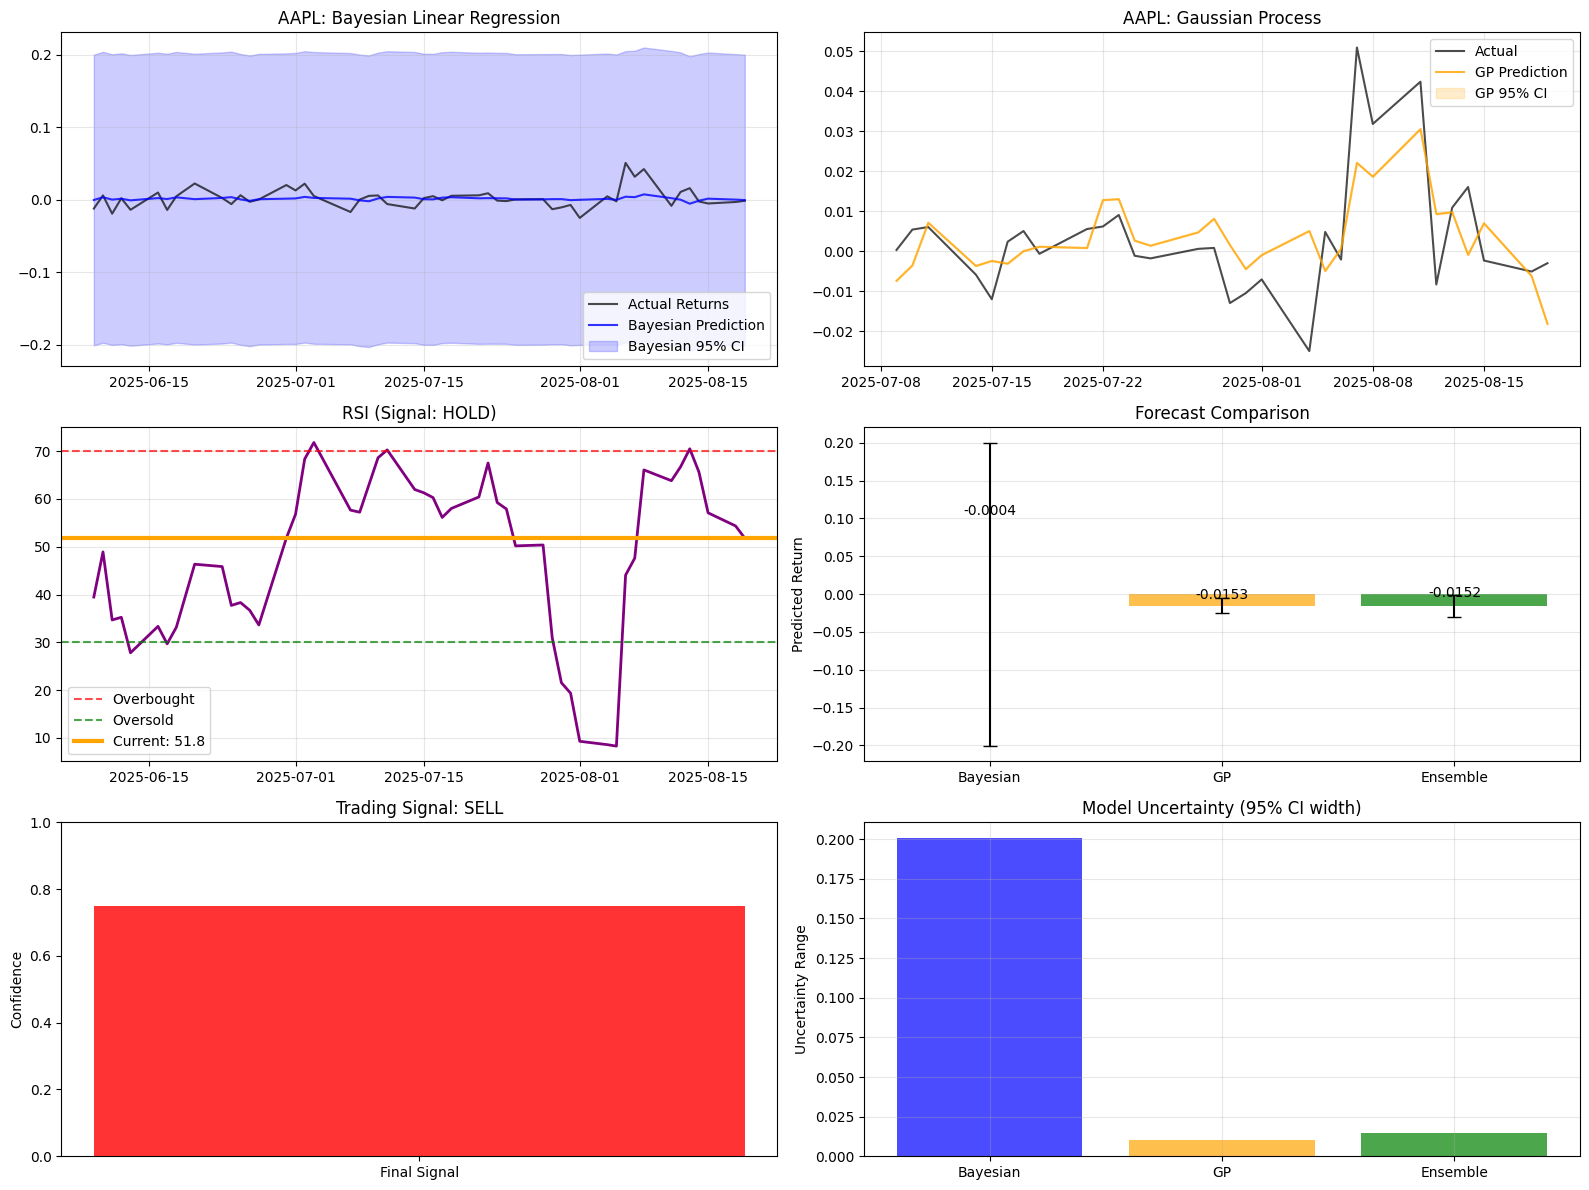


📊 AAPL - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: -0.0004 ± 0.2006
🟠 GP Forecast:       -0.0153 ± 0.0102
🟢 Ensemble Forecast: -0.0152 ± 0.0146
📈 RSI Signal:        HOLD (RSI: 51.8)
🎯 Final Signal:      SELL (Confidence: 75.0%)
💰 Recommendation:    SELL
Symbol: AAPL
Last: $230.56
Expected move: -1.52% (~$-3.52)
Z-score: -2.09, P(upside): 1.8%
Signal: SELL @ 75%
TP: 4.00%, SL: 2.00%
TP price: $239.78, SL price: $225.95
Sim qty (notional $100): 0.4337 shares


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for MSFT...
🟠 Running Gaussian Process for MSFT...


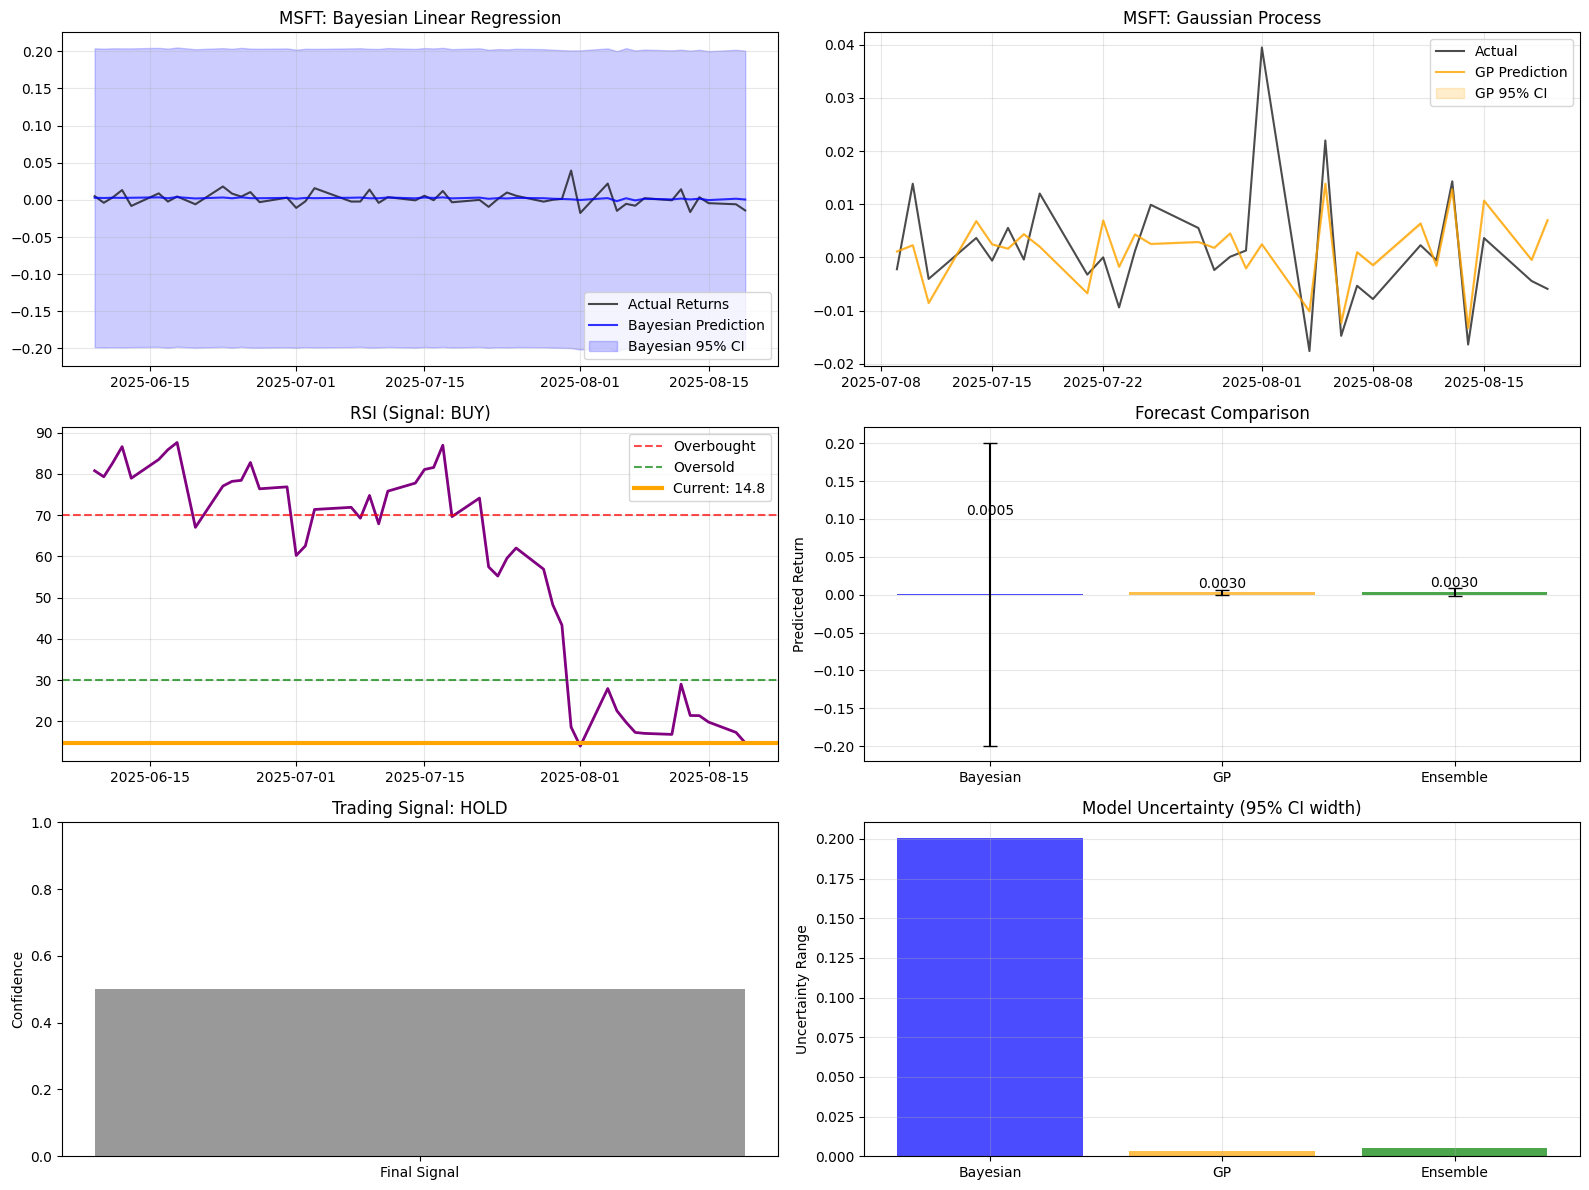


📊 MSFT - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0005 ± 0.2004
🟠 GP Forecast:       0.0030 ± 0.0034
🟢 Ensemble Forecast: 0.0030 ± 0.0053
📈 RSI Signal:        BUY (RSI: 14.8)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
Symbol: MSFT
Last: $510.06
Expected move: 0.30% (~$1.55)
Z-score: 1.15, P(upside): 87.5%
Signal: HOLD @ 50%
TP: 4.00%, SL: 2.00%
TP price: $530.46, SL price: $499.86
Sim qty (notional $100): 0.1961 shares


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for AMZN...
🟠 Running Gaussian Process for AMZN...


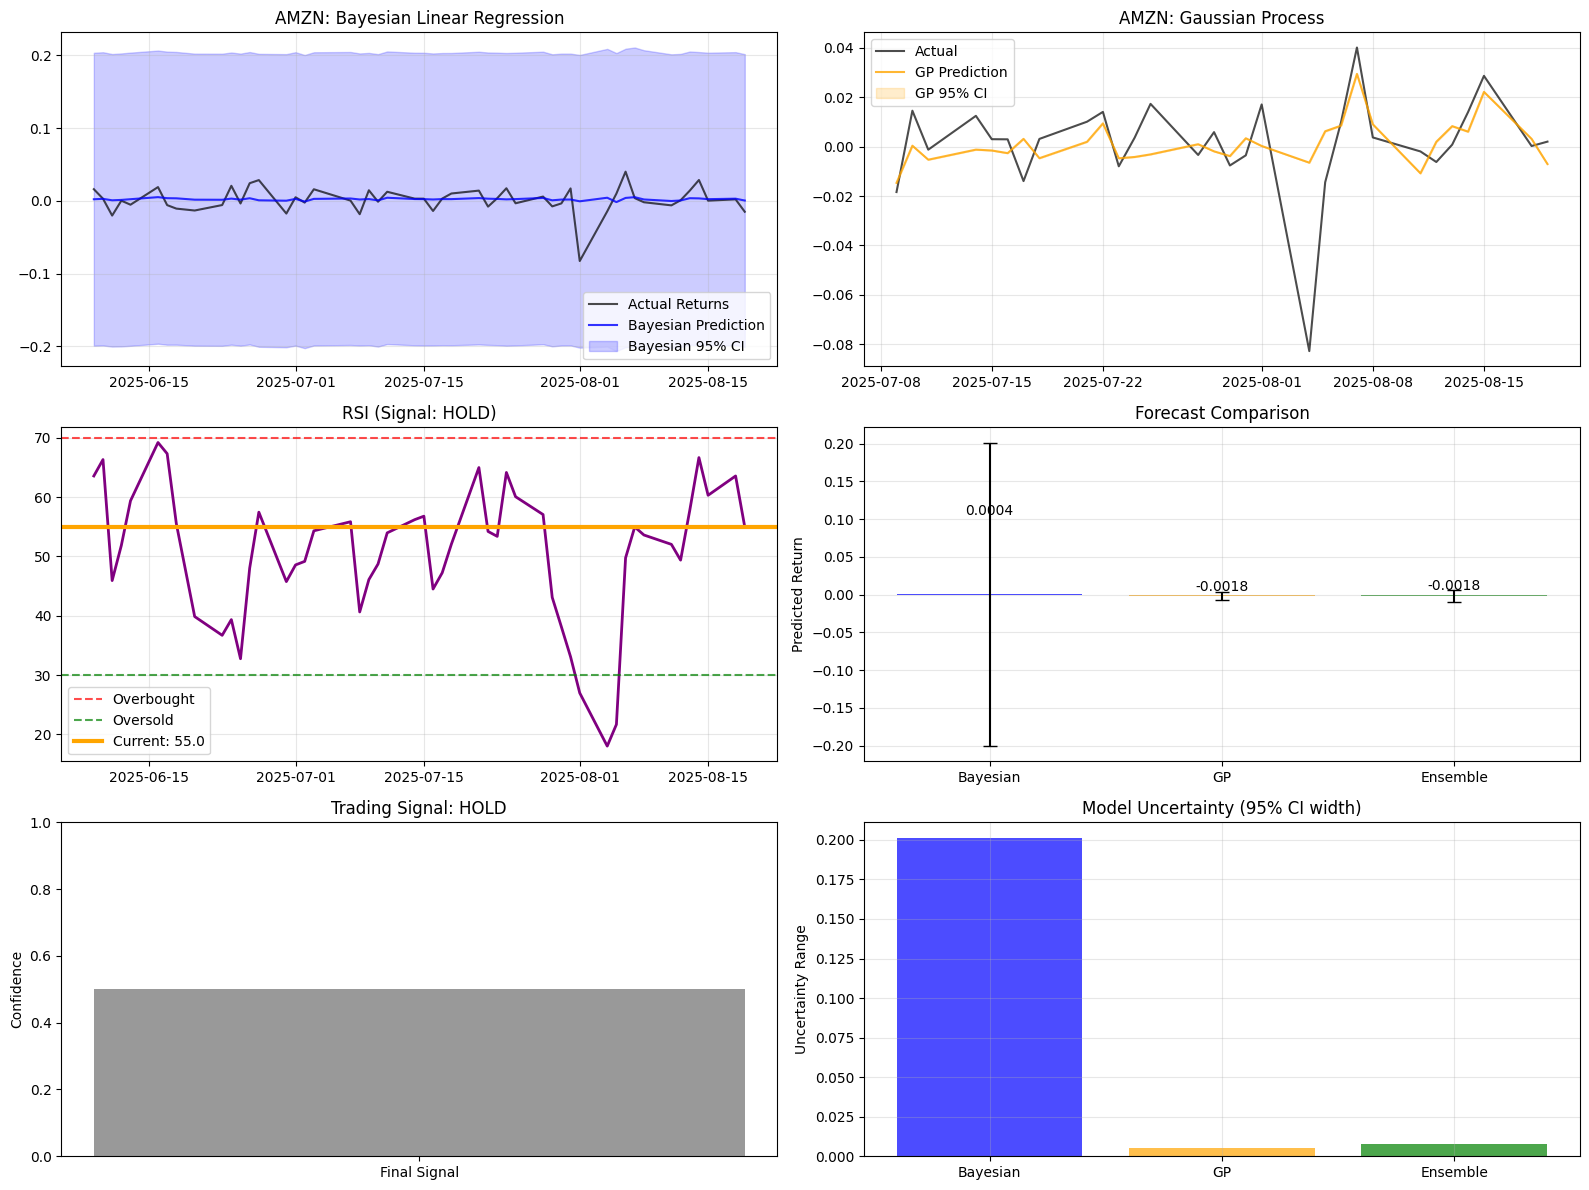


📊 AMZN - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0004 ± 0.2010
🟠 GP Forecast:       -0.0018 ± 0.0052
🟢 Ensemble Forecast: -0.0018 ± 0.0077
📈 RSI Signal:        HOLD (RSI: 55.0)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
Symbol: AMZN
Last: $228.00
Expected move: -0.18% (~$-0.42)
Z-score: -0.48, P(upside): 31.7%
Signal: HOLD @ 50%
TP: 4.00%, SL: 2.00%
TP price: $237.13, SL price: $223.44
Sim qty (notional $100): 0.4386 shares


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for GOOGL...
🟠 Running Gaussian Process for GOOGL...


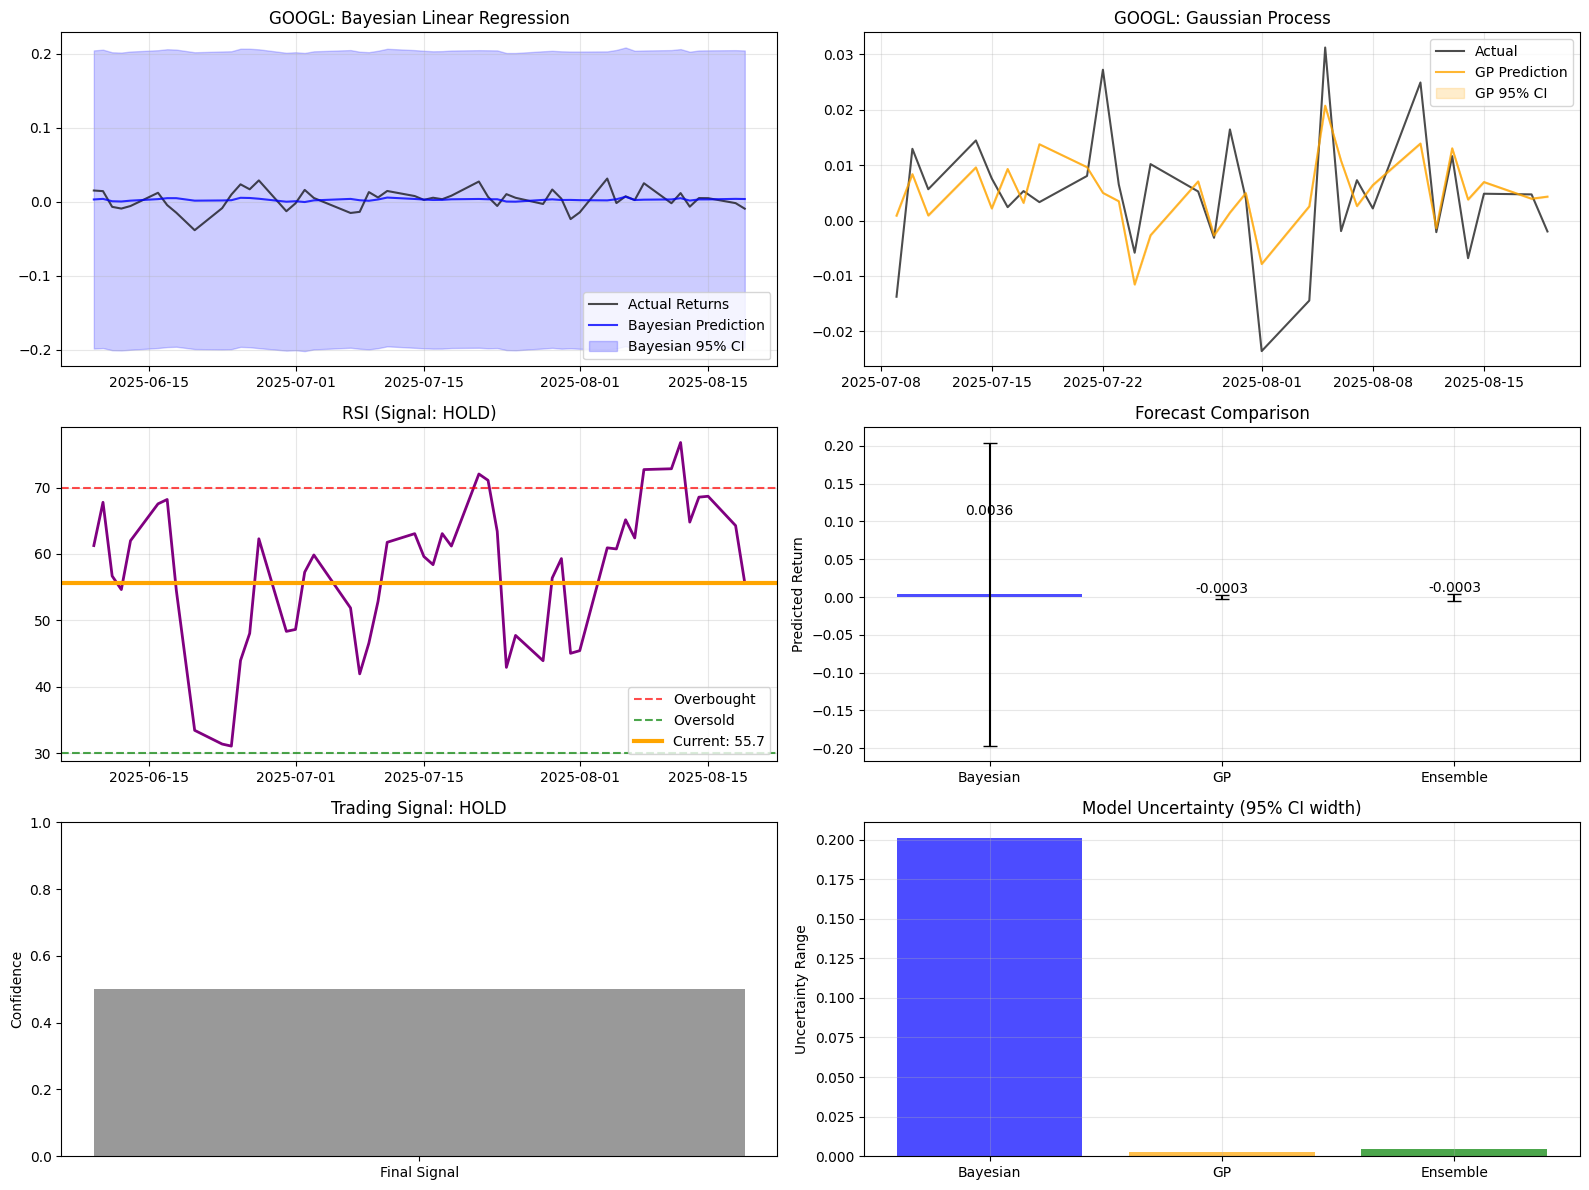


📊 GOOGL - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0036 ± 0.2008
🟠 GP Forecast:       -0.0003 ± 0.0030
🟢 Ensemble Forecast: -0.0003 ± 0.0047
📈 RSI Signal:        HOLD (RSI: 55.7)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
Symbol: GOOGL
Last: $201.64
Expected move: -0.03% (~$-0.05)
Z-score: -0.11, P(upside): 45.6%
Signal: HOLD @ 50%
TP: 4.00%, SL: 2.00%
TP price: $209.71, SL price: $197.61
Sim qty (notional $100): 0.4959 shares


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for META...
🟠 Running Gaussian Process for META...


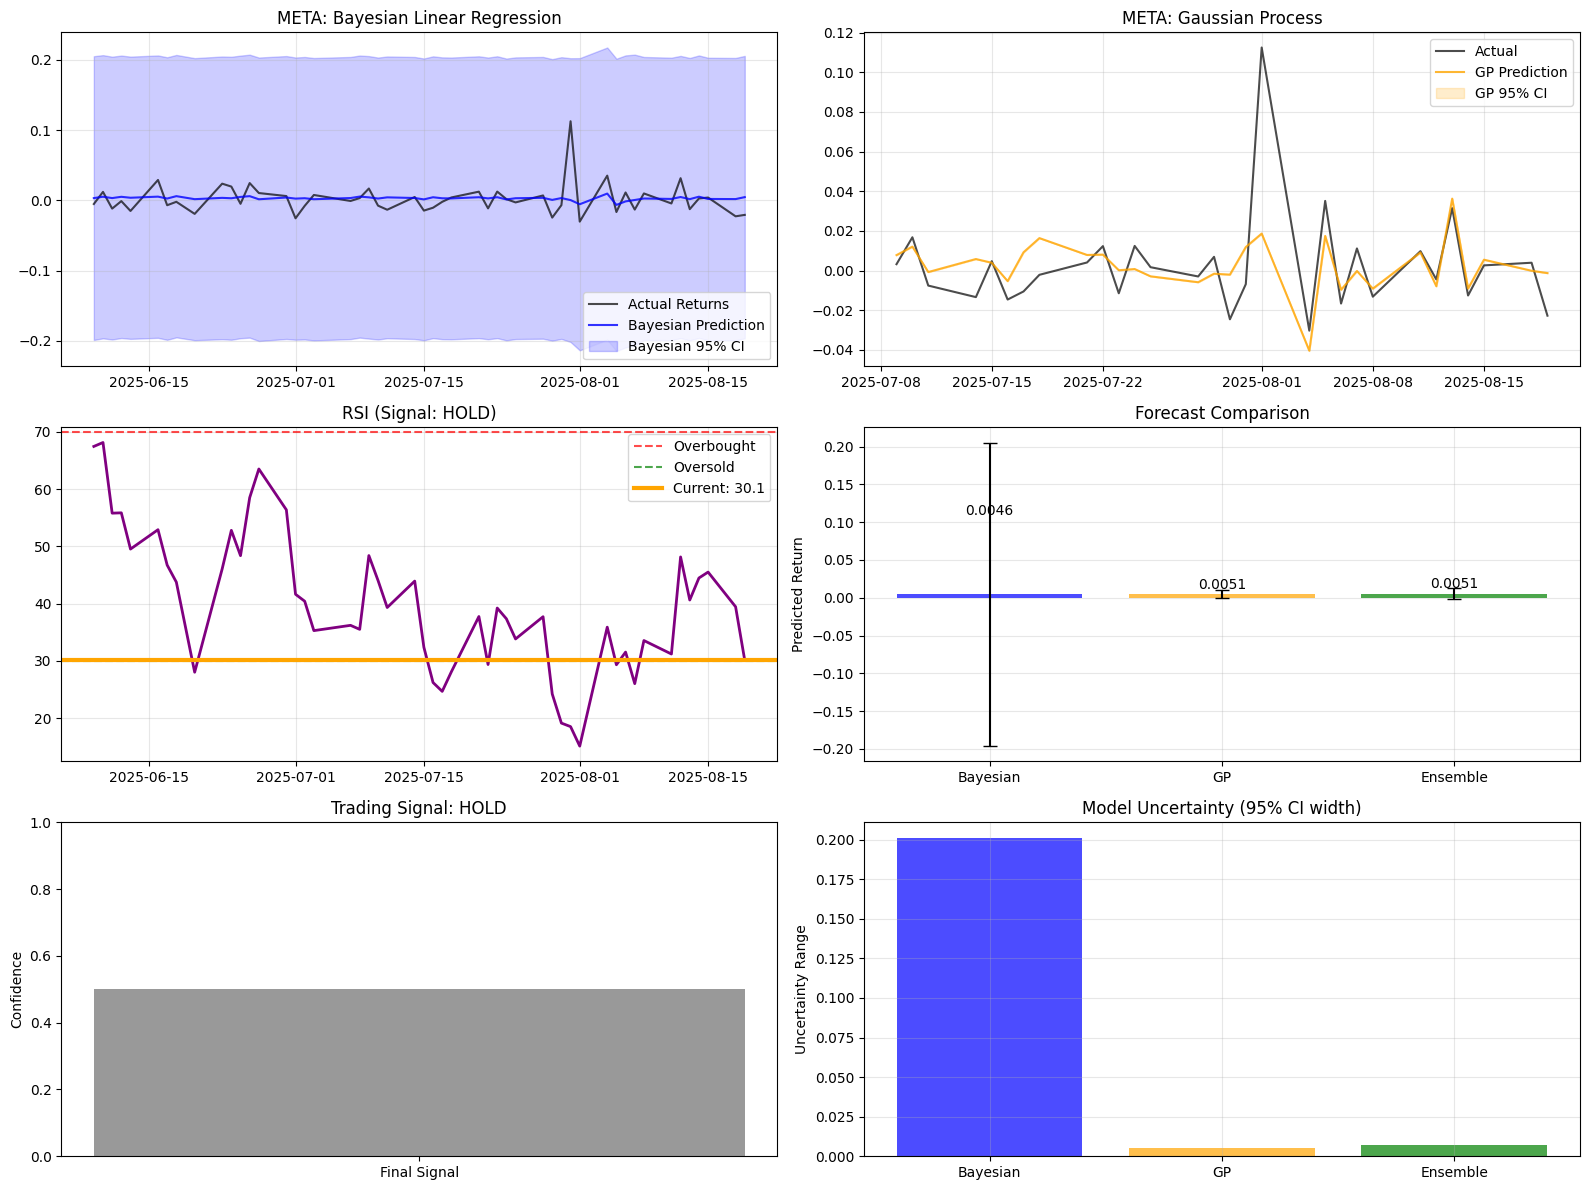


📊 META - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0046 ± 0.2009
🟠 GP Forecast:       0.0051 ± 0.0050
🟢 Ensemble Forecast: 0.0051 ± 0.0073
📈 RSI Signal:        HOLD (RSI: 30.1)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
Symbol: META
Last: $751.68
Expected move: 0.51% (~$3.83)
Z-score: 1.39, P(upside): 91.8%
Signal: HOLD @ 50%
TP: 4.00%, SL: 2.00%
TP price: $781.75, SL price: $736.65
Sim qty (notional $100): 0.1330 shares


[*********************100%***********************]  1 of 1 completed


🔵 Running Bayesian Linear Regression for NVDA...
🟠 Running Gaussian Process for NVDA...


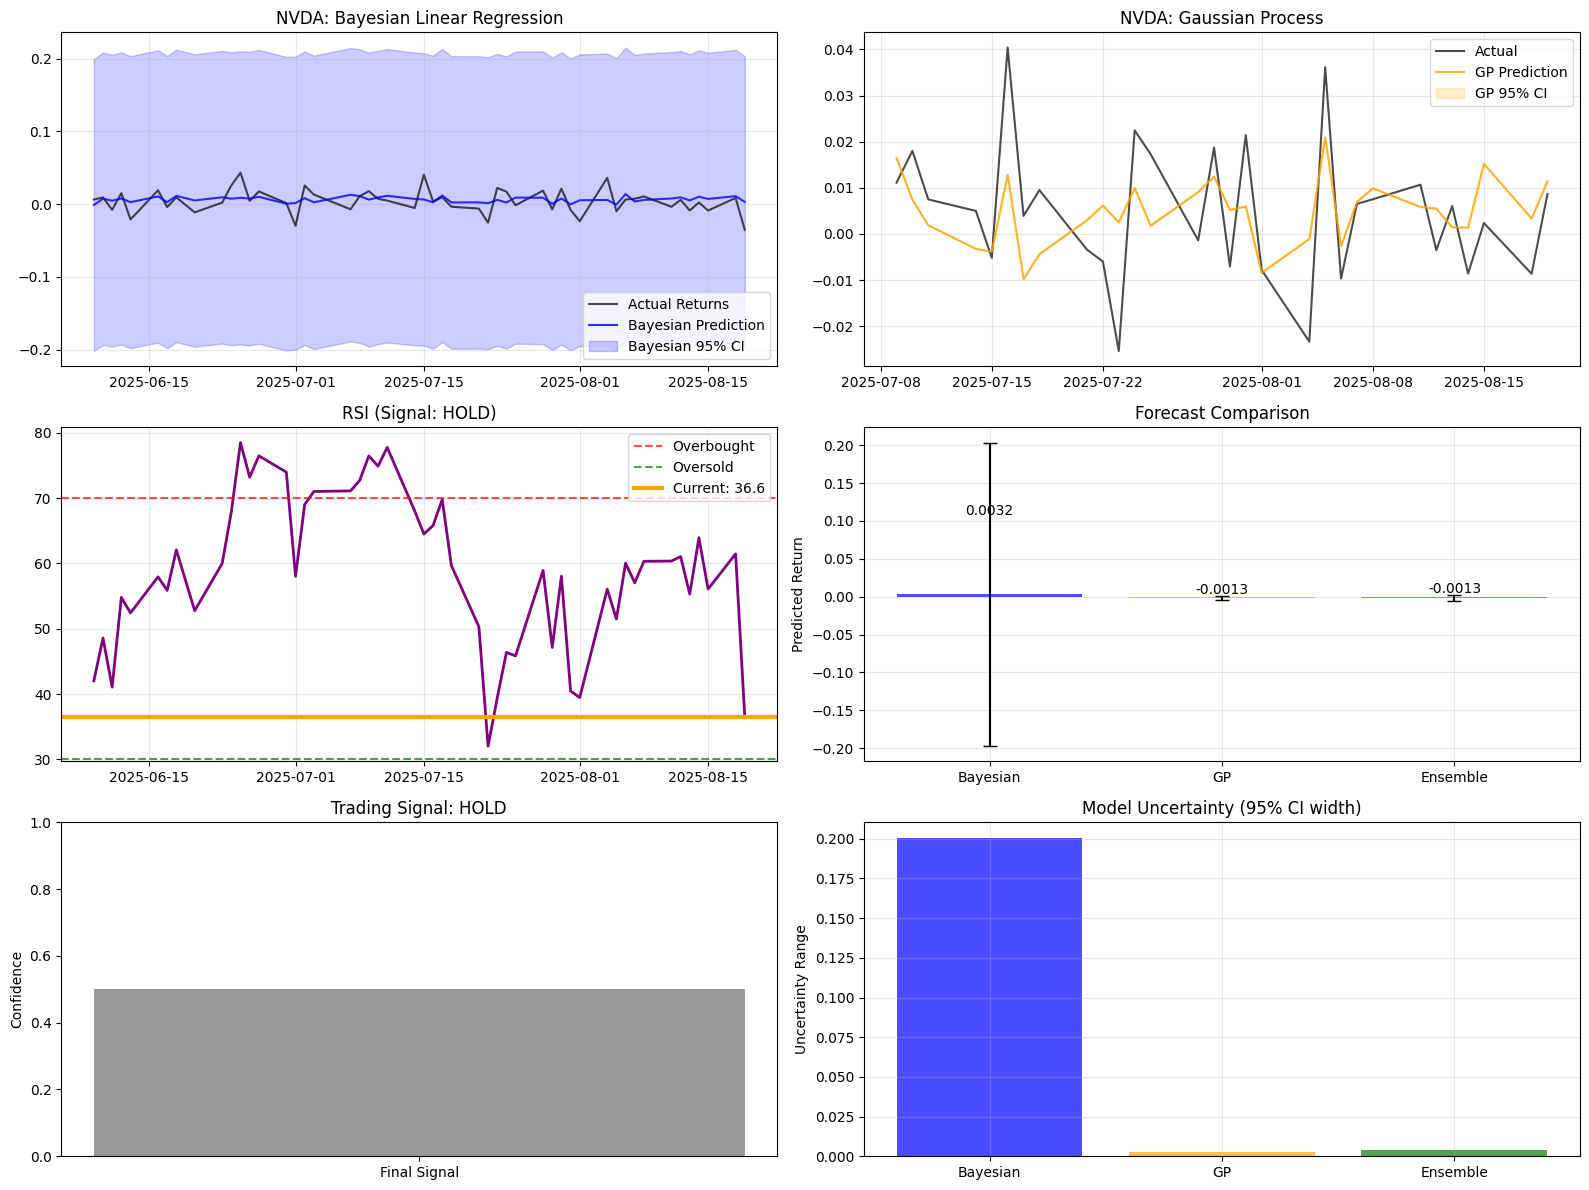


📊 NVDA - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0032 ± 0.2003
🟠 GP Forecast:       -0.0013 ± 0.0026
🟢 Ensemble Forecast: -0.0013 ± 0.0042
📈 RSI Signal:        HOLD (RSI: 36.6)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
Symbol: NVDA
Last: $175.66
Expected move: -0.13% (~$-0.23)
Z-score: -0.62, P(upside): 26.6%
Signal: HOLD @ 50%
TP: 4.00%, SL: 2.00%
TP price: $182.69, SL price: $172.15
Sim qty (notional $100): 0.5693 shares


[*********************100%***********************]  1 of 1 completed


🔵 Running Bayesian Linear Regression for TSLA...
🟠 Running Gaussian Process for TSLA...


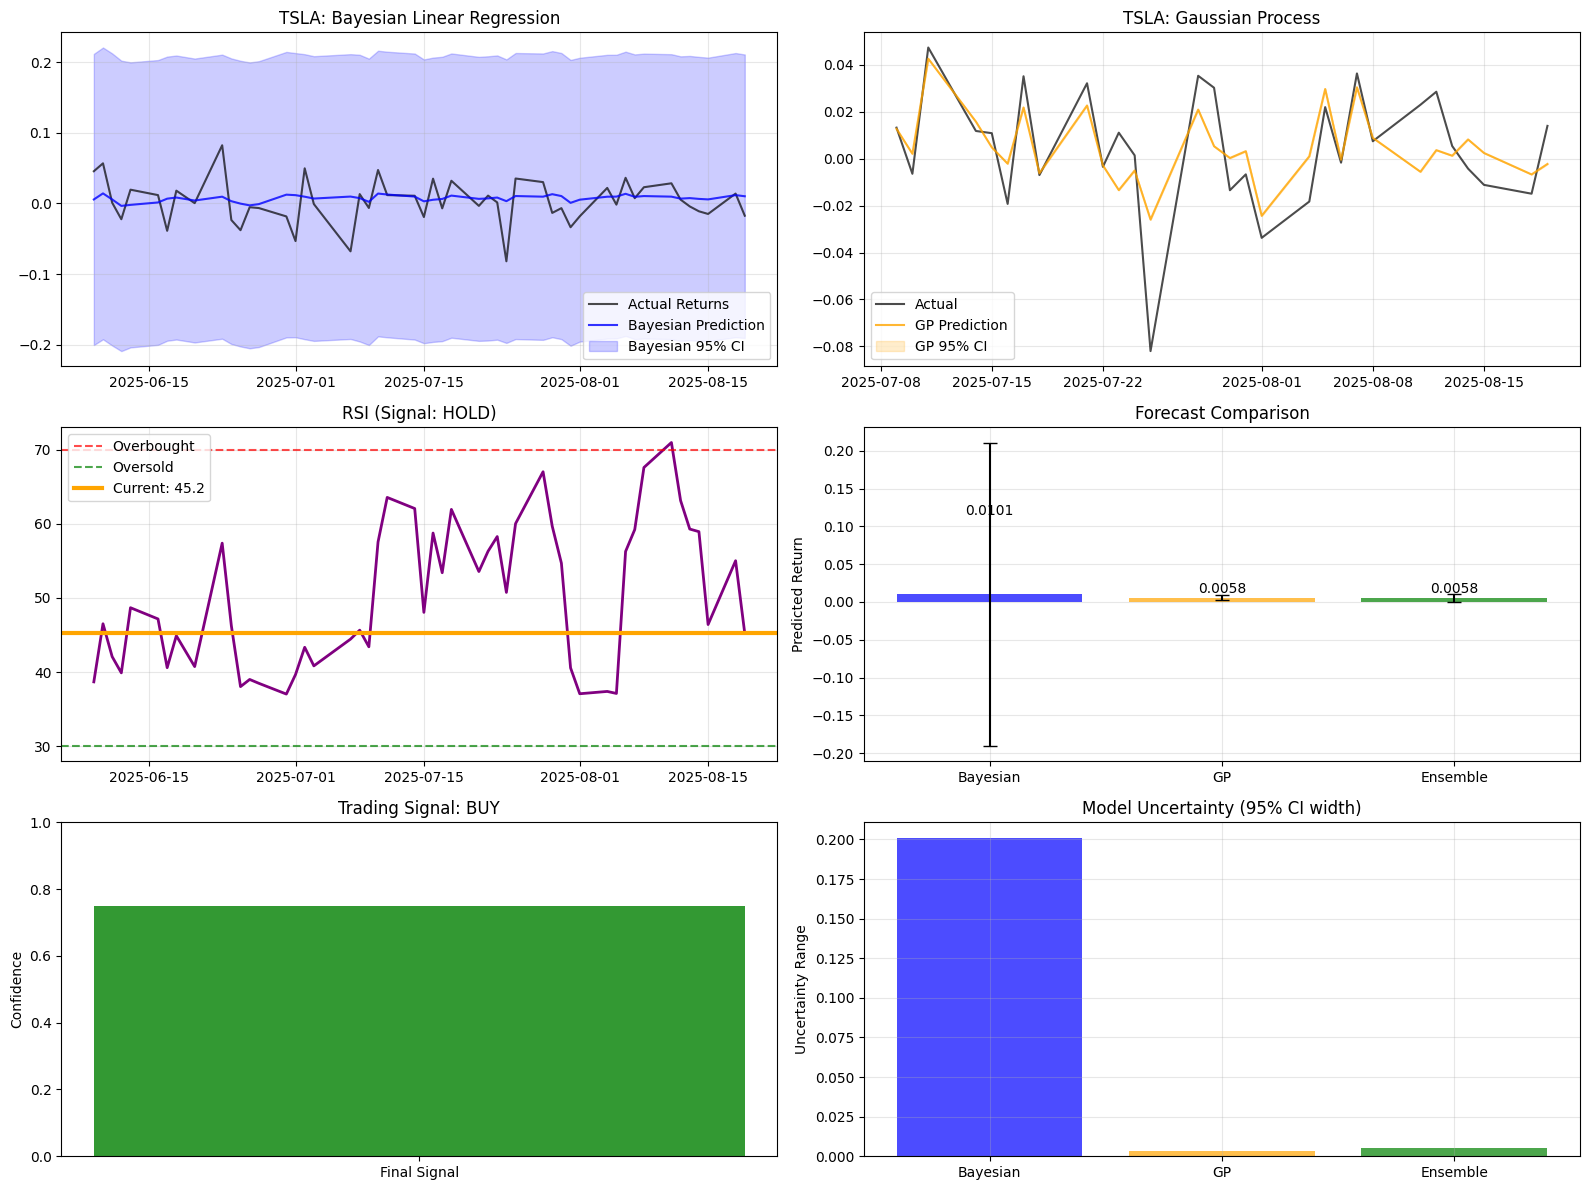


📊 TSLA - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0101 ± 0.2008
🟠 GP Forecast:       0.0058 ± 0.0035
🟢 Ensemble Forecast: 0.0058 ± 0.0053
📈 RSI Signal:        HOLD (RSI: 45.2)
🎯 Final Signal:      BUY (Confidence: 75.0%)
💰 Recommendation:    BUY
Symbol: TSLA
Last: $328.24
Expected move: 0.58% (~$1.92)
Z-score: 2.19, P(upside): 98.6%
Signal: BUY @ 75%
TP: 4.00%, SL: 2.00%
TP price: $341.37, SL price: $321.68
Sim qty (notional $100): 0.3047 shares


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for JPM...
🟠 Running Gaussian Process for JPM...


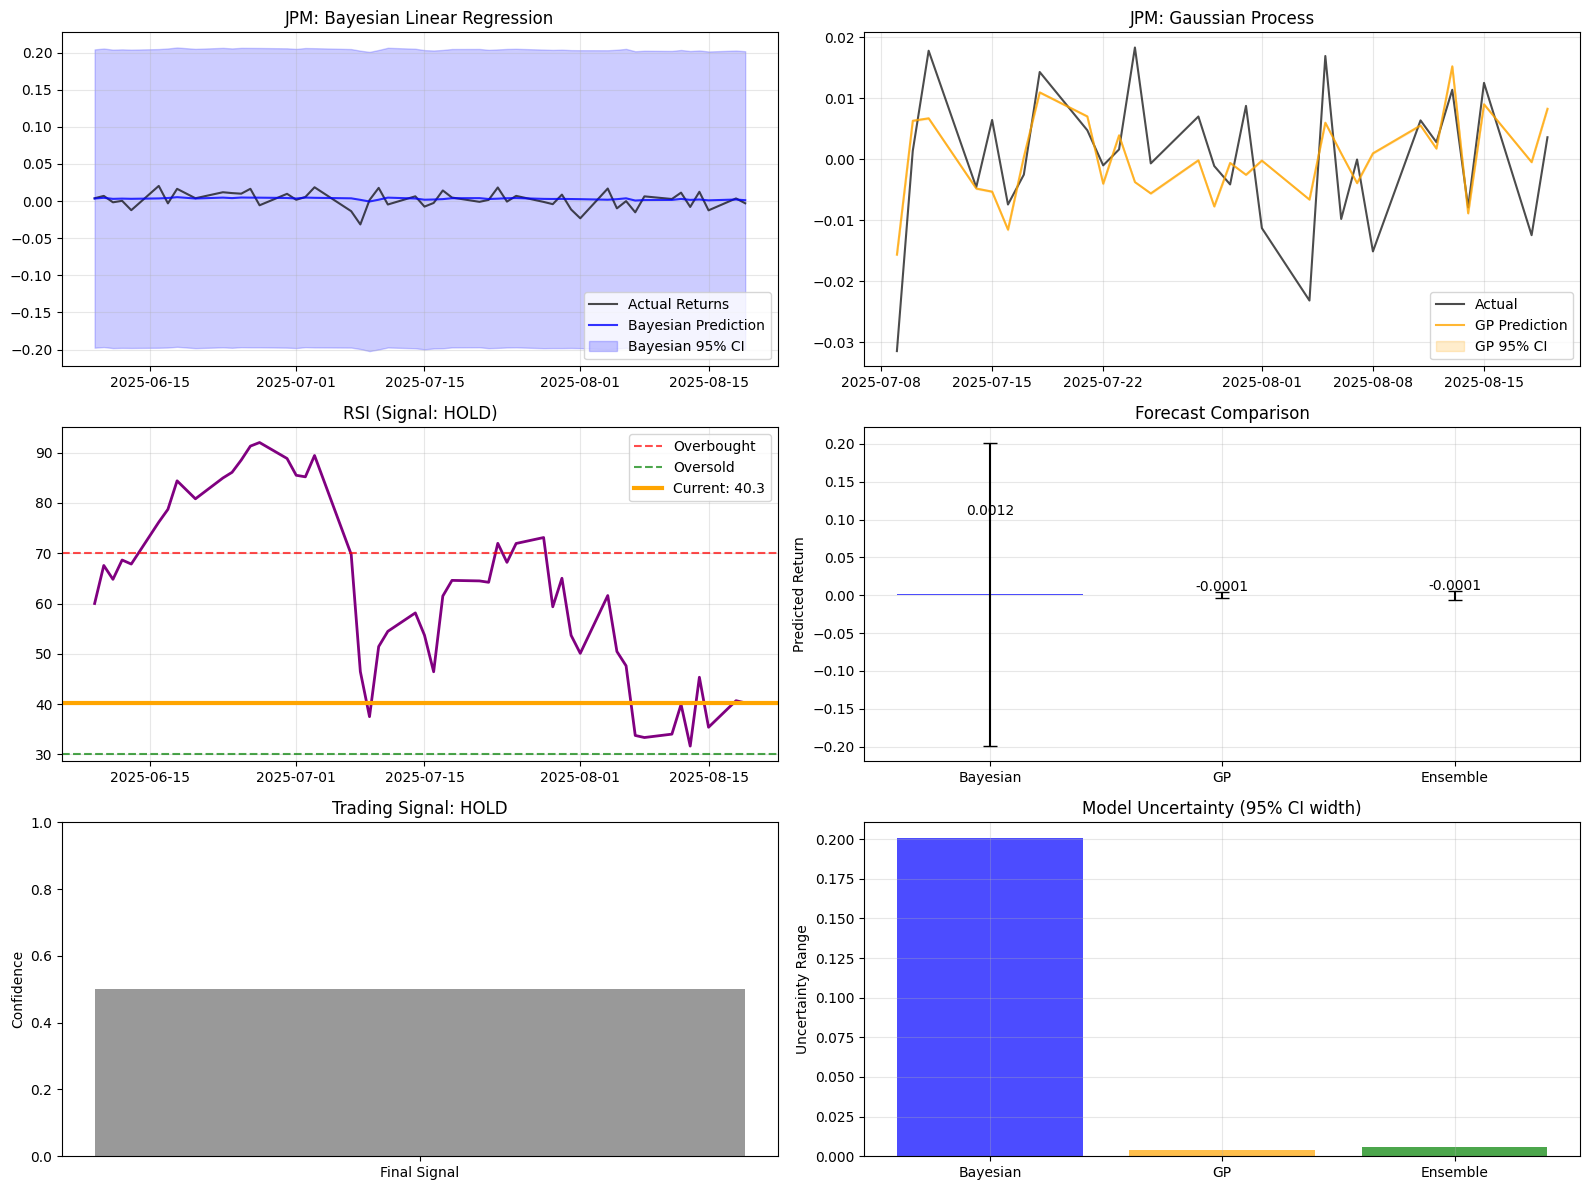


📊 JPM - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0012 ± 0.2006
🟠 GP Forecast:       -0.0001 ± 0.0037
🟢 Ensemble Forecast: -0.0001 ± 0.0056
📈 RSI Signal:        HOLD (RSI: 40.3)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
Symbol: JPM
Last: $290.65
Expected move: -0.01% (~$-0.02)
Z-score: -0.03, P(upside): 48.8%
Signal: HOLD @ 50%
TP: 4.00%, SL: 2.00%
TP price: $302.28, SL price: $284.84
Sim qty (notional $100): 0.3441 shares


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for V...
🟠 Running Gaussian Process for V...


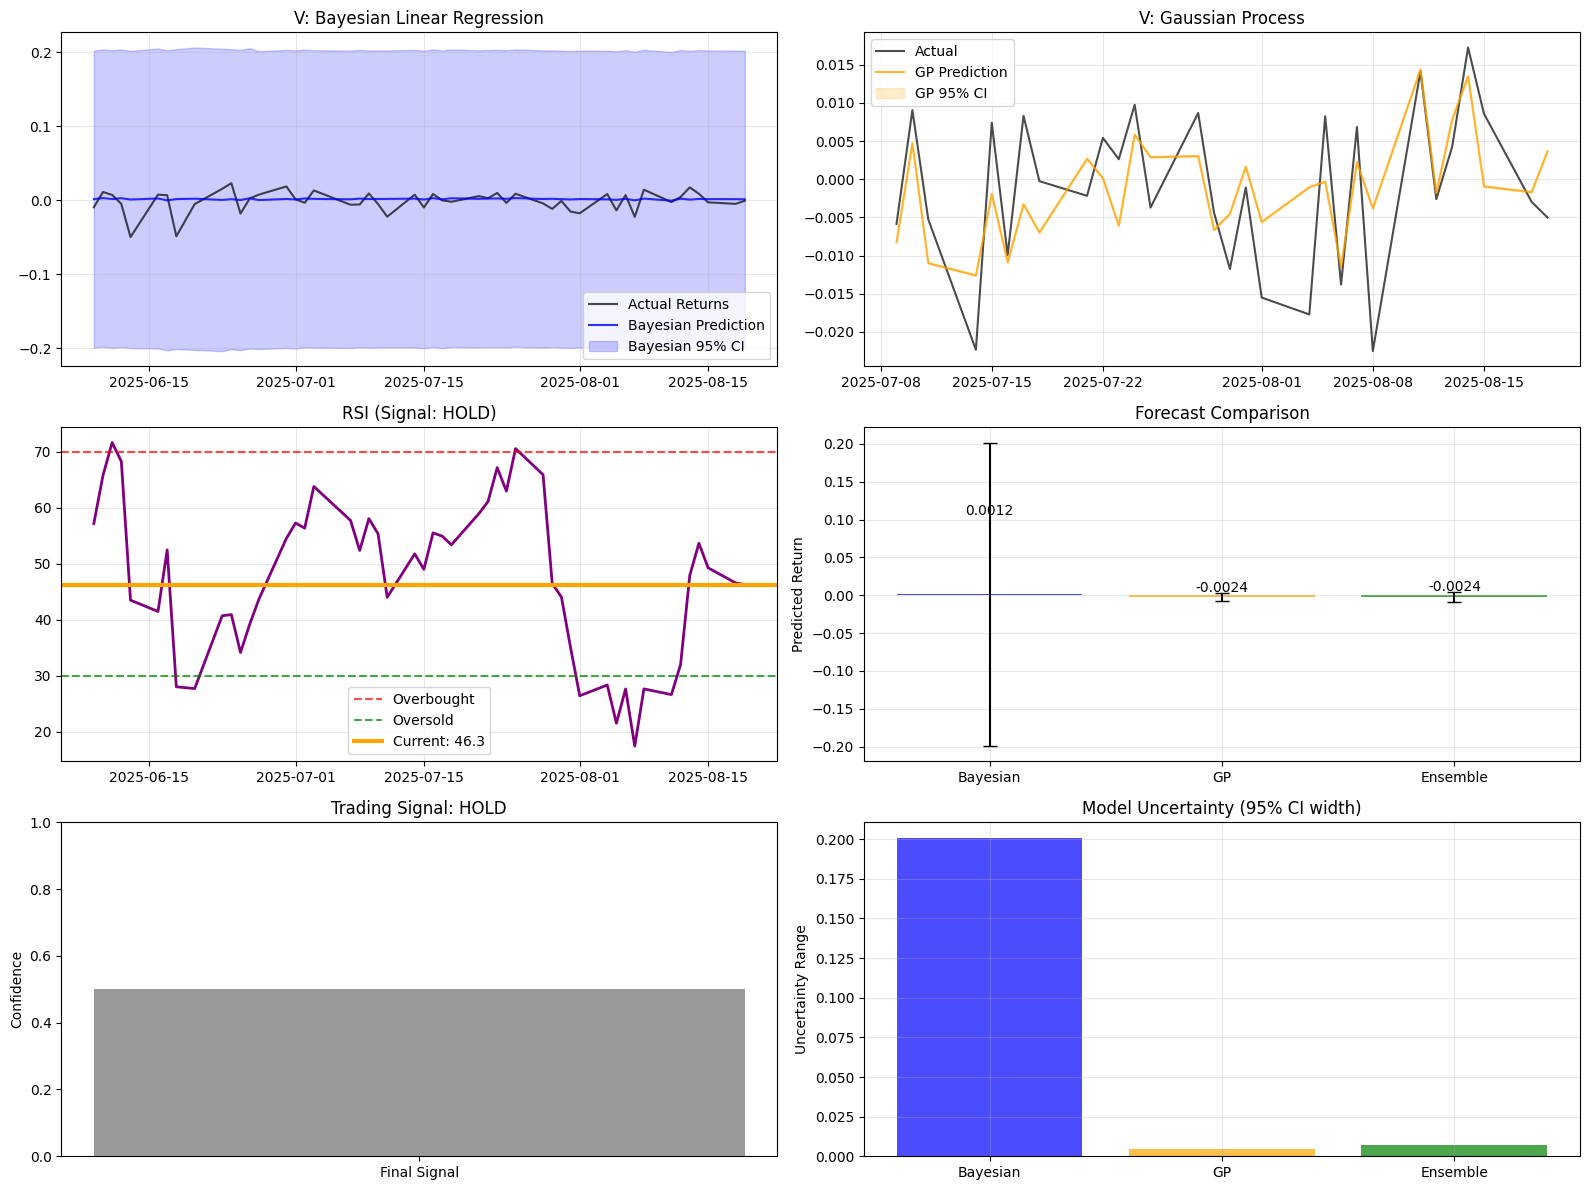


📊 V - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0012 ± 0.2006
🟠 GP Forecast:       -0.0024 ± 0.0047
🟢 Ensemble Forecast: -0.0024 ± 0.0069
📈 RSI Signal:        HOLD (RSI: 46.3)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
Symbol: V
Last: $342.56
Expected move: -0.24% (~$-0.83)
Z-score: -0.70, P(upside): 24.2%
Signal: HOLD @ 50%
TP: 4.00%, SL: 2.00%
TP price: $356.26, SL price: $335.71
Sim qty (notional $100): 0.2919 shares


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for UNH...
🟠 Running Gaussian Process for UNH...


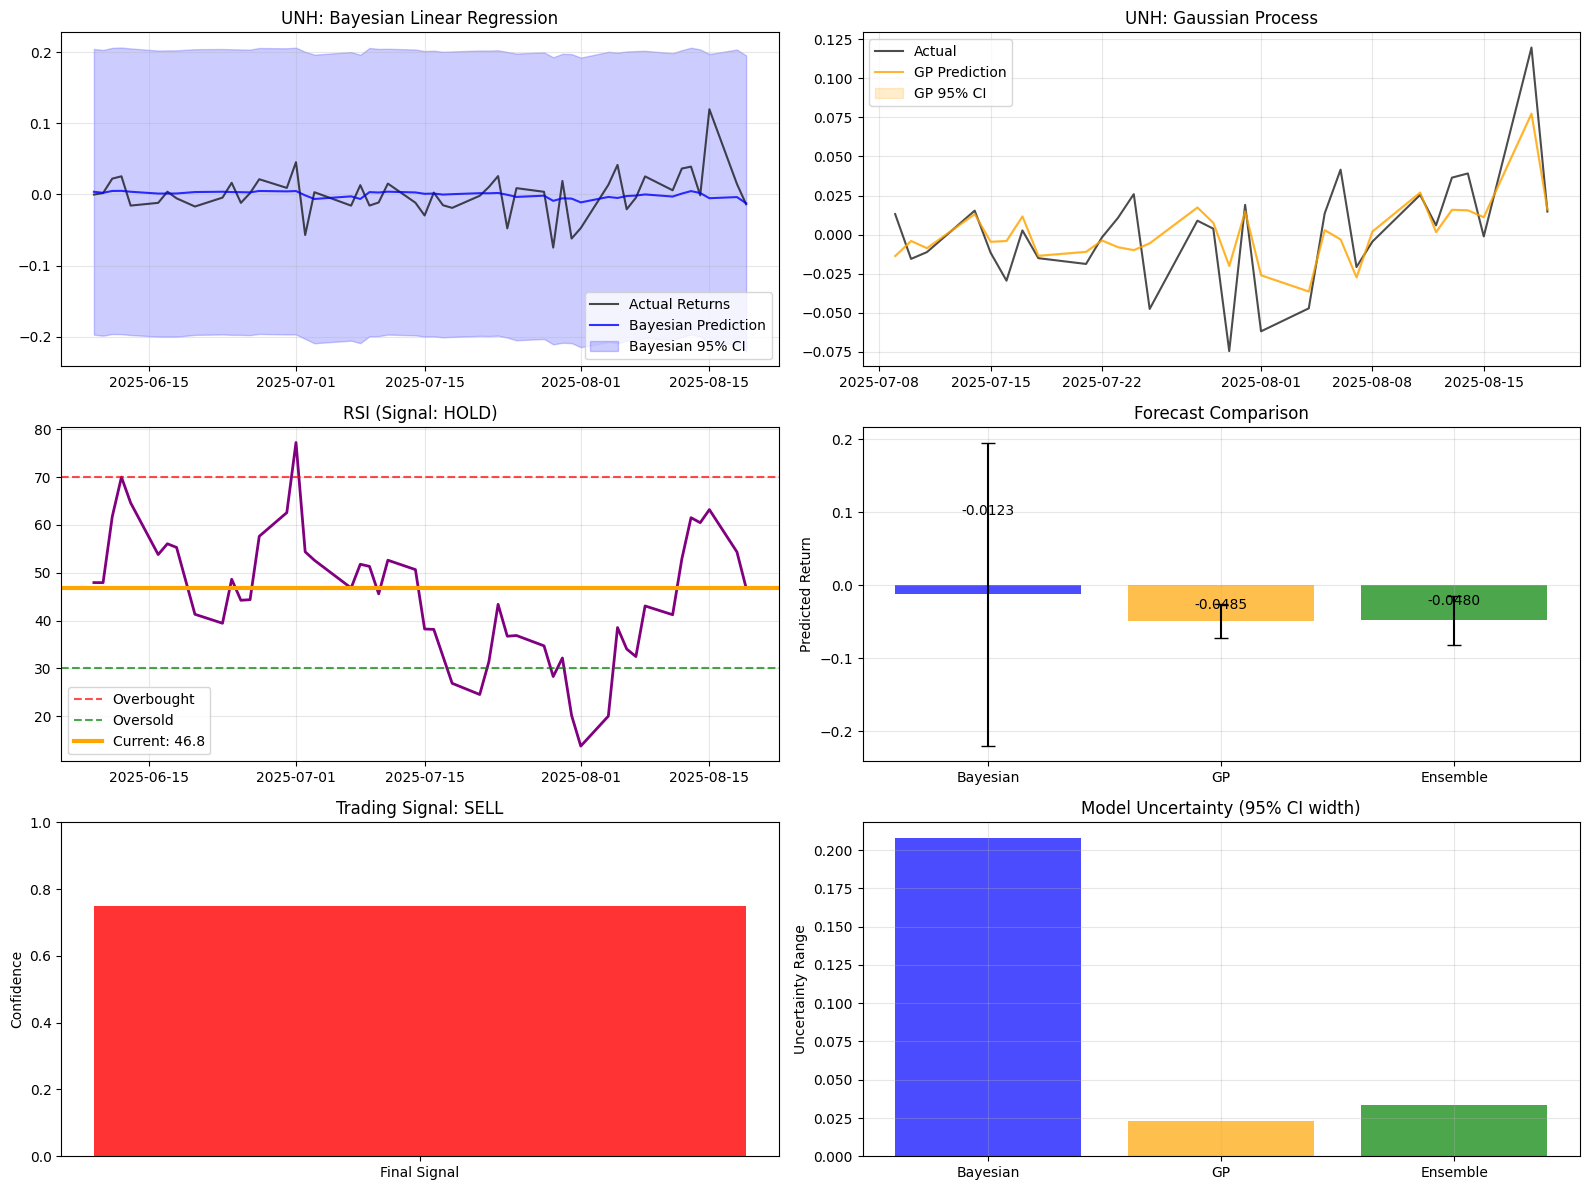


📊 UNH - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: -0.0123 ± 0.2078
🟠 GP Forecast:       -0.0485 ± 0.0233
🟢 Ensemble Forecast: -0.0480 ± 0.0338
📈 RSI Signal:        HOLD (RSI: 46.8)
🎯 Final Signal:      SELL (Confidence: 75.0%)
💰 Recommendation:    SELL
Symbol: UNH
Last: $304.22
Expected move: -4.80% (~$-14.60)
Z-score: -2.84, P(upside): 0.2%
Signal: SELL @ 75%
TP: 4.00%, SL: 2.00%
TP price: $316.39, SL price: $298.14
Sim qty (notional $100): 0.3287 shares


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for SPY...
🟠 Running Gaussian Process for SPY...


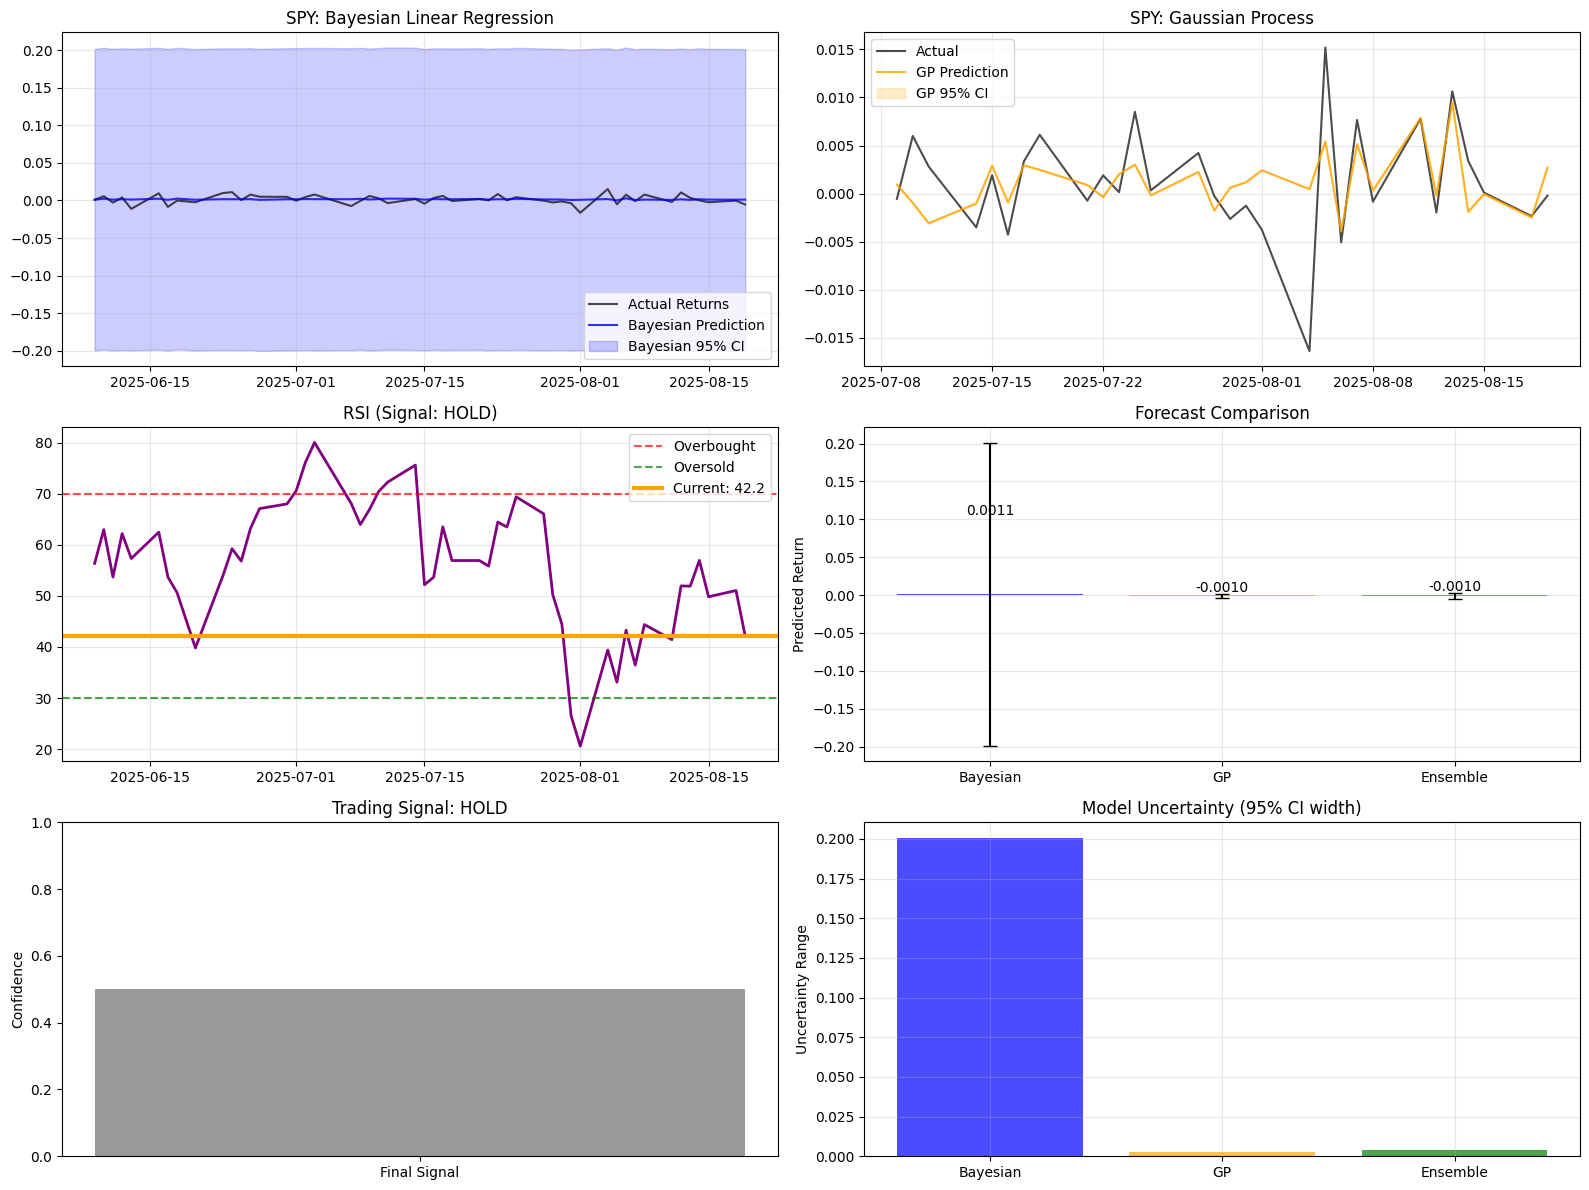


📊 SPY - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0011 ± 0.2004
🟠 GP Forecast:       -0.0010 ± 0.0026
🟢 Ensemble Forecast: -0.0010 ± 0.0042
📈 RSI Signal:        HOLD (RSI: 42.2)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
Symbol: SPY
Last: $639.89
Expected move: -0.10% (~$-0.63)
Z-score: -0.47, P(upside): 31.8%
Signal: HOLD @ 50%
TP: 4.00%, SL: 2.00%
TP price: $665.49, SL price: $627.09
Sim qty (notional $100): 0.1563 shares


In [12]:
# ...existing code...
# Preview every symbol (may print a lot and show plots if your function does)
for sym in UNIVERSE:
    print("="*60)
    try:
        preview_signal(sym)
    except Exception as e:
        print(f"[error] {sym}: {e}")
    time.sleep(0.3)  # ease rate limits
# ...existing code...

In [13]:
import io
from contextlib import contextmanager, redirect_stdout, redirect_stderr
import matplotlib.pyplot as plt

@contextmanager
def suppress_output(enabled=True):
    if not enabled:
        yield
        return
    buf = io.StringIO()
    with redirect_stdout(buf), redirect_stderr(buf):
        yield

@contextmanager
def suppress_plots(enabled=True):
    if not enabled:
        yield
        return
    _show = plt.show
    try:
        plt.show = lambda *a, **k: None
        yield
    finally:
        plt.show = _show

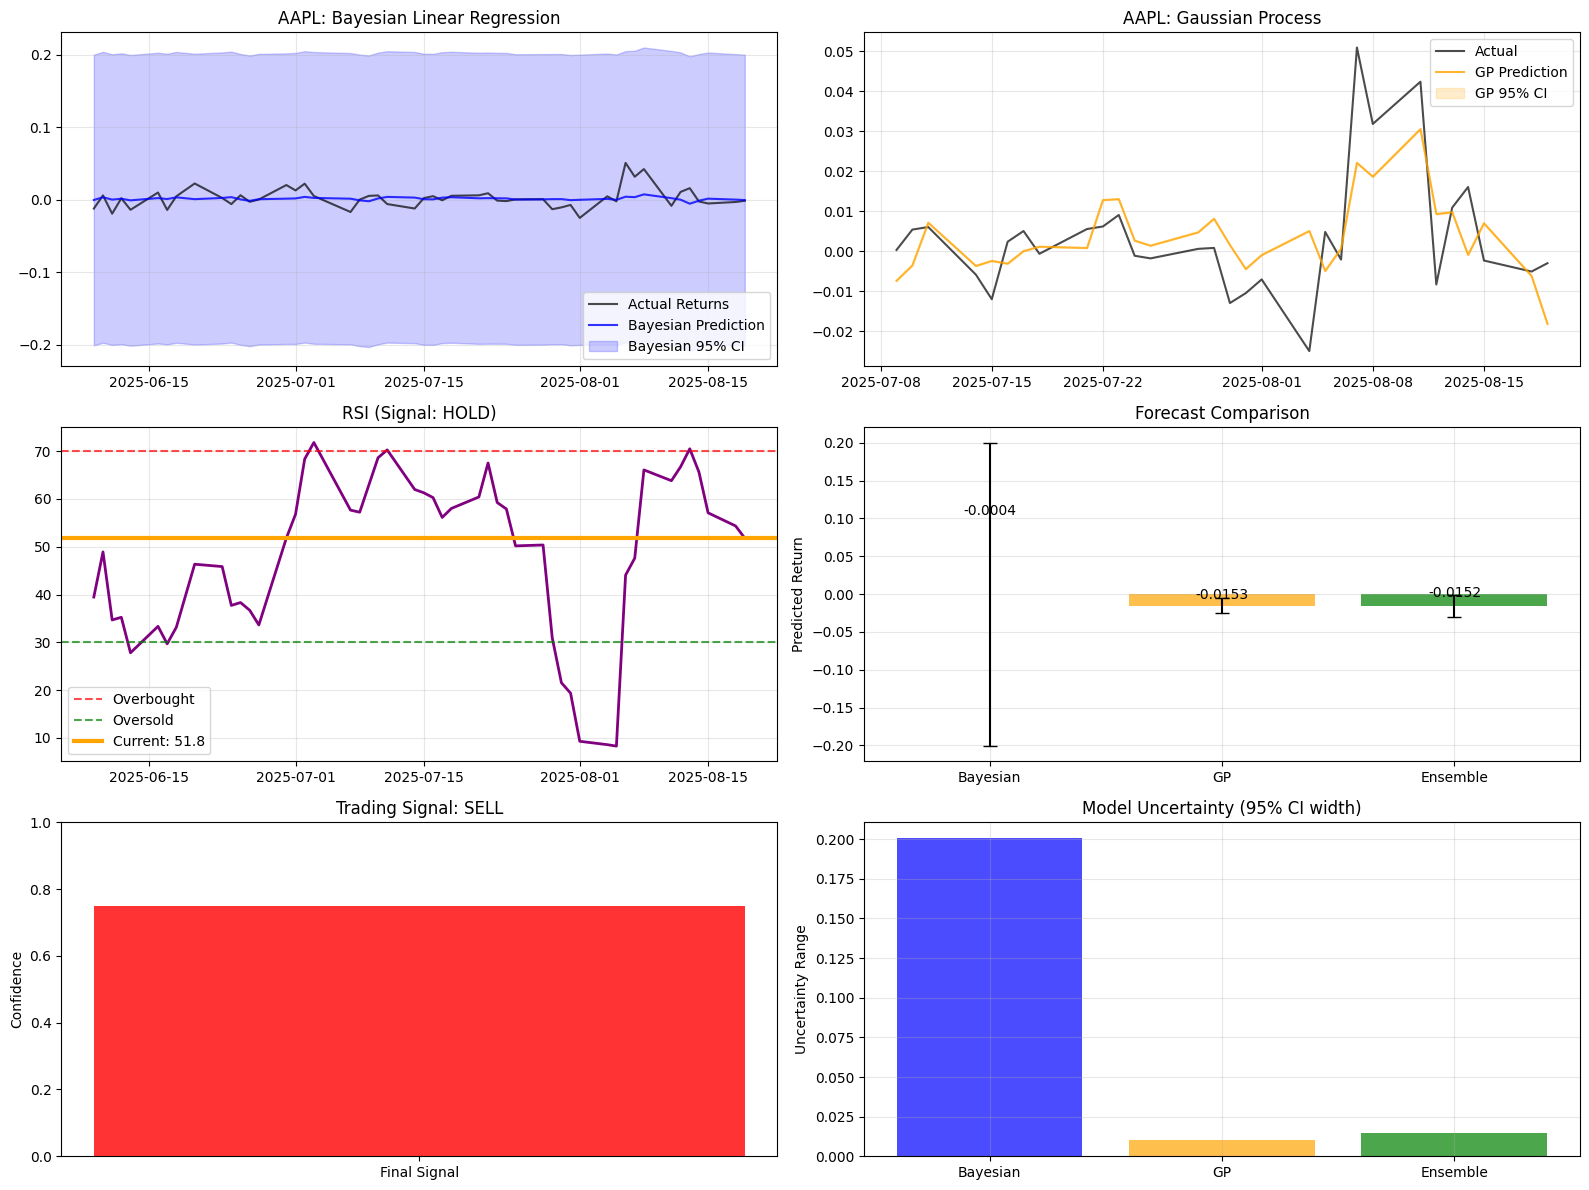

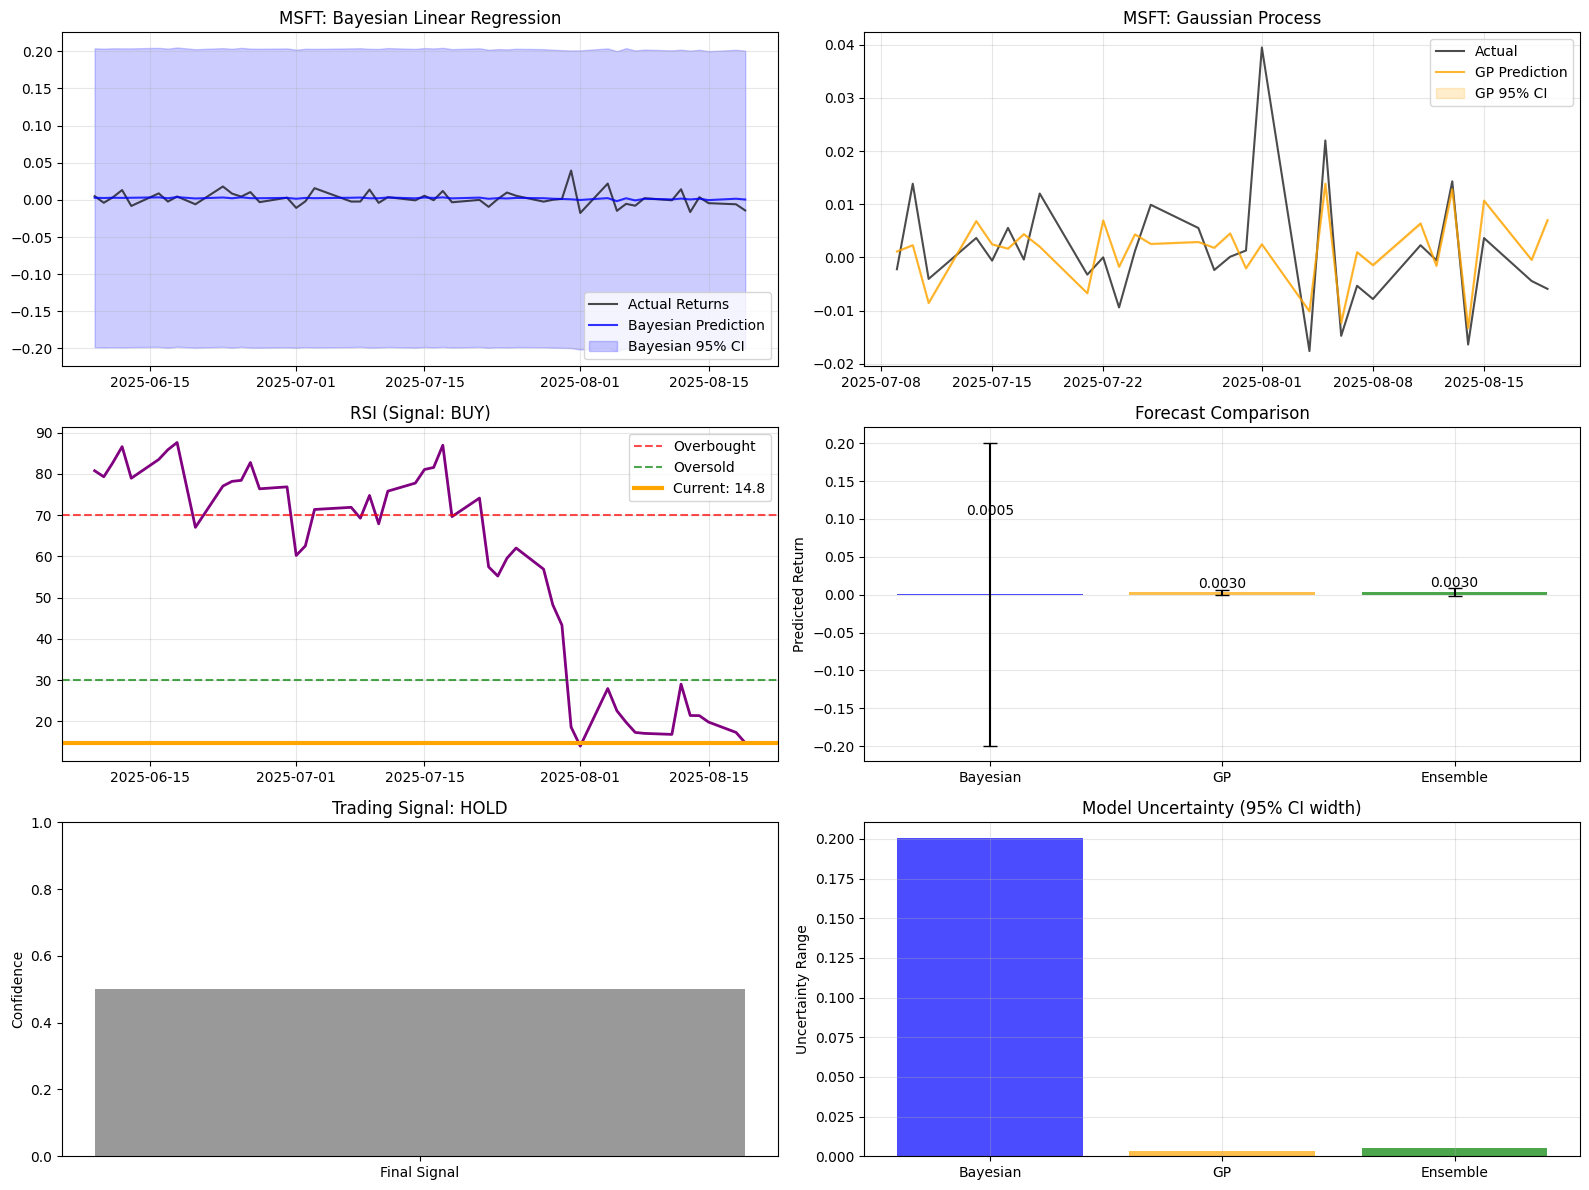

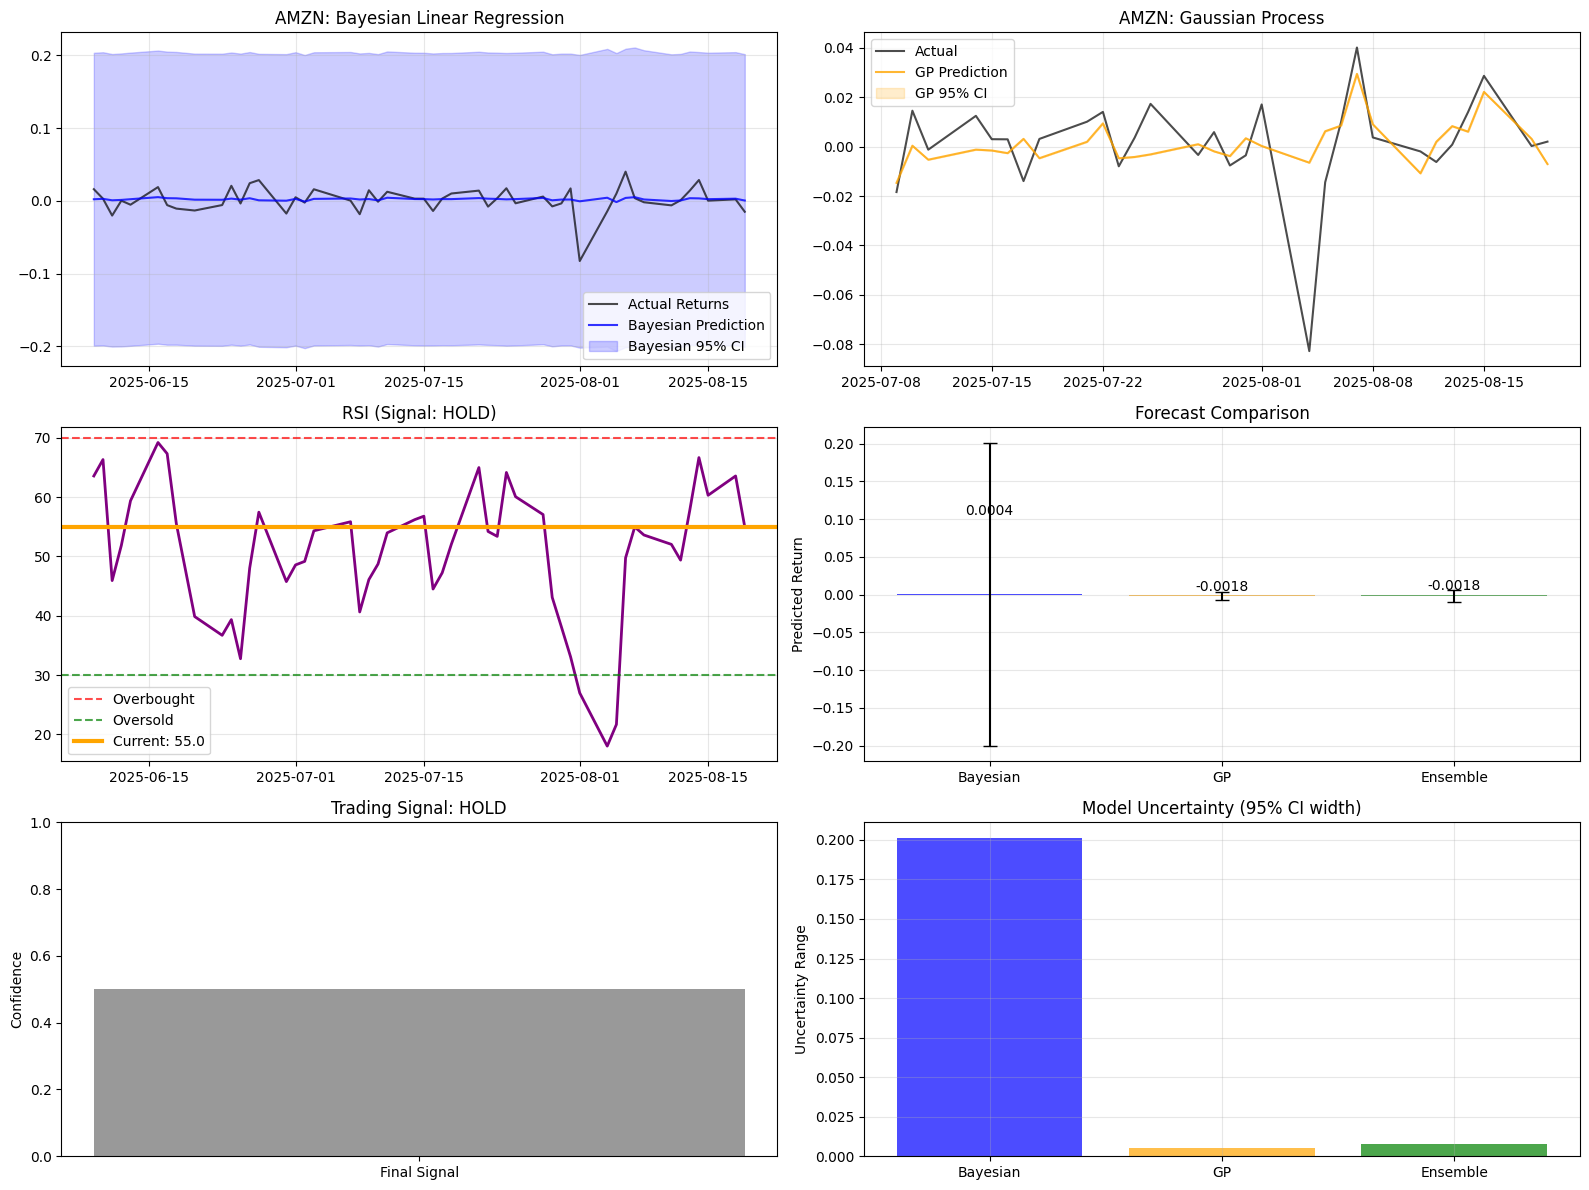

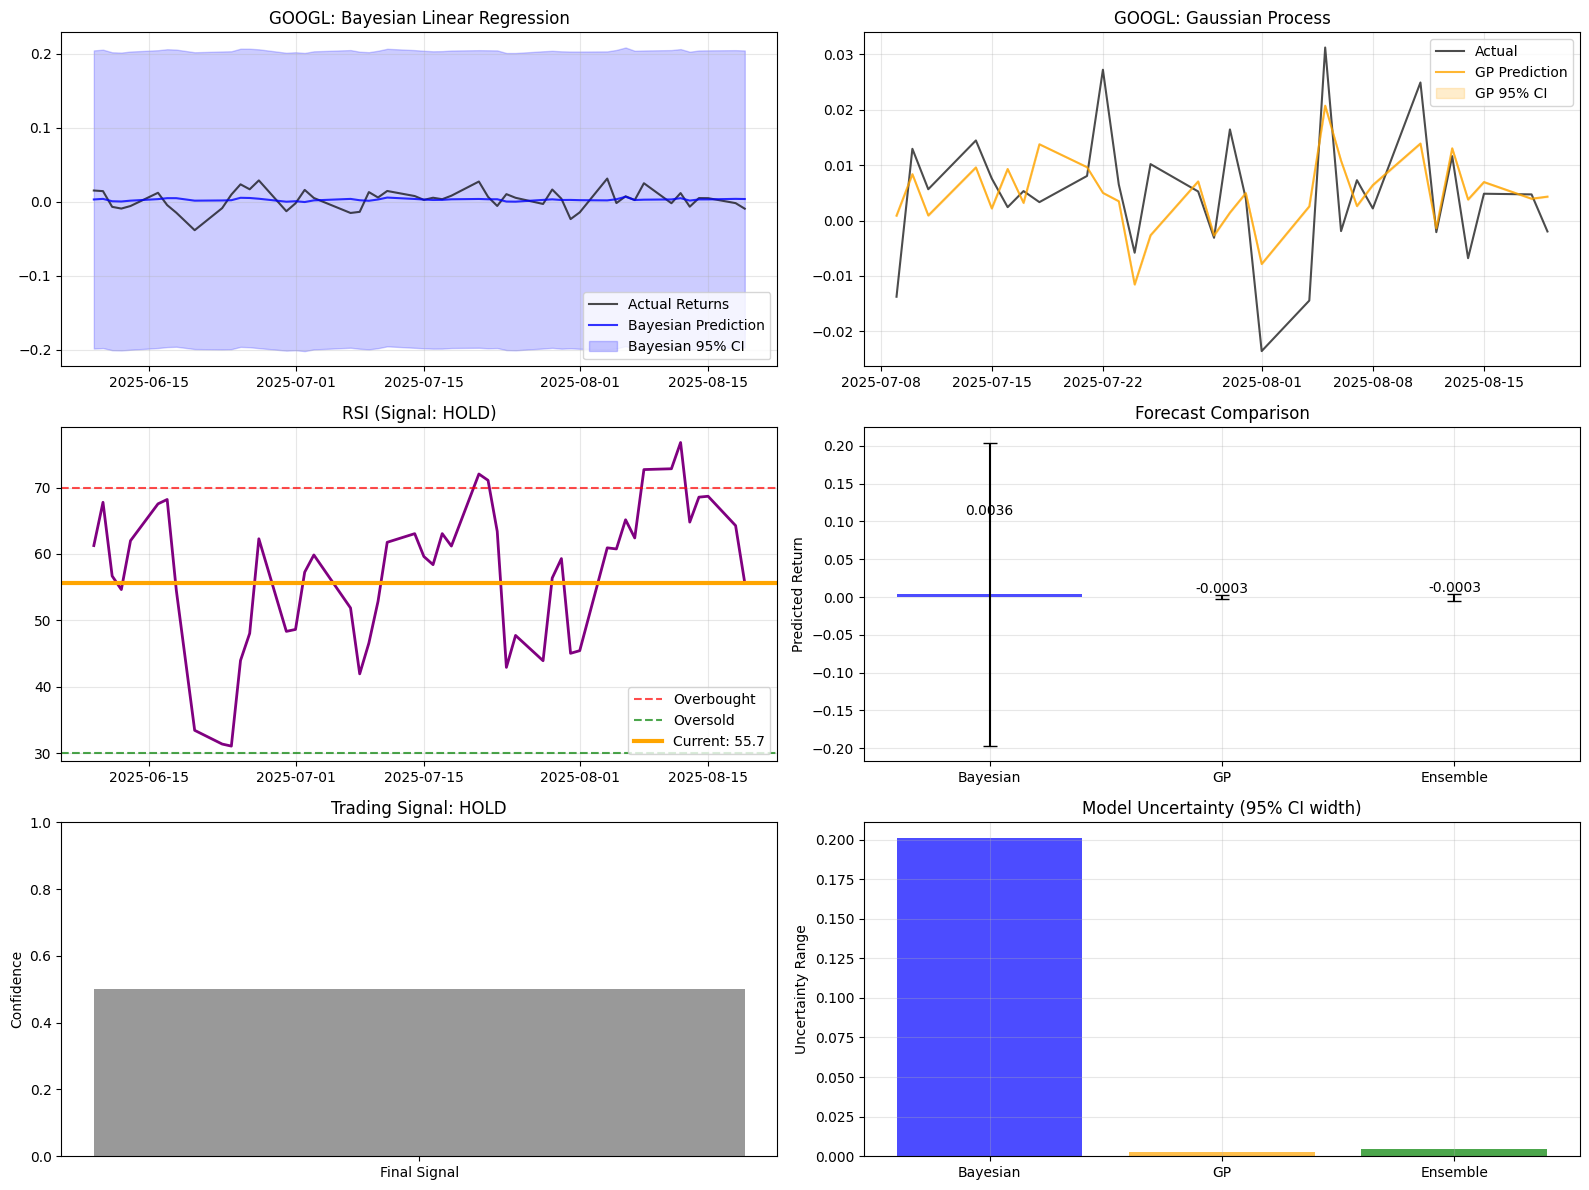

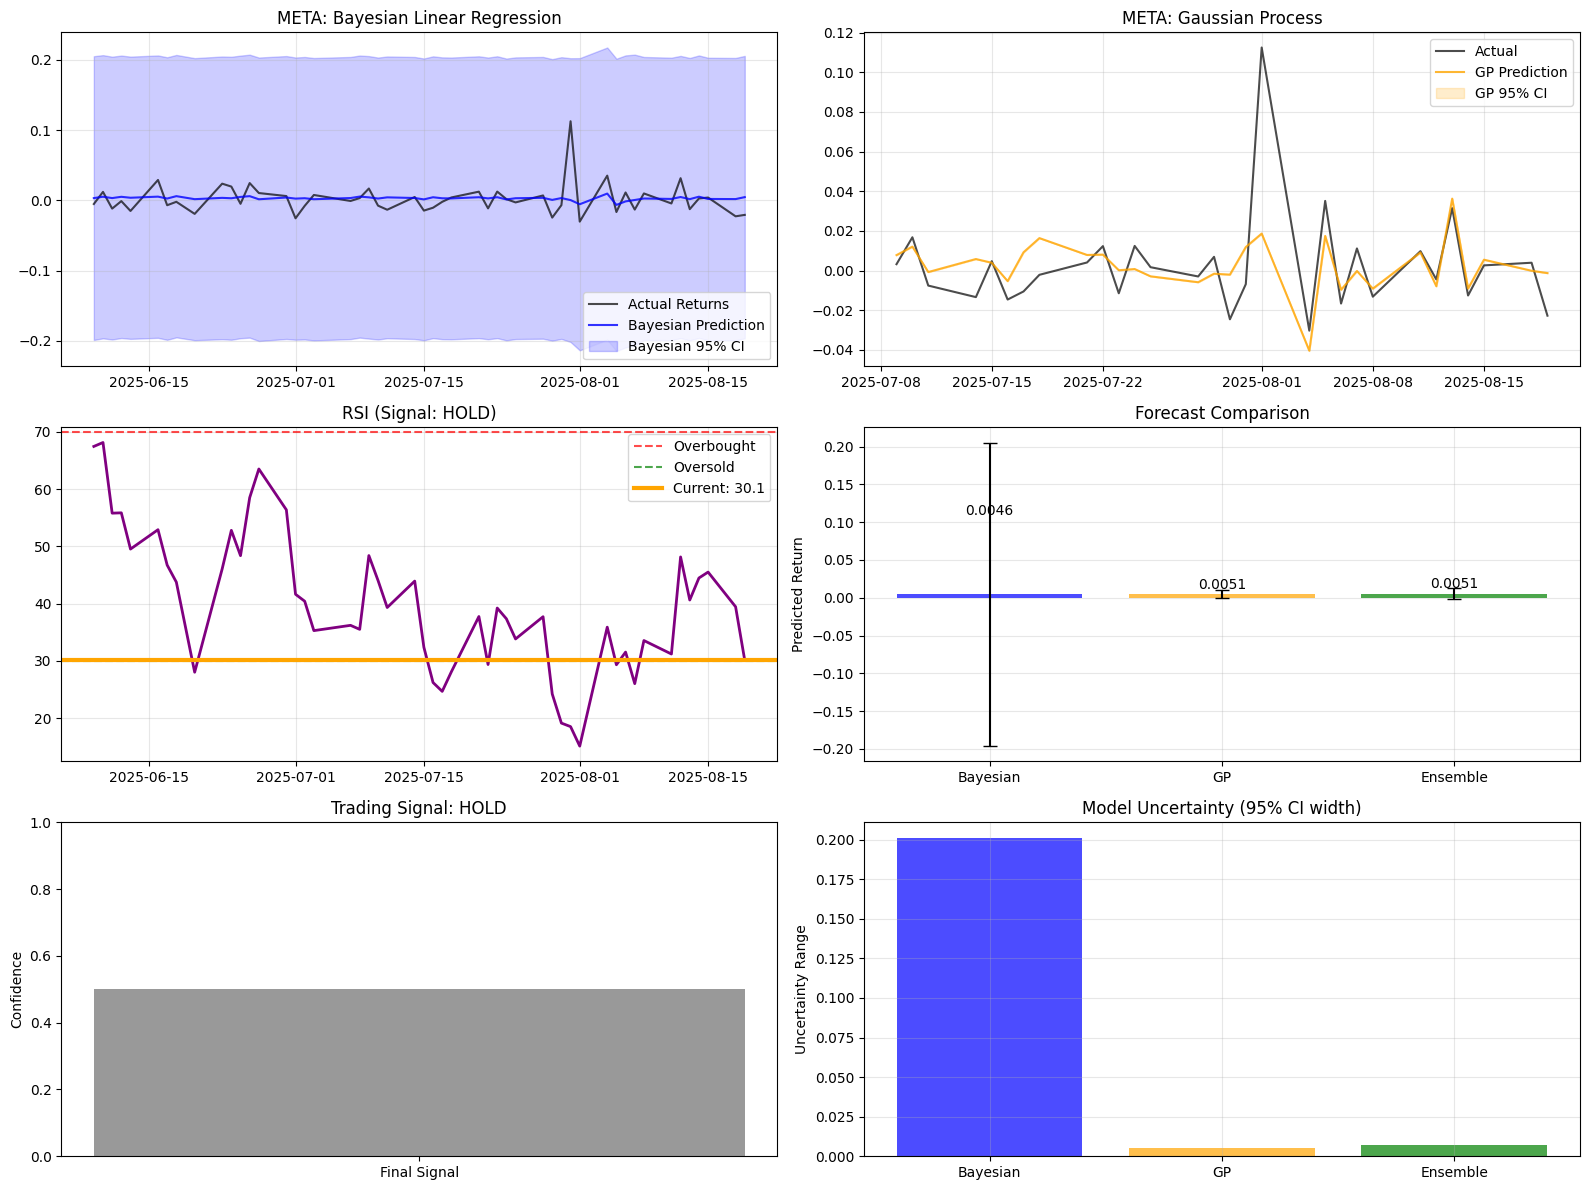

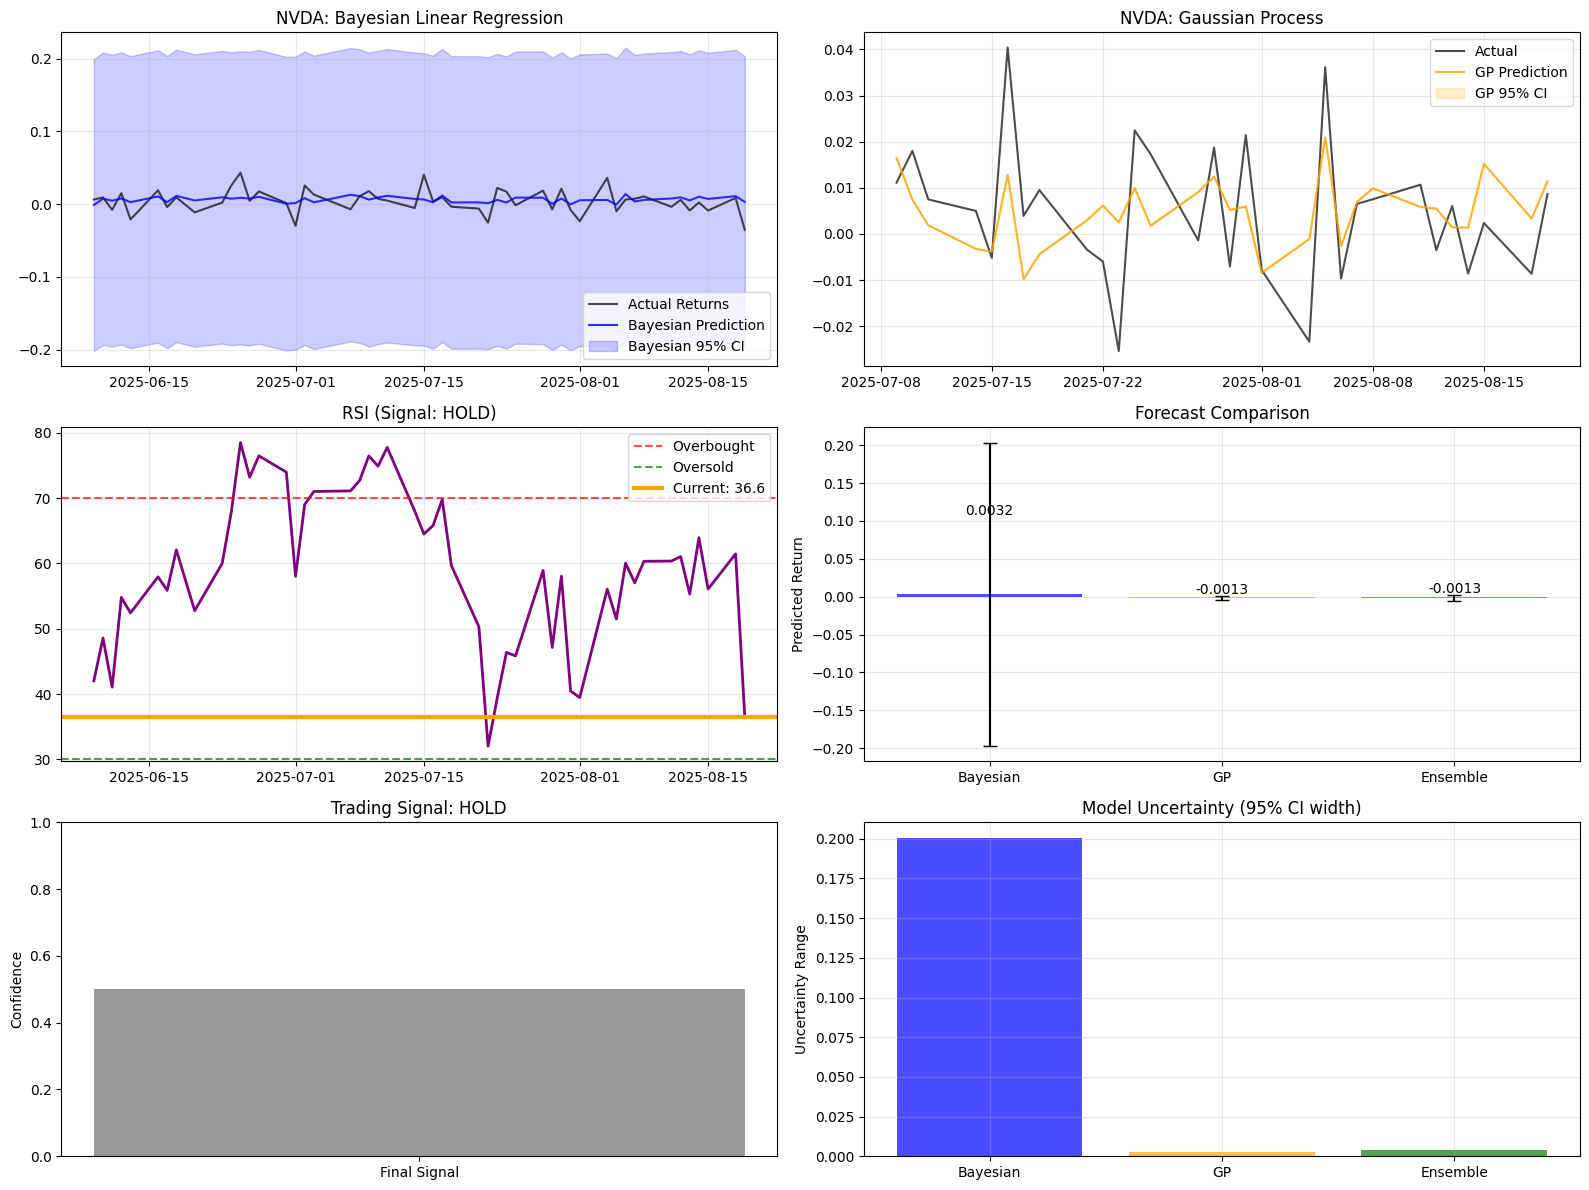

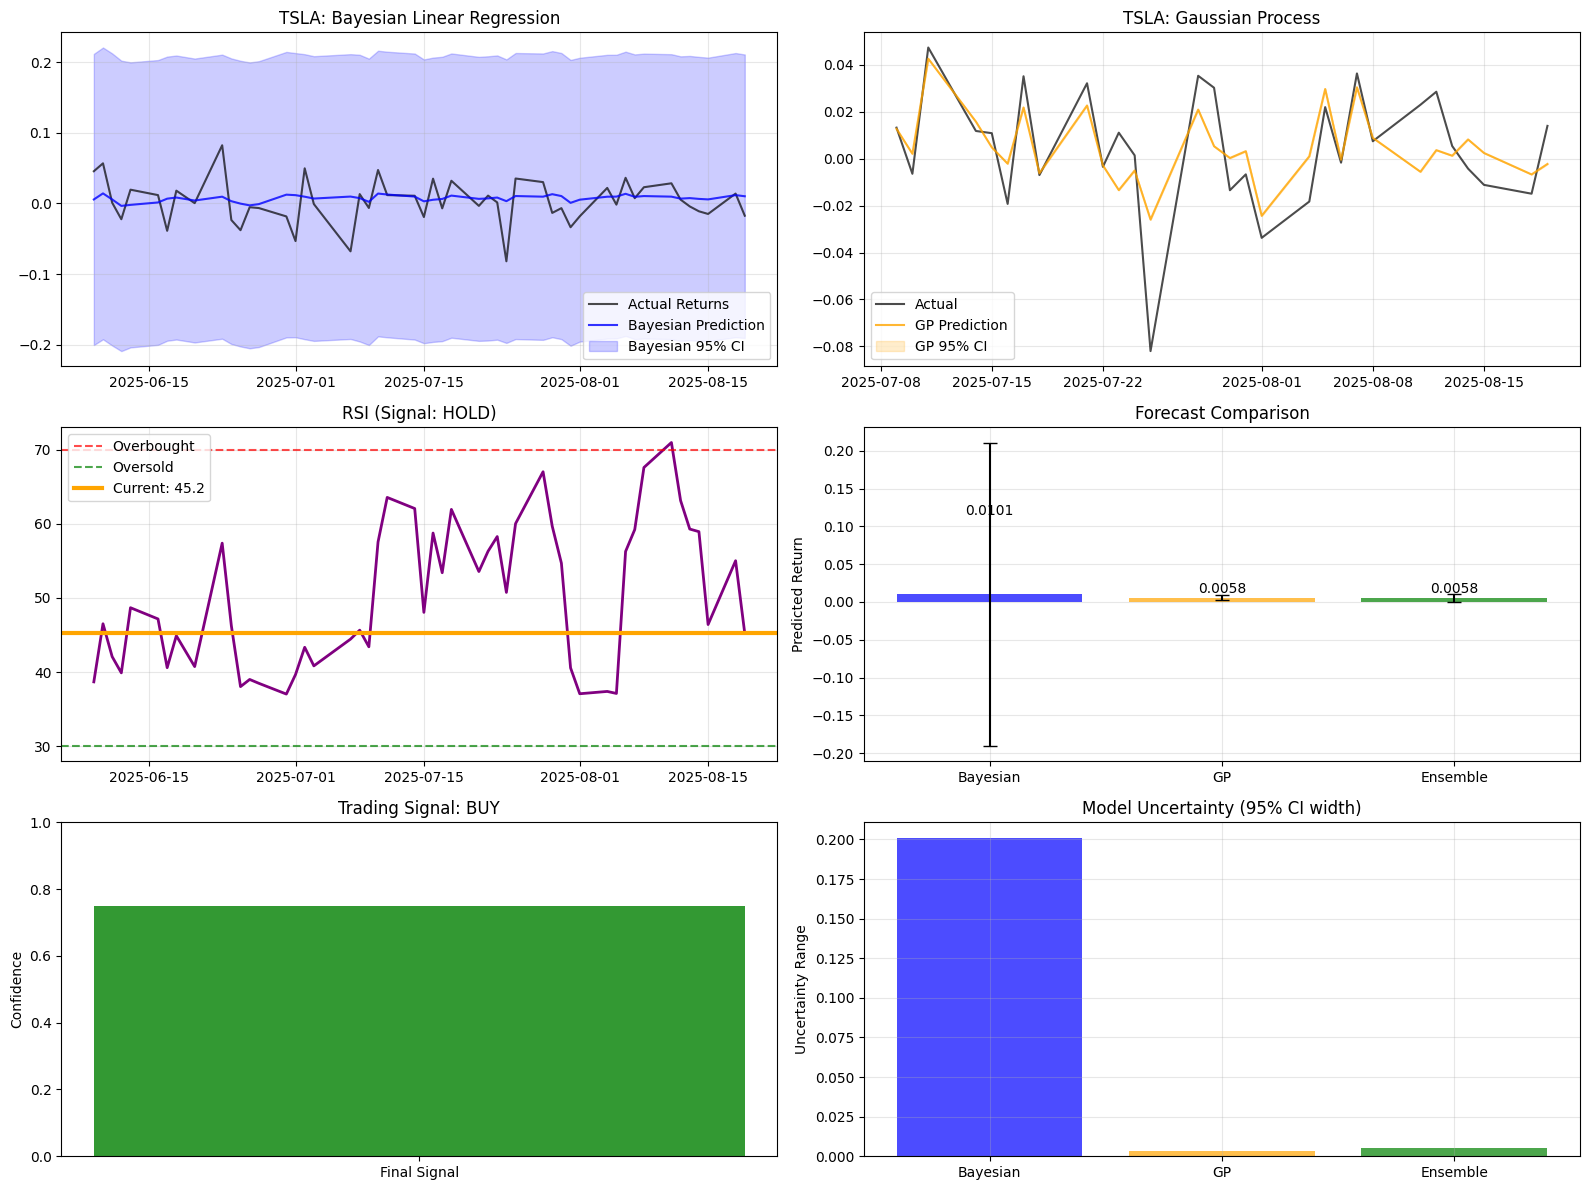

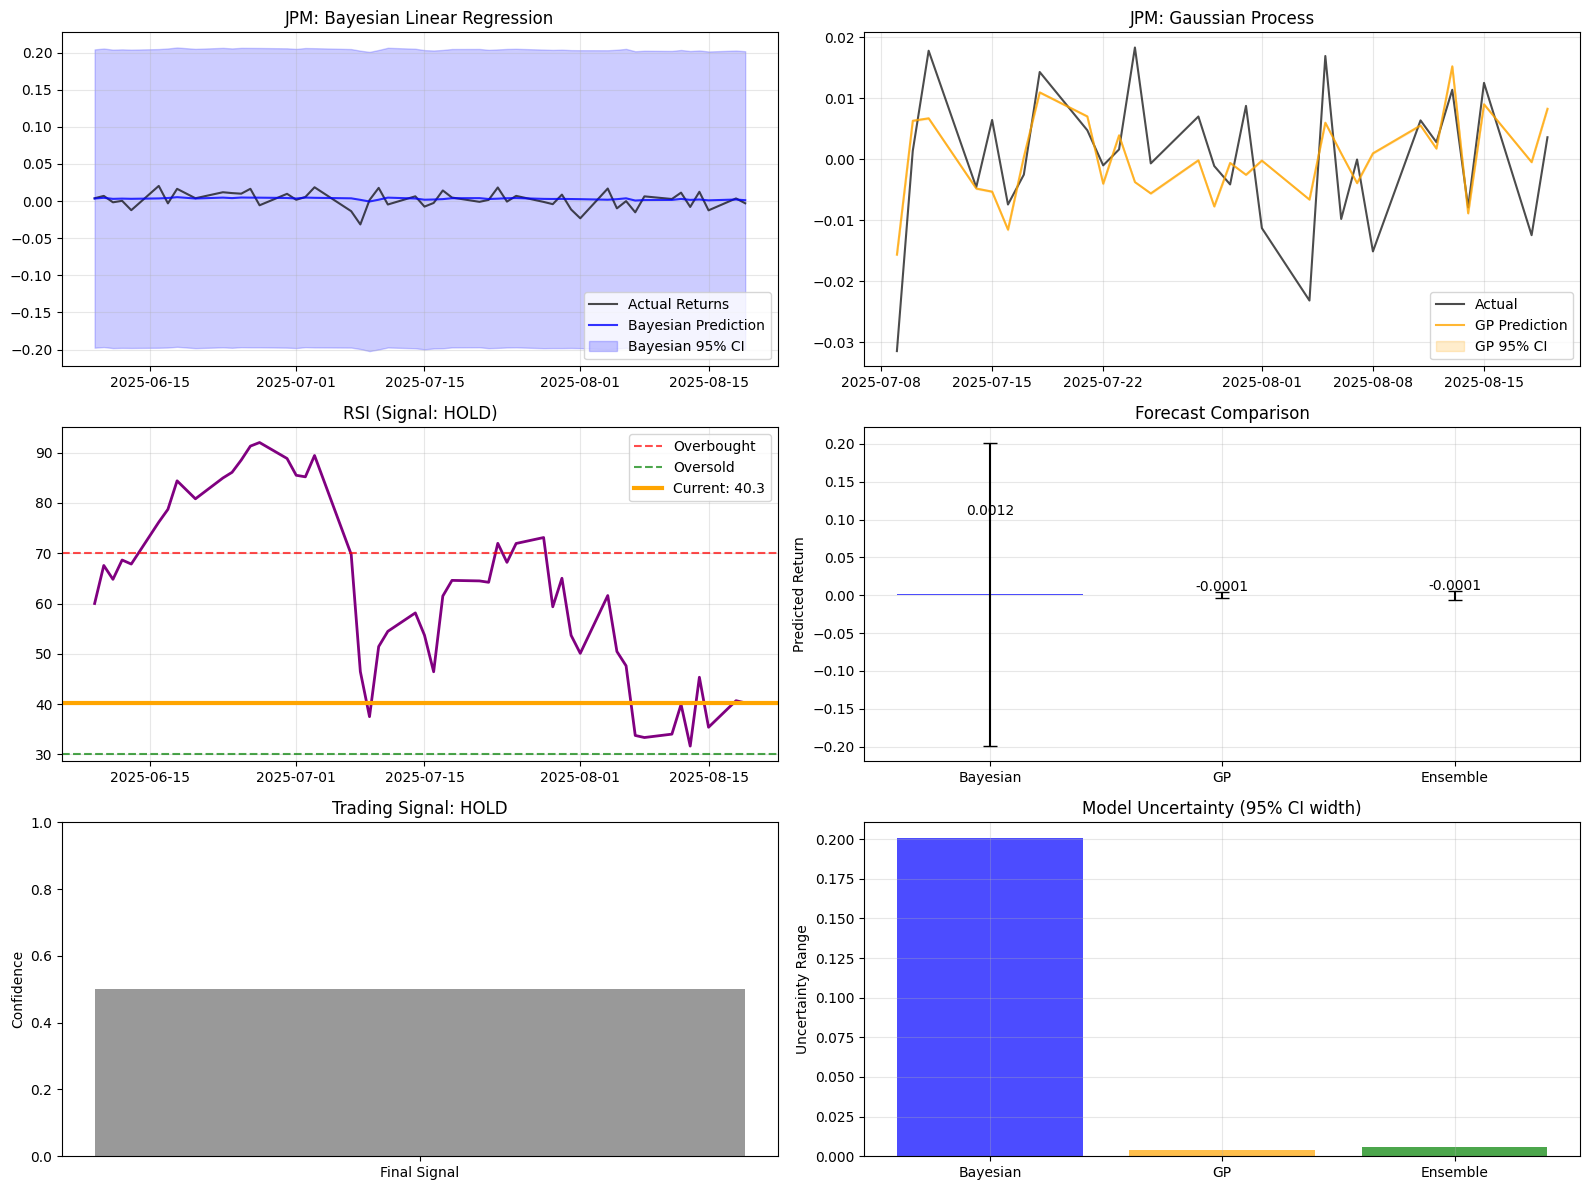

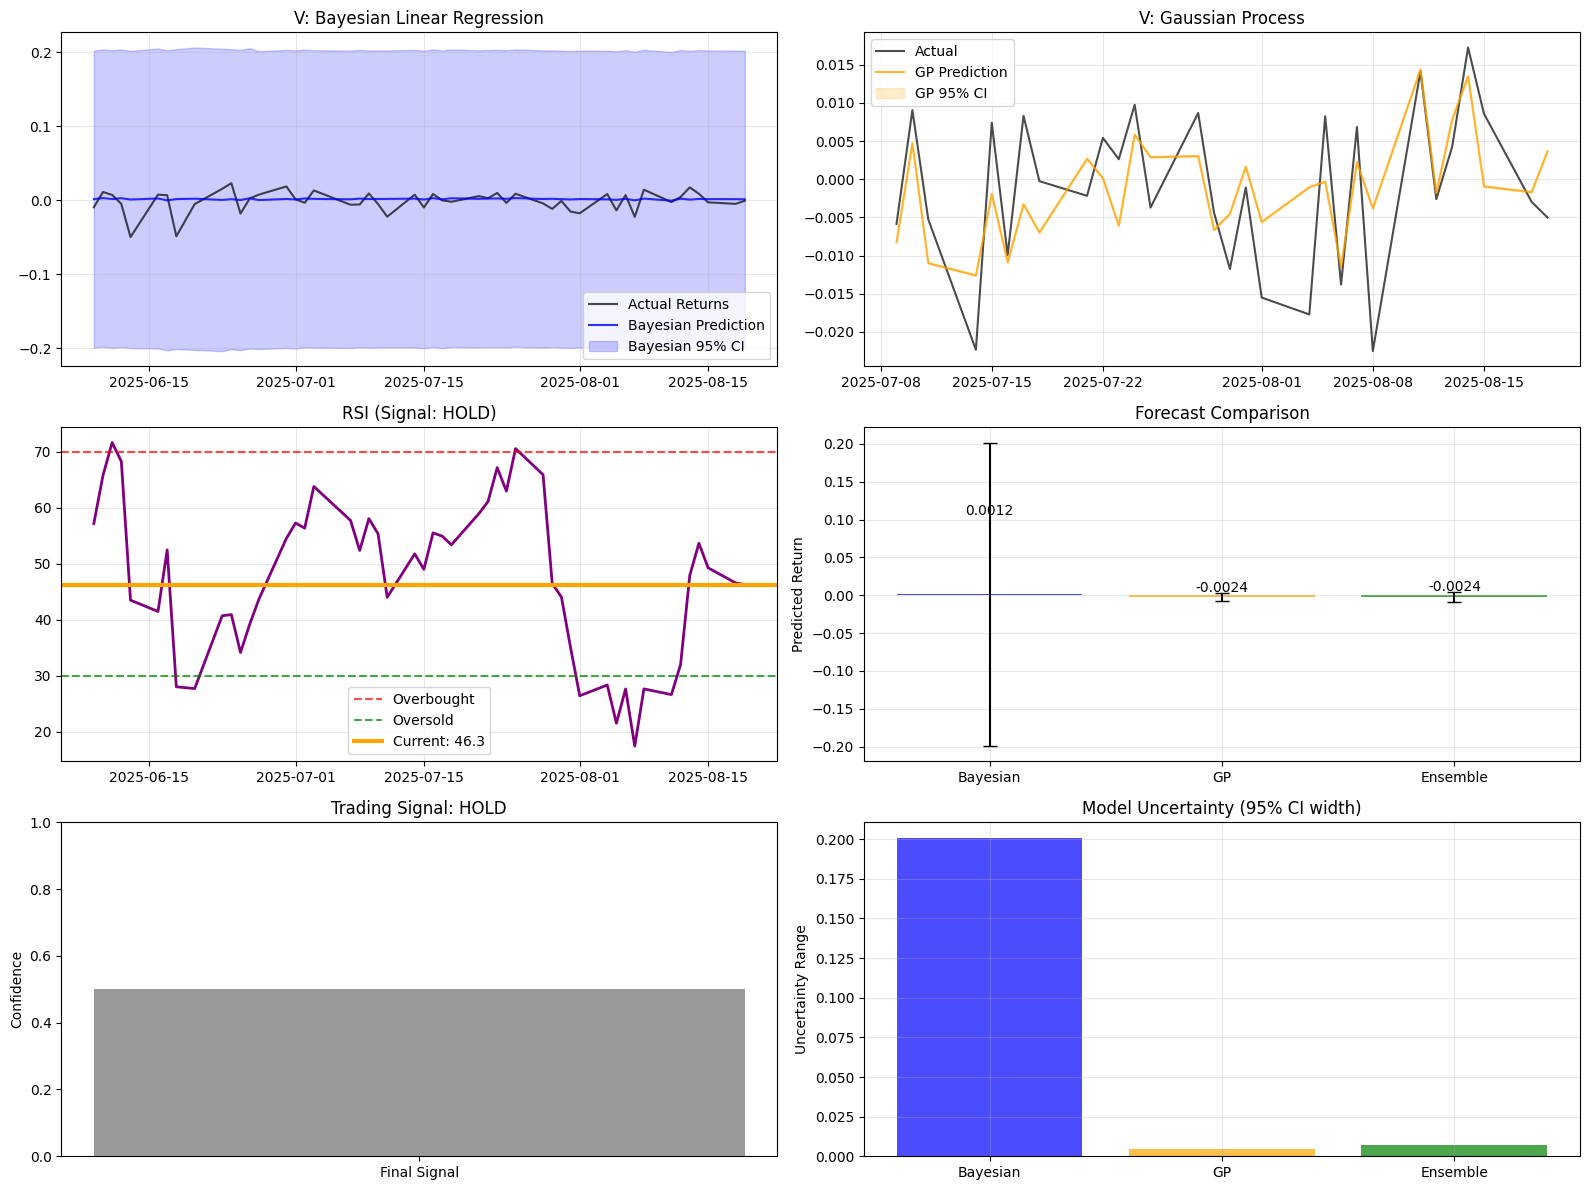

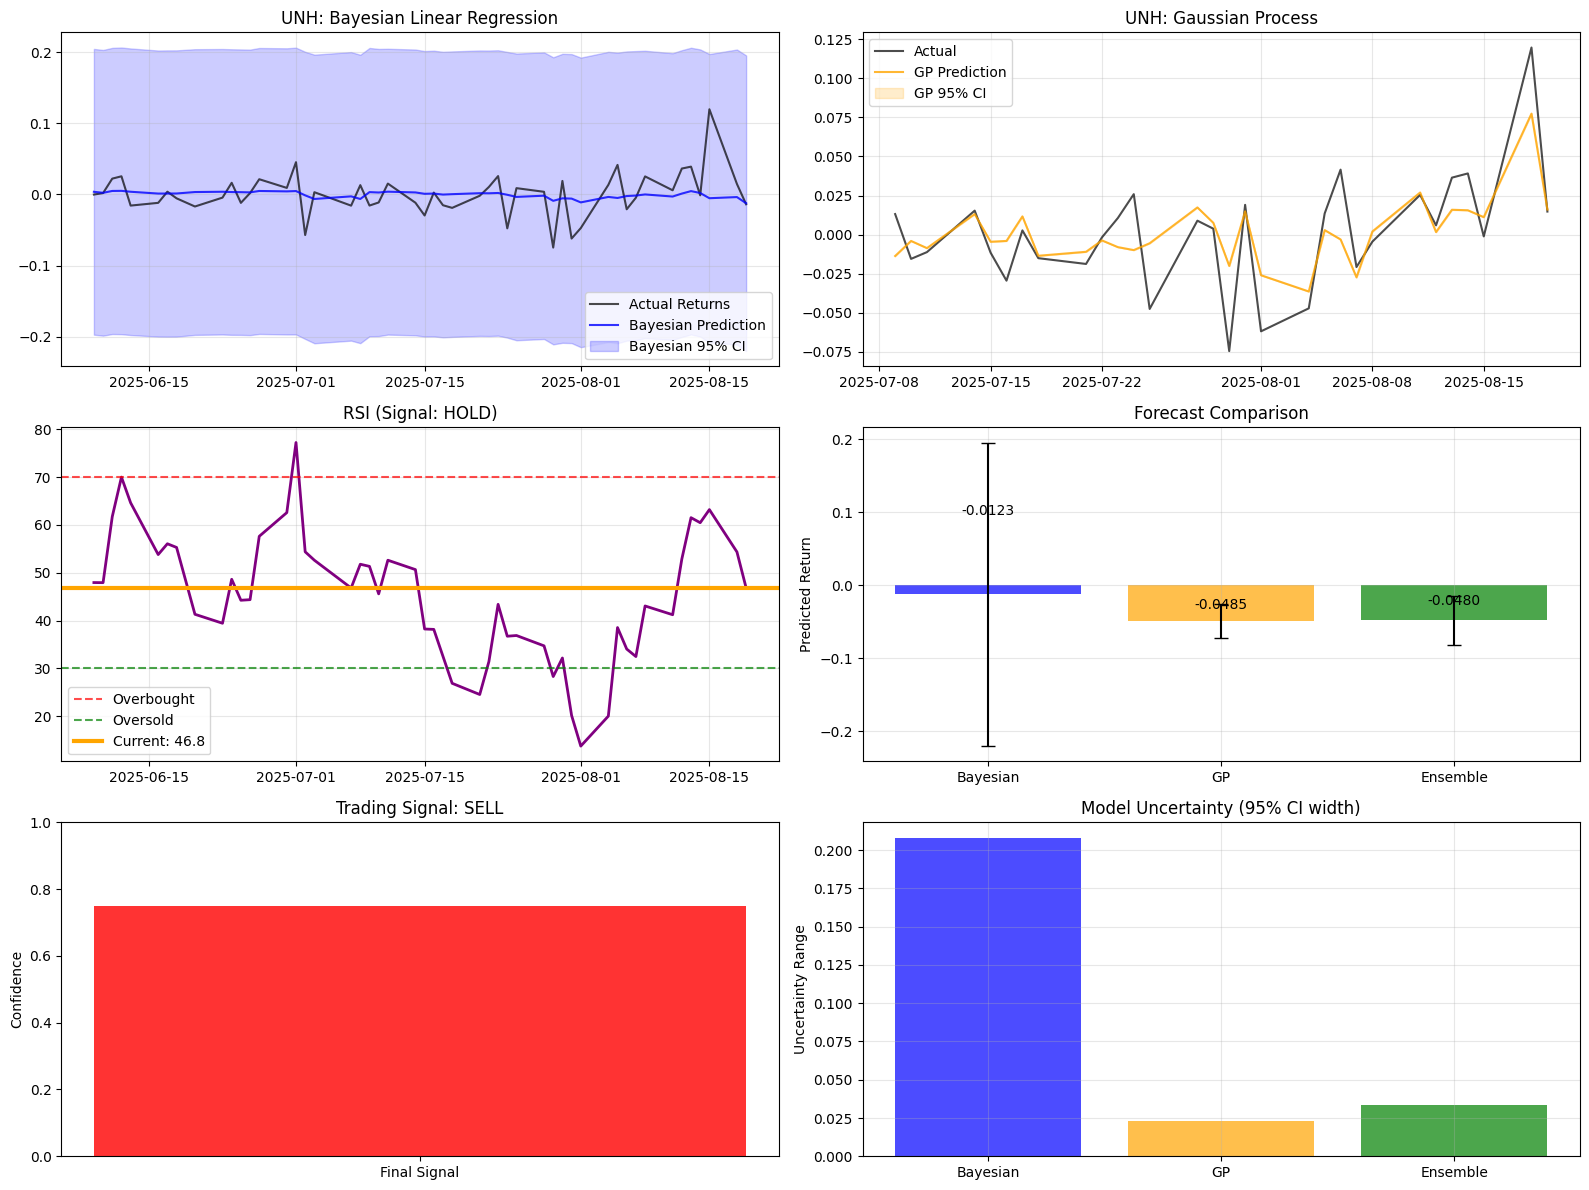

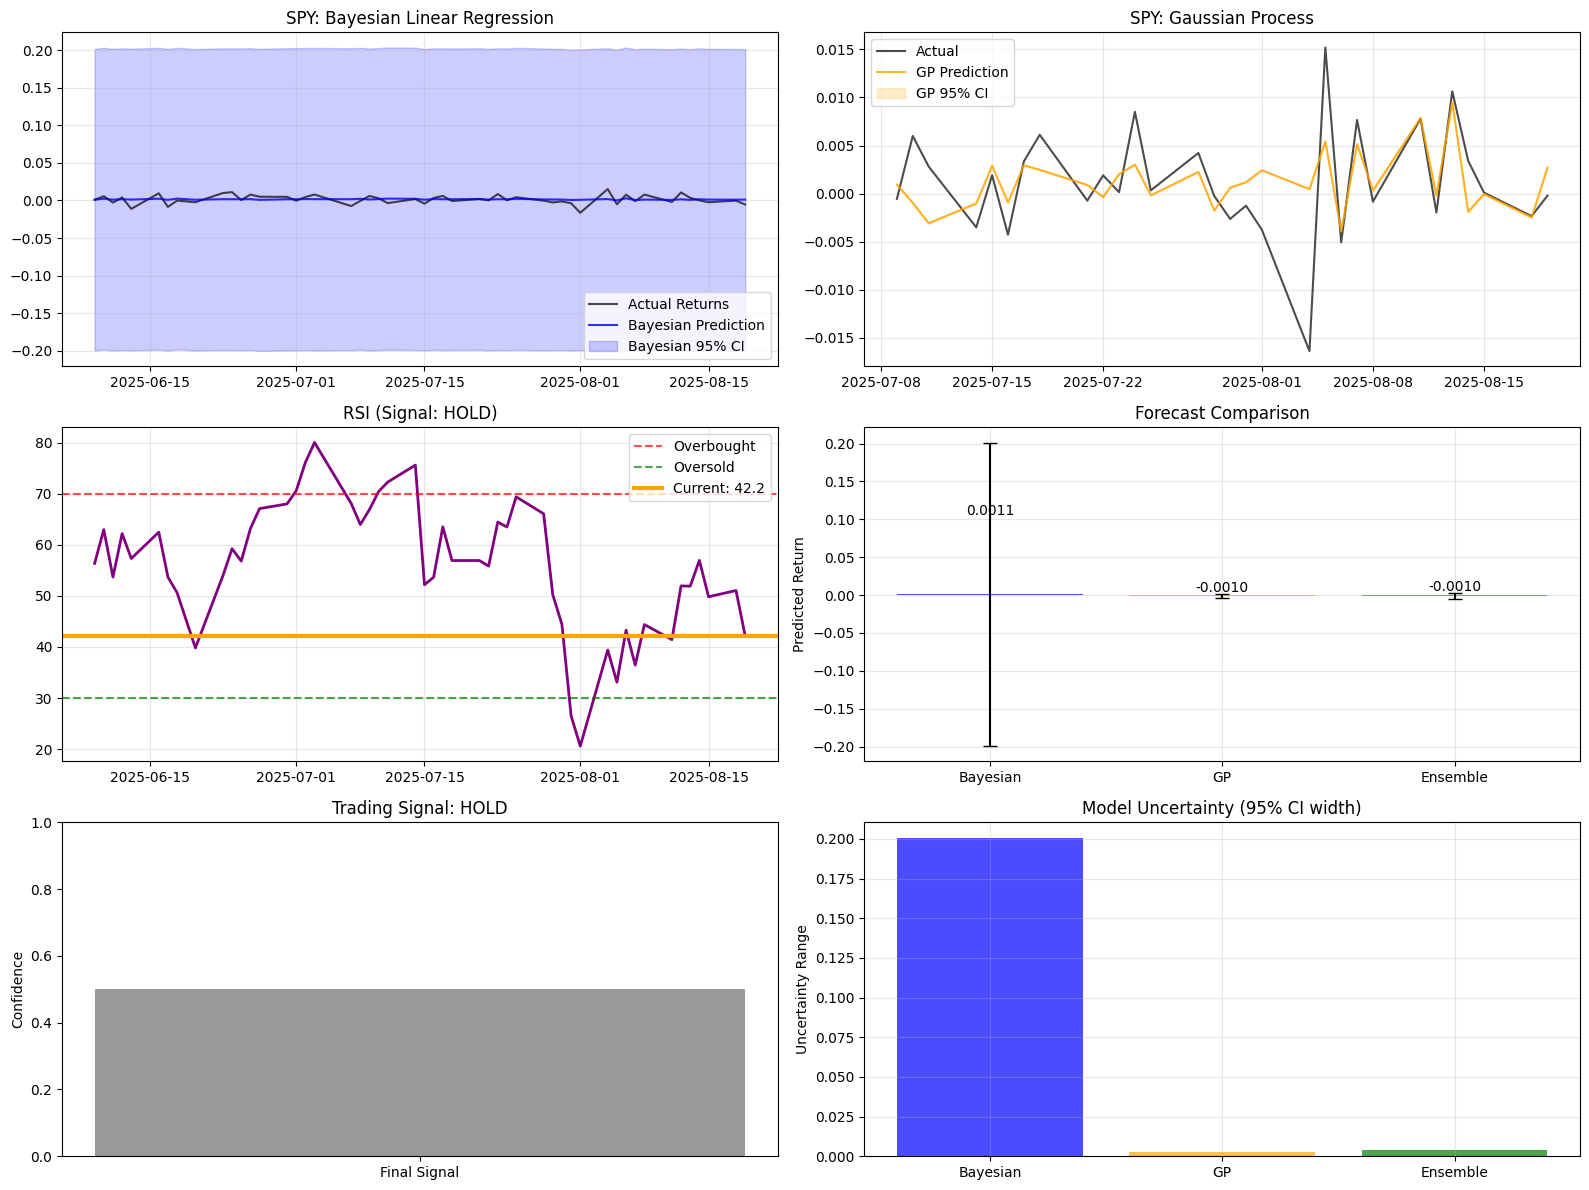

In [14]:
# ...existing code...
def summarize_universe(symbols, tp_pct=None, sl_pct=None, use_notional=None, notional_capital=None):
    prices = fetch_latest_prices(symbols)

    g = globals()
    tp_pct = tp_pct if tp_pct is not None else g.get("TP_PCT", 0.04)
    sl_pct = sl_pct if sl_pct is not None else g.get("SL_PCT", 0.02)
    use_notional = use_notional if use_notional is not None else g.get("USE_NOTIONAL", True)
    notional_capital = notional_capital if notional_capital is not None else g.get("NOTIONAL_CAPITAL", 100)

    rows = []
    for s in symbols:
        with suppress_output(True), suppress_plots(True):
            raw = unified_bayesian_gp_forecast(s)
        sig, conf = extract_signal_confidence(raw)
        last = prices.get(s)

        f_pct = std_pct = None
        if isinstance(raw, dict):
            ens = raw.get("ensemble") or {}
            try: f_pct = float(ens.get("forecast")) if ens.get("forecast") is not None else None
            except: pass
            try: std_pct = float(ens.get("std")) if ens.get("std") is not None else None
            except: pass

        z = p_up = None
        if isinstance(f_pct, (int, float)) and isinstance(std_pct, (int, float)) and std_pct > 0:
            z = f_pct / std_pct
            p_up = _normal_cdf(z)

        tp = sl = qty = None
        if isinstance(last, (int, float)):
            tp = round(last * (1 + tp_pct), 2)
            sl = round(last * (1 - sl_pct), 2)
            if use_notional:
                qty = notional_capital / last

        rows.append({
            "symbol": s,
            "last": last,
            "signal": (sig or "n/a").upper(),
            "confidence": conf,
            "forecast_pct": f_pct,
            "std_pct": std_pct,
            "z": z,
            "p_up": p_up,
            "tp": tp,
            "sl": sl,
            "sim_qty": qty
        })
    return pd.DataFrame(rows)

# Example: show a nicely formatted table
df = summarize_universe(UNIVERSE)
# ...existing code...

In [15]:
# ...existing code...
RUN_PREVIEW = False
if RUN_PREVIEW:
    for sym in UNIVERSE:
        print("="*60)
        try:
            preview_signal(sym)
        except Exception as e:
            print(f"[error] {sym}: {e}")
        time.sleep(0.3)
# ...existing code...

# ...existing code...
# Example: show a nicely formatted table
RUN_SUMMARY = False
if RUN_SUMMARY:
    df = summarize_universe(UNIVERSE)
# ...existing code...

def _fmt_pct(x):
    return None if pd.isna(x) else f"{x*100:.1f}%"

view = df.copy()
view["confidence"]   = view["confidence"].apply(lambda x: None if pd.isna(x) else f"{x:.0%}")
view["forecast_pct"] = view["forecast_pct"].apply(_fmt_pct)
view["std_pct"]      = view["std_pct"].apply(_fmt_pct)
view["p_up"]         = view["p_up"].apply(lambda x: None if pd.isna(x) else f"{x*100:.1f}%")

cols = ["symbol","last","signal","confidence","forecast_pct","std_pct","z","p_up","tp","sl","sim_qty"]
view = view[cols]
# Sort: BUYs first, then by confidence desc, then z-score desc
signal_rank = {"BUY": 0, "HOLD": 1, "SELL": 2, "N/A": 3}
view = view.assign(_rank=view["signal"].map(lambda s: signal_rank.get(str(s).upper(), 9)))
view = view.sort_values(by=["_rank","confidence","z"], ascending=[True, False, False]).drop(columns="_rank")
from tabulate import tabulate
print(tabulate(view.fillna(""), headers="keys", tablefmt="github", showindex=False))
# ...existing code...

| symbol   |    last | signal   | confidence   | forecast_pct   | std_pct   |          z | p_up   |     tp |     sl |   sim_qty |
|----------|---------|----------|--------------|----------------|-----------|------------|--------|--------|--------|-----------|
| TSLA     | 328.24  | BUY      | 75%          | 0.6%           | 0.3%      |  2.19188   | 98.6%  | 341.37 | 321.68 |  0.304655 |
| META     | 751.685 | HOLD     | 50%          | 0.5%           | 0.4%      |  1.38972   | 91.8%  | 781.75 | 736.65 |  0.133034 |
| MSFT     | 510.06  | HOLD     | 50%          | 0.3%           | 0.3%      |  1.15025   | 87.5%  | 530.46 | 499.86 |  0.196055 |
| JPM      | 290.65  | HOLD     | 50%          | -0.0%          | 0.3%      | -0.0293173 | 48.8%  | 302.28 | 284.84 |  0.344056 |
| GOOGL    | 201.64  | HOLD     | 50%          | -0.0%          | 0.2%      | -0.110866  | 45.6%  | 209.71 | 197.61 |  0.495933 |
| SPY      | 639.89  | HOLD     | 50%          | -0.1%          | 0.2%      | -0.472032  |

In [16]:
# ...existing code...
DRY_RUN = True
MIN_CONF = 0.70
MAX_ORDERS_PER_RUN = 20
USE_NOTIONAL = True
NOTIONAL_CAPITAL = 100
TP_PCT = 0.04
SL_PCT = 0.02

# Ensemble-based fallback thresholds (tuned)
ALT_SELECTION    = True
MIN_PROB_UP      = 0.62    # slightly stricter than 0.60
MIN_Z            = 0.25    # require at least modest edge
MIN_USD_MOVE     = 0.10    # require >= $0.10 expected move (last_price * forecast_pct)
DEBUG_SELECTION  = True

# If nothing passes strict rules, relax to get a small basket
RELAX_SELECTION  = True
TARGET_MIN_PICKS = 3
# ...existing code...

In [17]:
def get_signals_sequential(symbols):
    """
    Run signals sequentially (slower but more reliable for debugging)
    """
    out = {}
    for i, sym in enumerate(symbols):
        print(f"Processing {sym} ({i+1}/{len(symbols)})...")
        try:
            raw = unified_bayesian_gp_forecast(sym)
            sig, conf = extract_signal_confidence(raw)
            out[sym] = (sig, conf, raw)
            print(f"✓ {sym}: {sig} @ {conf}")
        except Exception as e:
            print(f"✗ {sym}: {e}")
    return out

# Use this instead in run_once():
#symbols = UNIVERSE
#signals = get_signals_sequential(symbols)

In [18]:
# Replace the run_once() call with this enhanced version that uses the adjusted thresholds

def run_once():
    """
    Orchestrates: fetch prices, get signals, filter BUYs, size, and submit bracket orders.
    Uses enhanced filtering with ensemble fallback and relaxed selection.
    """
    try: 
        clock = trading.get_clock()
        if not getattr(clock, "is_open", True):
            print("[note] Market appears closed; DAY orders will queue until open.")
    except Exception:
        pass

    symbols = UNIVERSE
    prices = fetch_latest_prices(symbols)
    signals = get_signals_sequential(symbols)

    # Filter buy candidates by confidence (with ensemble fallback)
    buys = []
    candidates_dbg = []  # for optional table/relax
    for s, tup in signals.items():
        if not tup:
            continue
        sig, conf, raw = tup
        if s not in prices:
            if DEBUG_SELECTION: print(f"[skip] {s}: no price")
            continue

        last = float(prices[s])
        selected = False
        chosen_conf = None
        why = None

        # Primary rule: explicit BUY with sufficient confidence
        if sig == "buy" and isinstance(conf, (int, float)) and conf >= MIN_CONF:
            selected = True
            chosen_conf = float(conf)
            why = "signal"

        # Fallback rule: ensemble shows positive, meaningful edge
        f_pct = std_pct = z = p_up = usd_move = None
        if not selected and ALT_SELECTION and isinstance(raw, dict):
            ens = (raw.get("ensemble") or {})
            try: f_pct = float(ens.get("forecast")) if ens.get("forecast") is not None else None
            except: f_pct = None
            try: std_pct = float(ens.get("std")) if ens.get("std") is not None else None
            except: std_pct = None

            if isinstance(f_pct, (int, float)) and isinstance(std_pct, (int, float)) and std_pct > 0:
                z = f_pct / std_pct
                p_up = 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))
                usd_move = last * f_pct if isinstance(last, (int, float)) else None

                if (
                    f_pct is not None and f_pct > 0
                    and p_up is not None and p_up >= MIN_PROB_UP
                    and z is not None and z >= MIN_Z
                    and usd_move is not None and abs(usd_move) >= MIN_USD_MOVE
                ):
                    selected = True
                    chosen_conf = float(p_up)  # rank by upside probability
                    why = "ensemble"

        # collect row for debugging/relax
        candidates_dbg.append({
            "symbol": s, "last": last, "sig": sig, "conf": conf,
            "f": f_pct, "std": std_pct, "z": z, "p_up": p_up, "usd_move": usd_move
        })

        if selected:
            buys.append((s, last, chosen_conf, why))
        elif DEBUG_SELECTION:
            print(f"[skip] {s}: sig={sig}, conf={conf}, f={f_pct}, std={std_pct}, z={z}, p_up={p_up}, $move={usd_move}")

    # Relax if nothing passed strict filters
    if not buys and RELAX_SELECTION:
        # keep positives with any edge: f>0, std>0, z>0
        pool = [r for r in candidates_dbg if isinstance(r.get("f"), (int,float)) and r["f"] > 0
                                      and isinstance(r.get("std"), (int,float)) and r["std"] > 0
                                      and (r.get("z") or 0) > 0]
        # score by p_up then z then $ move
        pool.sort(key=lambda r: (r.get("p_up") or 0.0, r.get("z") or 0.0, r.get("usd_move") or 0.0), reverse=True)
        for r in pool[:TARGET_MIN_PICKS]:
            buys.append((r["symbol"], r["last"], float(r.get("p_up") or 0.0), "relaxed"))

        if DEBUG_SELECTION:
            picked = [b[0] for b in buys]
            print(f"[relax] selected top {len(buys)} by p_up: {picked}")

    # Rank and cap
    buys.sort(key=lambda x: x[2], reverse=True)
    if not buys:
        print("No BUY candidates.")
        return

    buys = buys[:MAX_ORDERS_PER_RUN]

    # Sizing
    if USE_NOTIONAL:
        per_symbol_dollars = NOTIONAL_CAPITAL / max(1, len(buys))
    else:
        acct = trading.get_account()
        bp = float(getattr(acct, "buying_power", 0.0))
        per_symbol_dollars = 0.95 * bp / max(1, len(buys))

    plan = []
    for sym, px, conf_eff, reason in buys:
        if px <= 0:
            continue
        if has_open_order(sym, OrderSide.BUY):
            print(f"[skip] {sym} has open BUY order.")
            continue
        qty = max(1, int(per_symbol_dollars // px))
        if qty <= 0:
            continue
        tp = round(px * (1 + TP_PCT), 2)
        sl = round(px * (1 - SL_PCT), 2)
        plan.append((sym, px, qty, conf_eff, tp, sl, reason))

    if not plan:
        print("Nothing to place after sizing/open-order checks.")
        return

    # Preview table
    from tabulate import tabulate
    print(tabulate(
        [(s, f"${px:.2f}", qty, f"{conf:.0%}", r, f"${tp:.2f}", f"${sl:.2f}") for s, px, qty, conf, tp, sl, r in plan],
        headers=["Symbol", "Price", "Qty", "Rank", "ChosenBy", "TP", "SL"]
    ))

    results = []
    for sym, px, qty, conf, tp, sl, _ in plan:
        order = MarketOrderRequest(
            symbol=sym, qty=qty, side=OrderSide.BUY,
            time_in_force=TimeInForce.DAY, order_class=OrderClass.BRACKET,
            take_profit=TakeProfitRequest(limit_price=tp),
            stop_loss=StopLossRequest(stop_price=sl),
        )
        if DRY_RUN:
            print(f"[DRY_RUN] {sym}: qty={qty} tp={tp} sl={sl}")
            results.append((sym, "DRY_RUN"))
            continue
        try:
            res = trading.submit_order(order)
            oid = getattr(res, "id", None) or getattr(res, "client_order_id", None)
            print(f"[submitted] {sym} qty={qty} tp={tp} sl={sl} id={oid}")
            results.append((sym, oid))
            time.sleep(0.25)
        except APIError as e:
            print(f"[submit error] {sym}: {e}")
        except Exception as e:
            print(f"[unknown error] {sym}: {e}")

    return results

In [19]:
# Adjust thresholds
MIN_CONF = 0.65
MIN_PROB_UP = 0.60
MIN_Z = 0.20
MIN_USD_MOVE = 0.05
TARGET_MIN_PICKS = 5
DEBUG_SELECTION = True

[note] Market appears closed; DAY orders will queue until open.
Processing AAPL (1/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for AAPL...
🟠 Running Gaussian Process for AAPL...


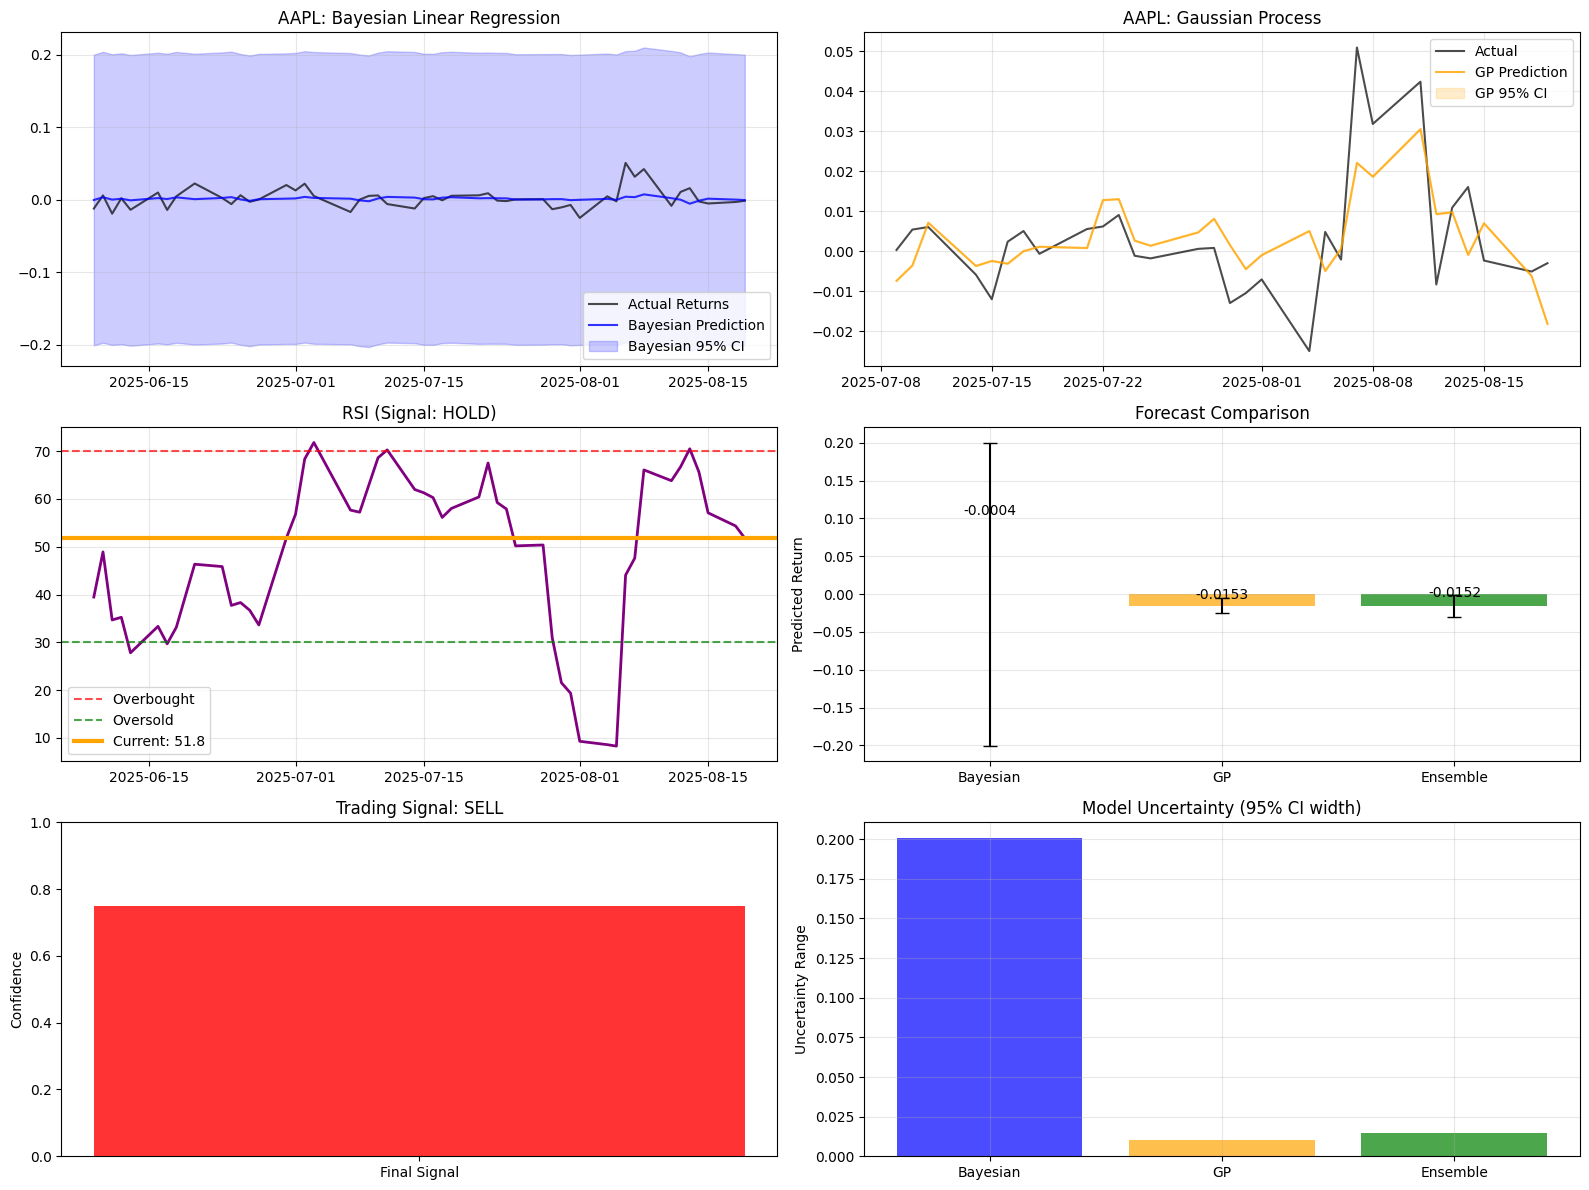


📊 AAPL - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: -0.0004 ± 0.2006
🟠 GP Forecast:       -0.0153 ± 0.0102
🟢 Ensemble Forecast: -0.0152 ± 0.0146
📈 RSI Signal:        HOLD (RSI: 51.8)
🎯 Final Signal:      SELL (Confidence: 75.0%)
💰 Recommendation:    SELL
✓ AAPL: sell @ 0.75
Processing MSFT (2/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for MSFT...
🟠 Running Gaussian Process for MSFT...


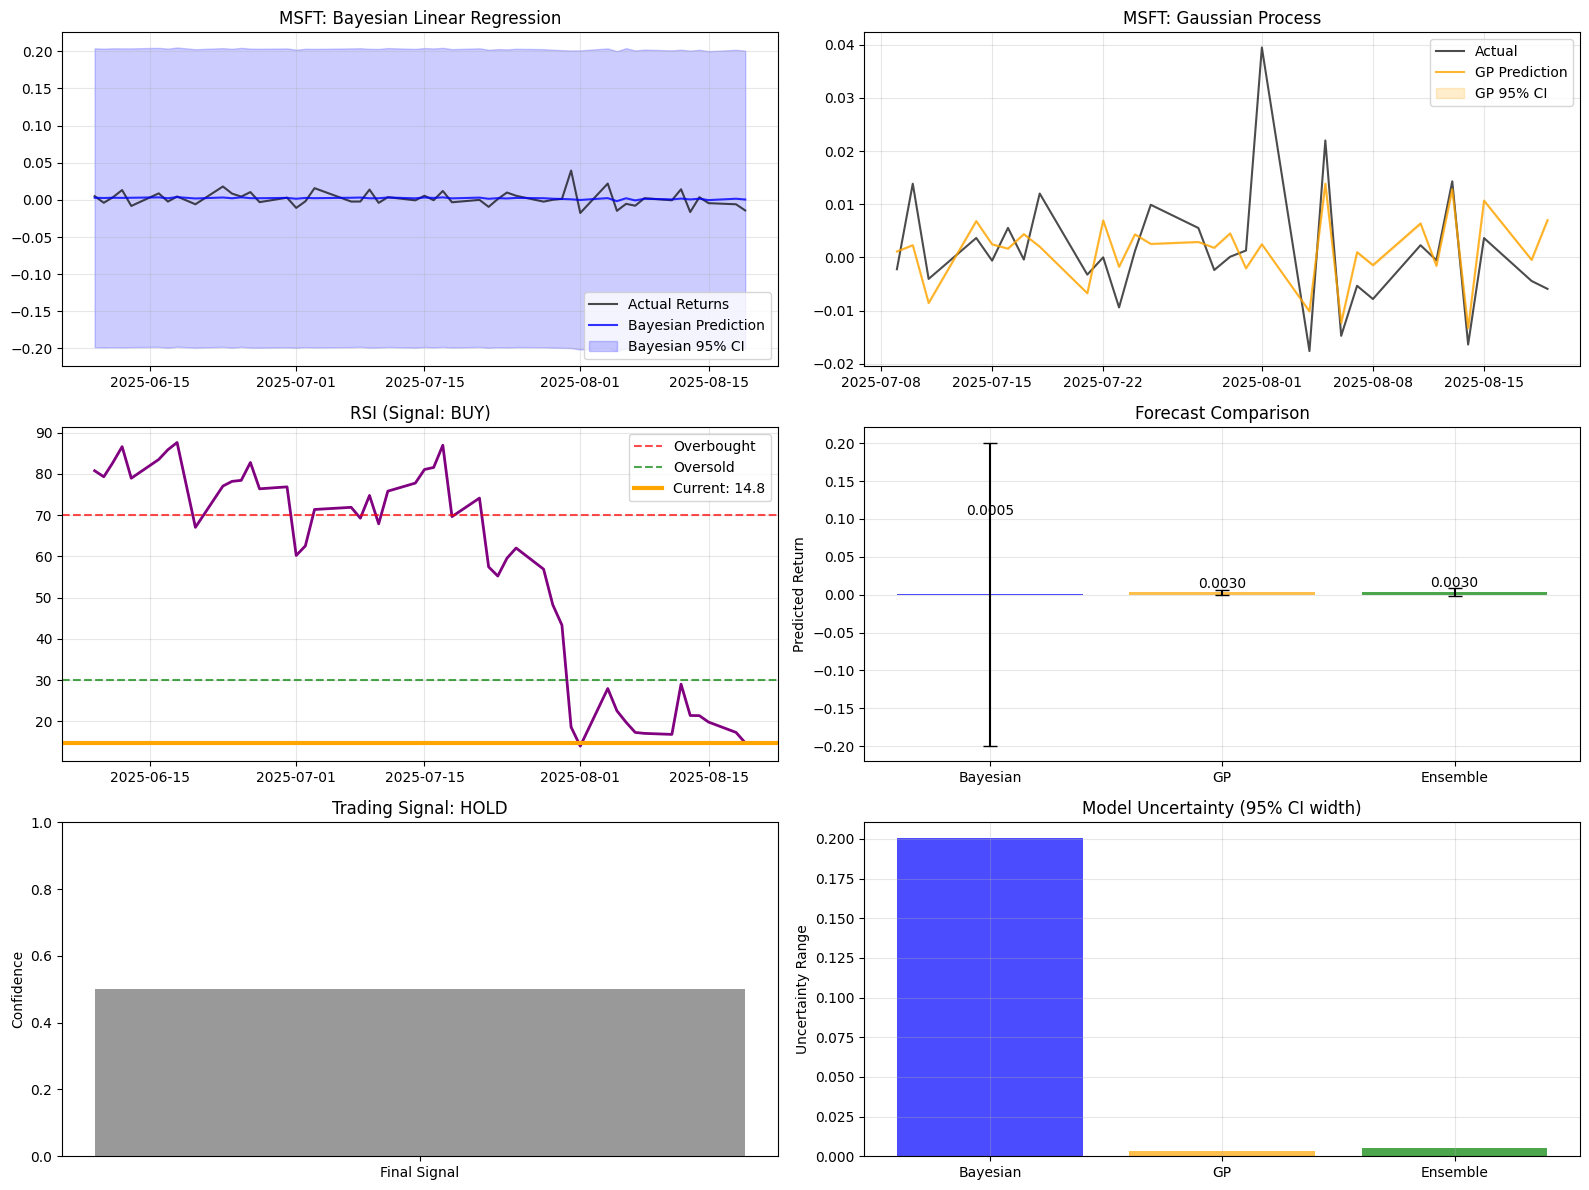


📊 MSFT - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0005 ± 0.2004
🟠 GP Forecast:       0.0030 ± 0.0034
🟢 Ensemble Forecast: 0.0030 ± 0.0053
📈 RSI Signal:        BUY (RSI: 14.8)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ MSFT: hold @ 0.5
Processing AMZN (3/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for AMZN...
🟠 Running Gaussian Process for AMZN...


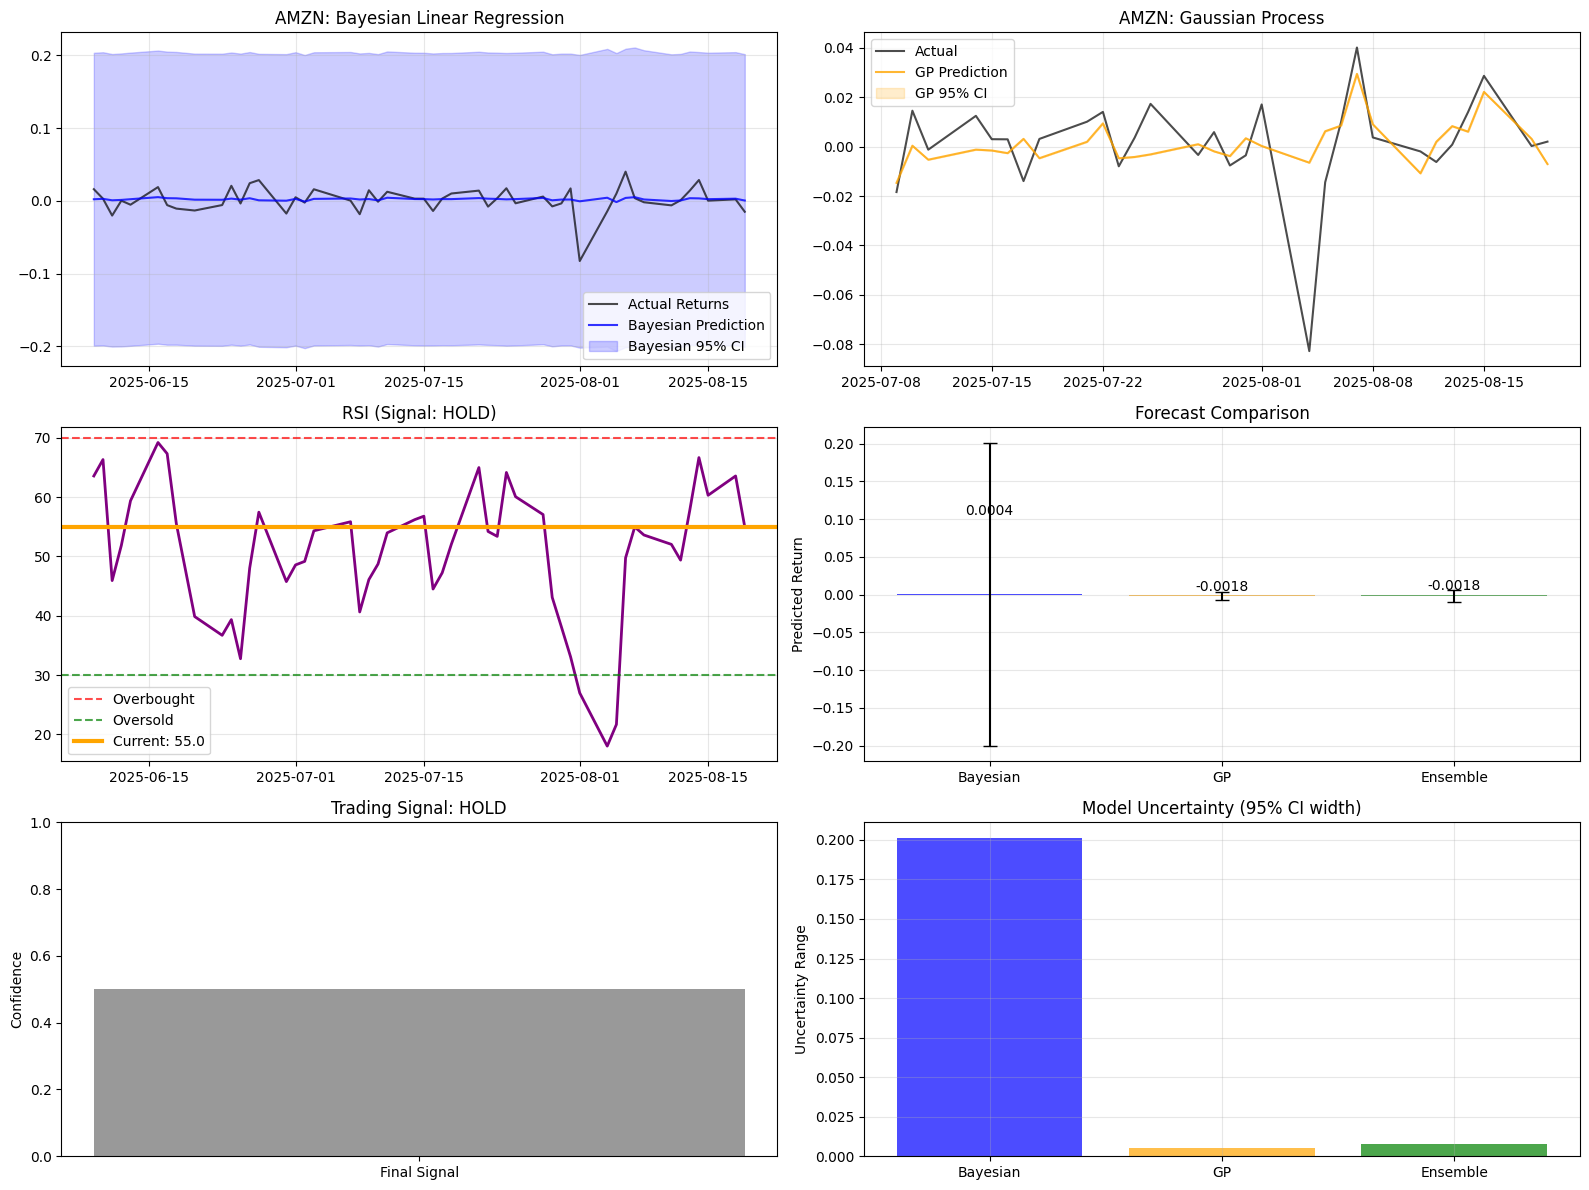


📊 AMZN - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0004 ± 0.2010
🟠 GP Forecast:       -0.0018 ± 0.0052
🟢 Ensemble Forecast: -0.0018 ± 0.0077
📈 RSI Signal:        HOLD (RSI: 55.0)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ AMZN: hold @ 0.5
Processing GOOGL (4/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for GOOGL...
🟠 Running Gaussian Process for GOOGL...


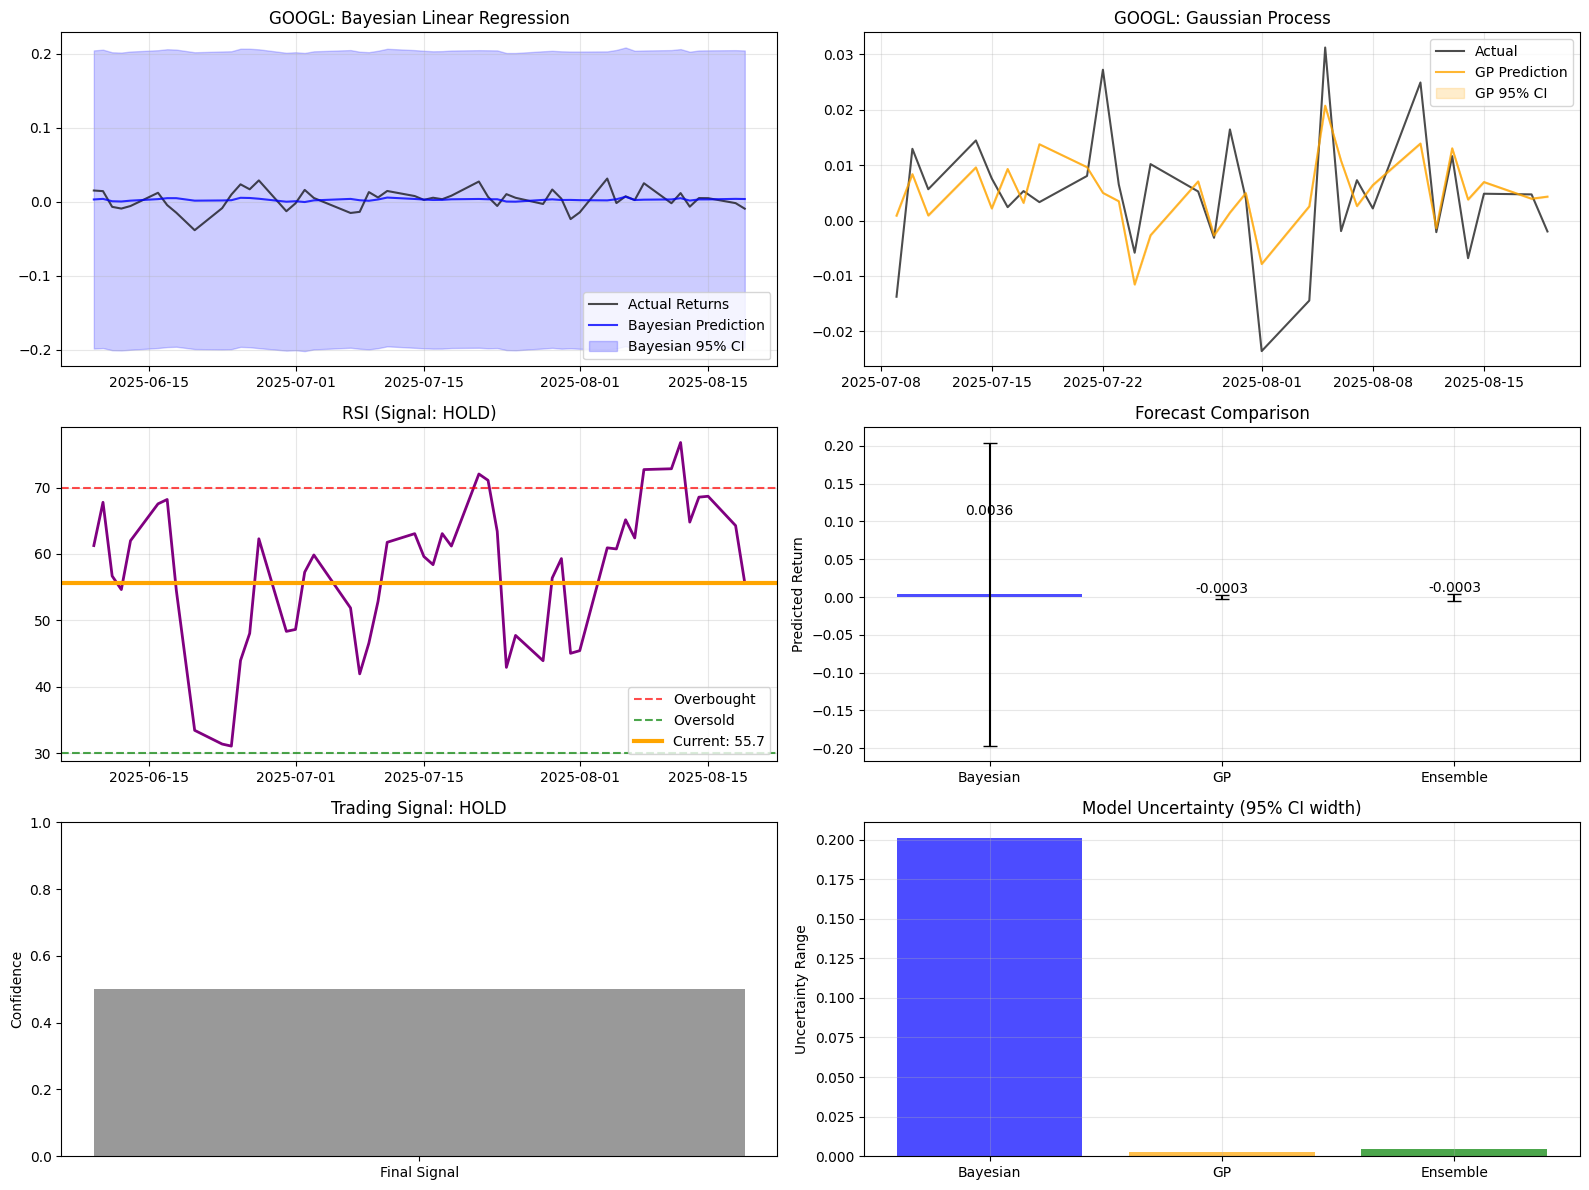

[*********************100%***********************]  1 of 1 completed


📊 GOOGL - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0036 ± 0.2008
🟠 GP Forecast:       -0.0003 ± 0.0030
🟢 Ensemble Forecast: -0.0003 ± 0.0047
📈 RSI Signal:        HOLD (RSI: 55.7)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ GOOGL: hold @ 0.5
Processing META (5/11)...



🔵 Running Bayesian Linear Regression for META...
🟠 Running Gaussian Process for META...


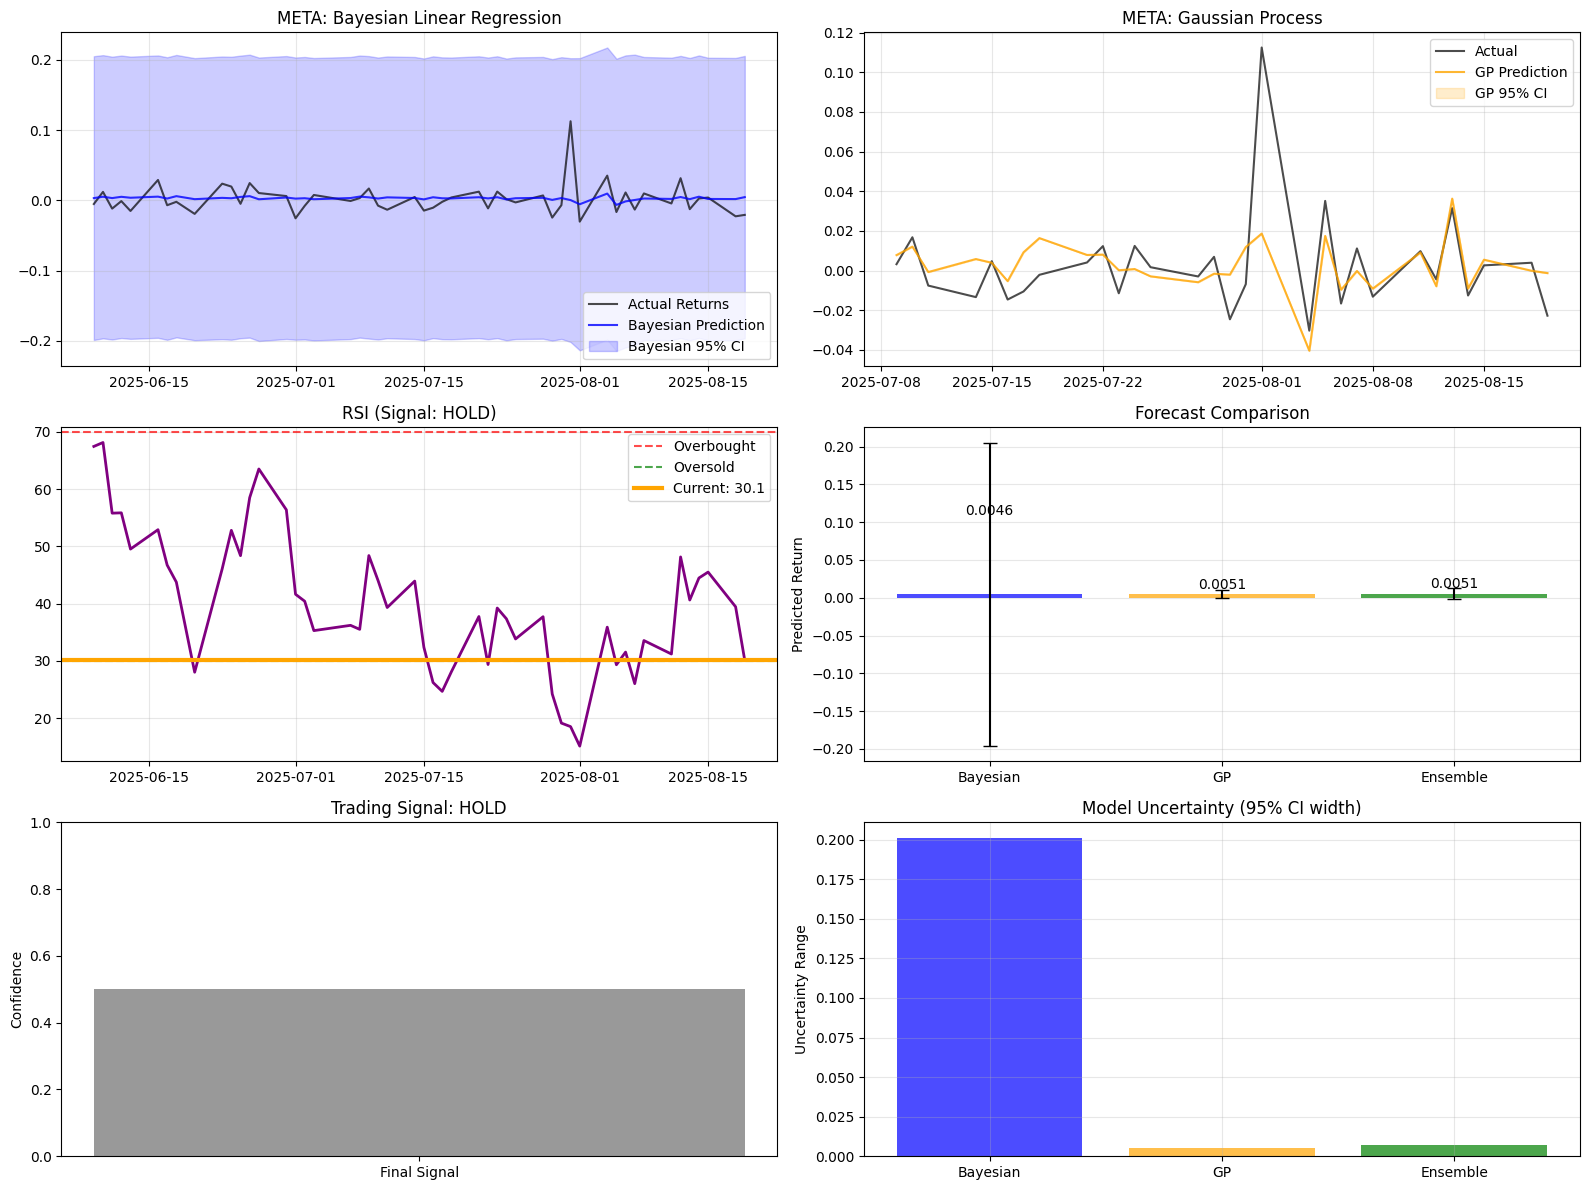


📊 META - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0046 ± 0.2009
🟠 GP Forecast:       0.0051 ± 0.0050
🟢 Ensemble Forecast: 0.0051 ± 0.0073
📈 RSI Signal:        HOLD (RSI: 30.1)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ META: hold @ 0.5
Processing NVDA (6/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for NVDA...
🟠 Running Gaussian Process for NVDA...


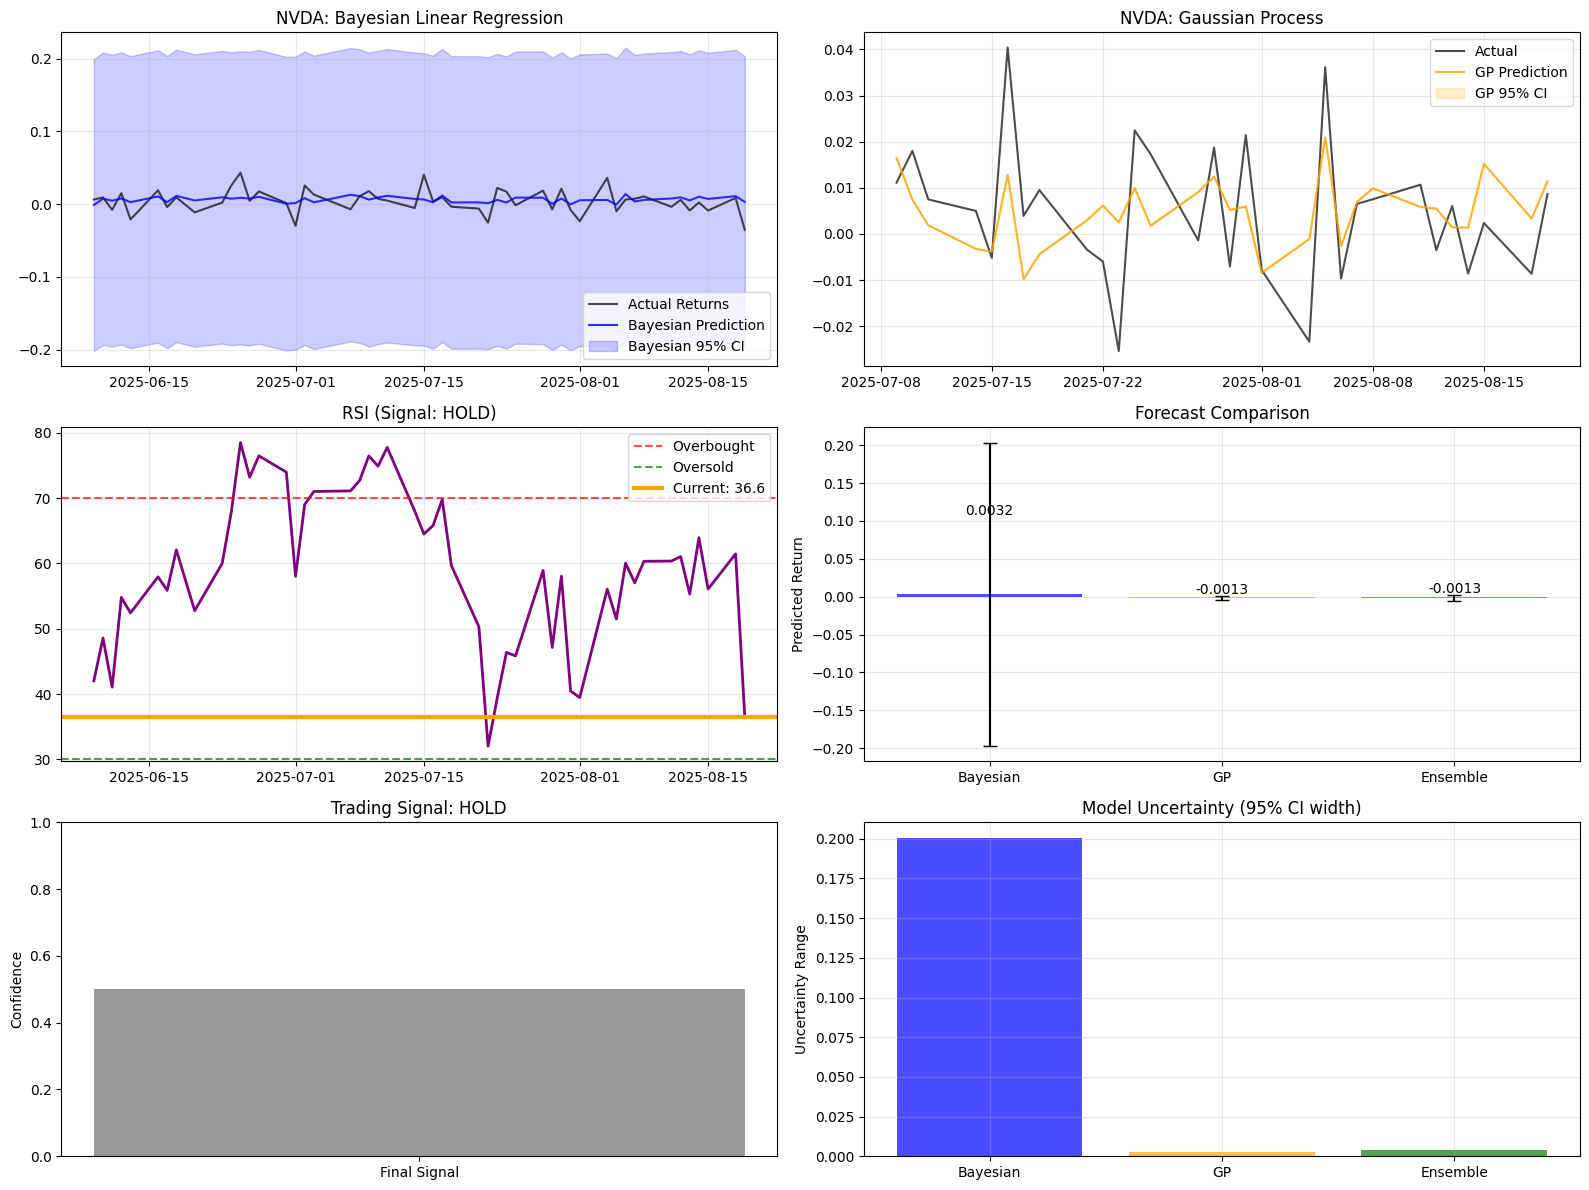


📊 NVDA - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0032 ± 0.2003
🟠 GP Forecast:       -0.0013 ± 0.0026
🟢 Ensemble Forecast: -0.0013 ± 0.0042
📈 RSI Signal:        HOLD (RSI: 36.6)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ NVDA: hold @ 0.5
Processing TSLA (7/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for TSLA...
🟠 Running Gaussian Process for TSLA...


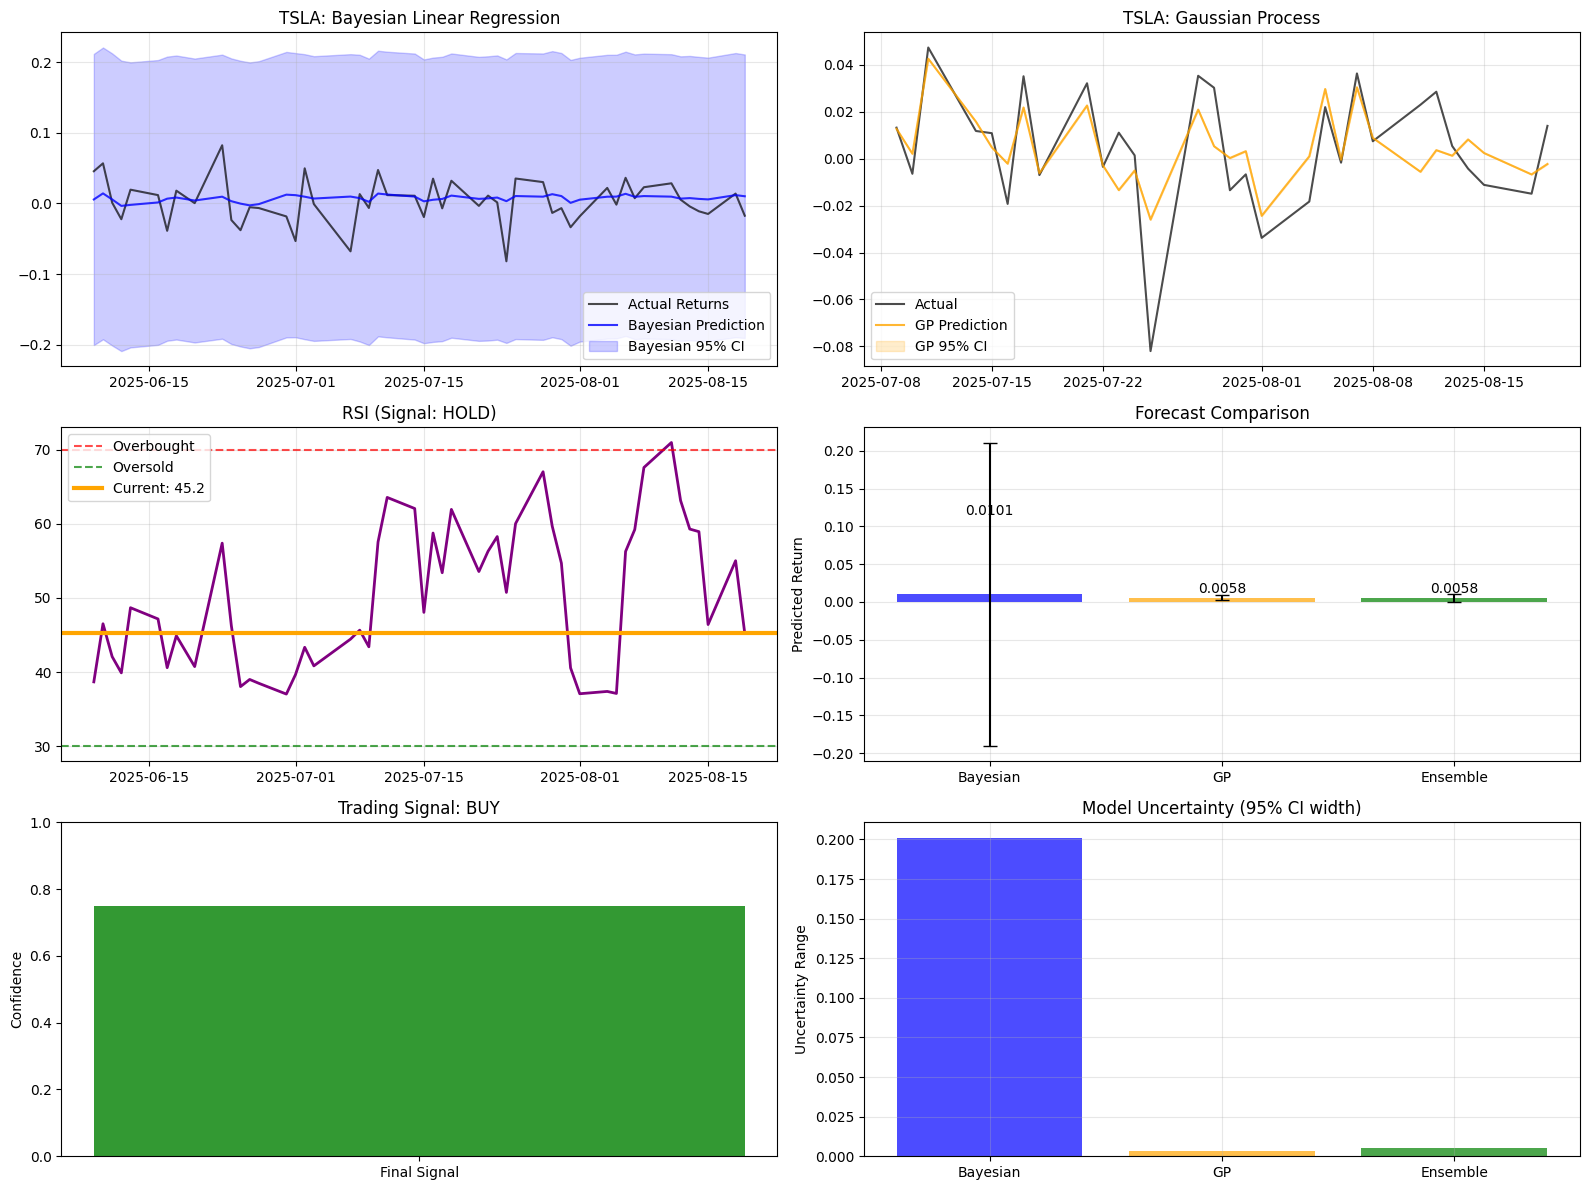


📊 TSLA - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0101 ± 0.2008
🟠 GP Forecast:       0.0058 ± 0.0035
🟢 Ensemble Forecast: 0.0058 ± 0.0053
📈 RSI Signal:        HOLD (RSI: 45.2)
🎯 Final Signal:      BUY (Confidence: 75.0%)
💰 Recommendation:    BUY
✓ TSLA: buy @ 0.75
Processing JPM (8/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for JPM...
🟠 Running Gaussian Process for JPM...


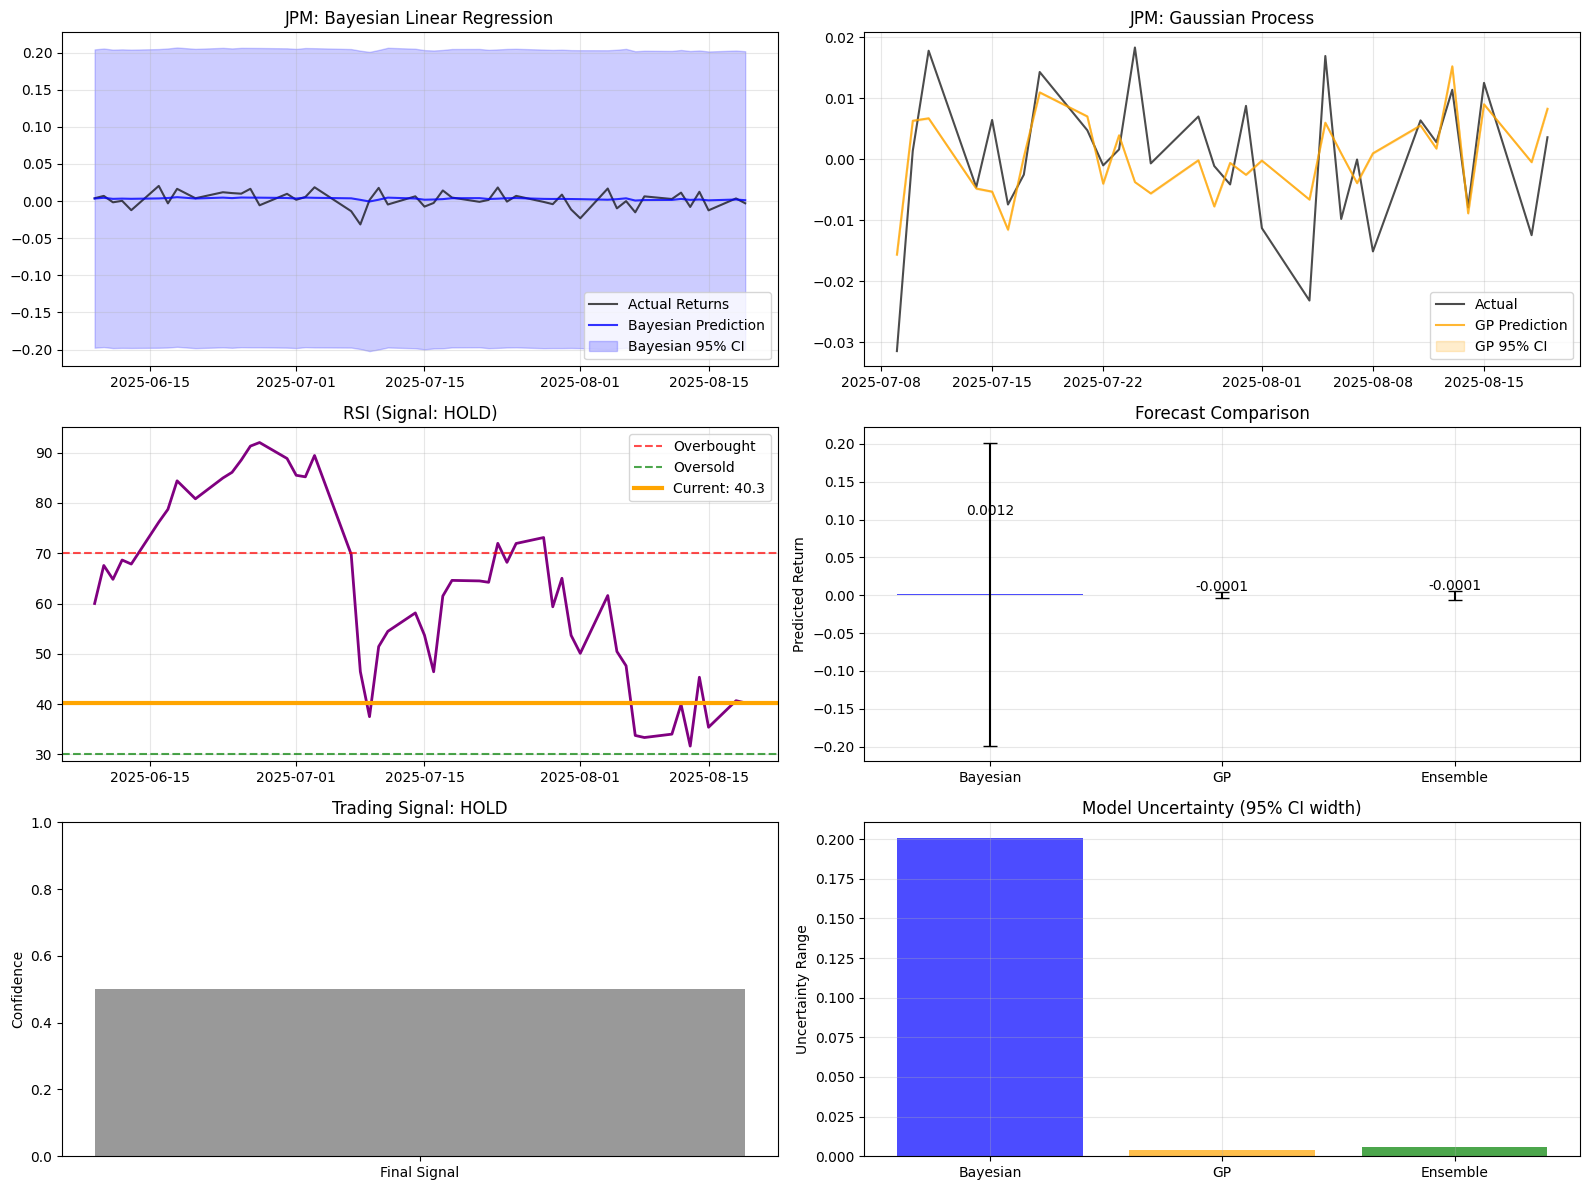


📊 JPM - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0012 ± 0.2006
🟠 GP Forecast:       -0.0001 ± 0.0037
🟢 Ensemble Forecast: -0.0001 ± 0.0056
📈 RSI Signal:        HOLD (RSI: 40.3)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ JPM: hold @ 0.5
Processing V (9/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for V...
🟠 Running Gaussian Process for V...


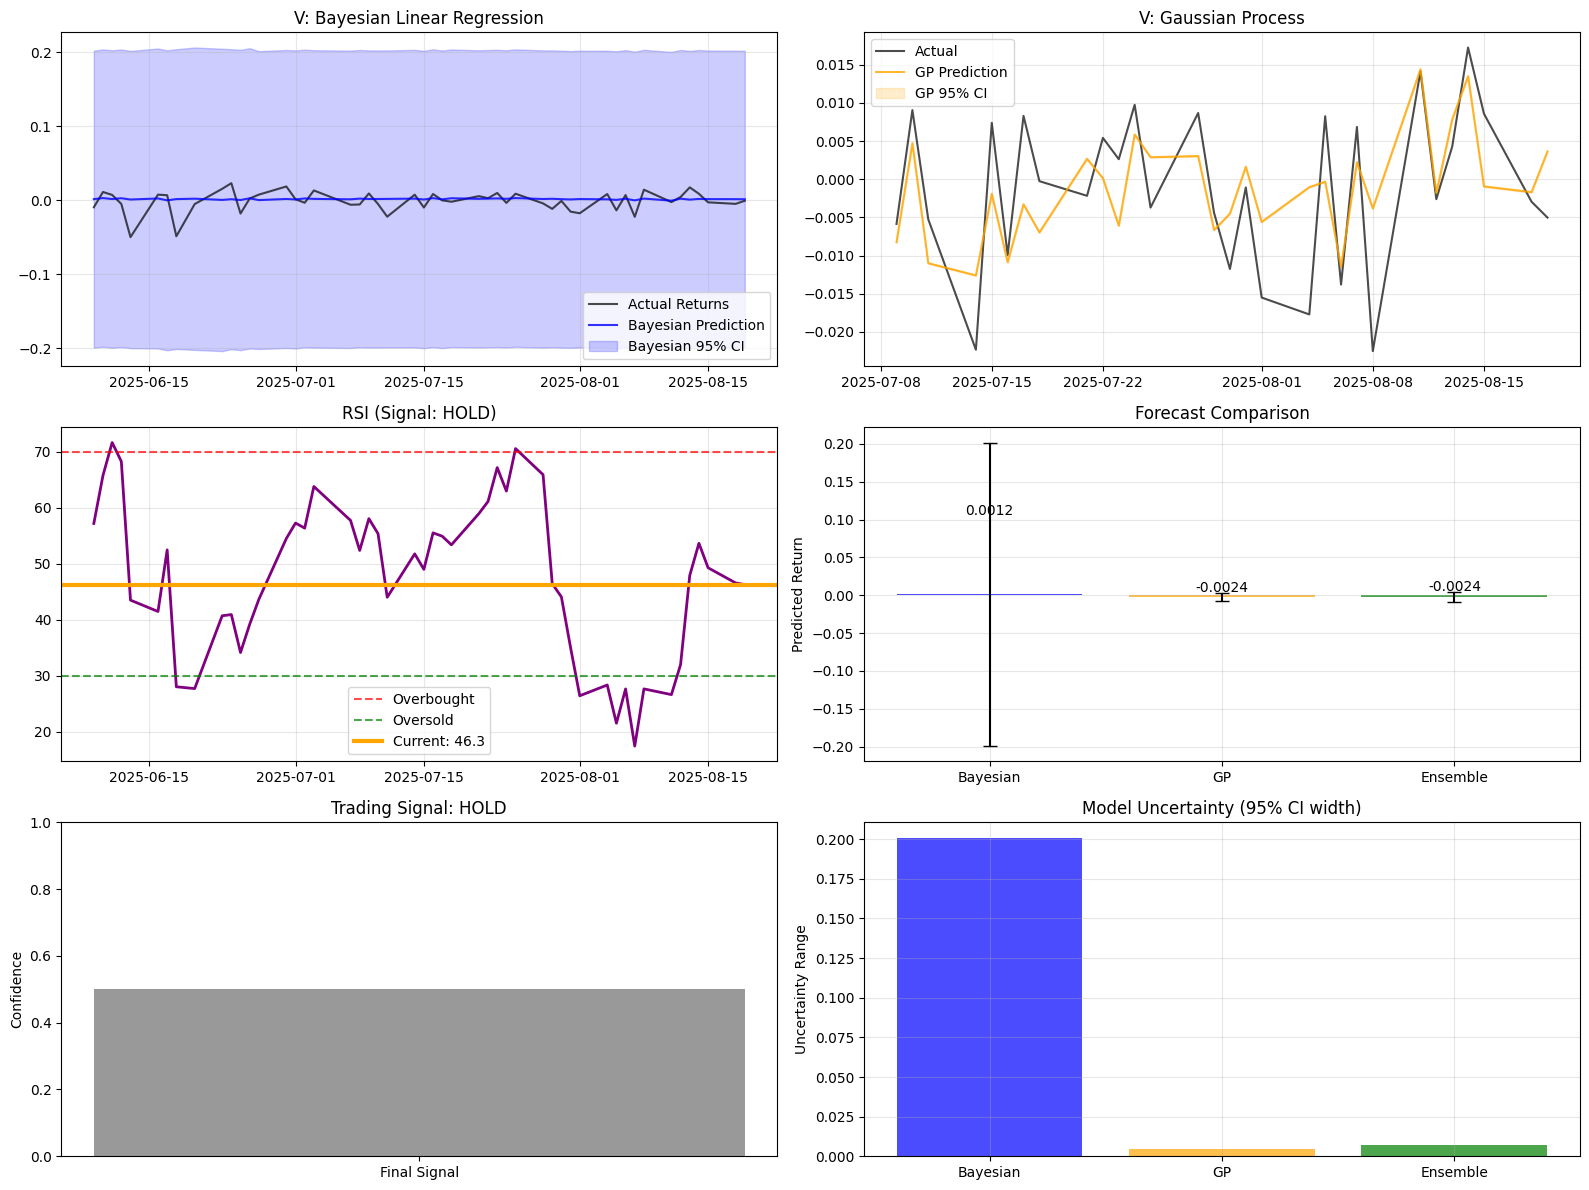


📊 V - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0012 ± 0.2006
🟠 GP Forecast:       -0.0024 ± 0.0047
🟢 Ensemble Forecast: -0.0024 ± 0.0069
📈 RSI Signal:        HOLD (RSI: 46.3)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ V: hold @ 0.5
Processing UNH (10/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for UNH...
🟠 Running Gaussian Process for UNH...


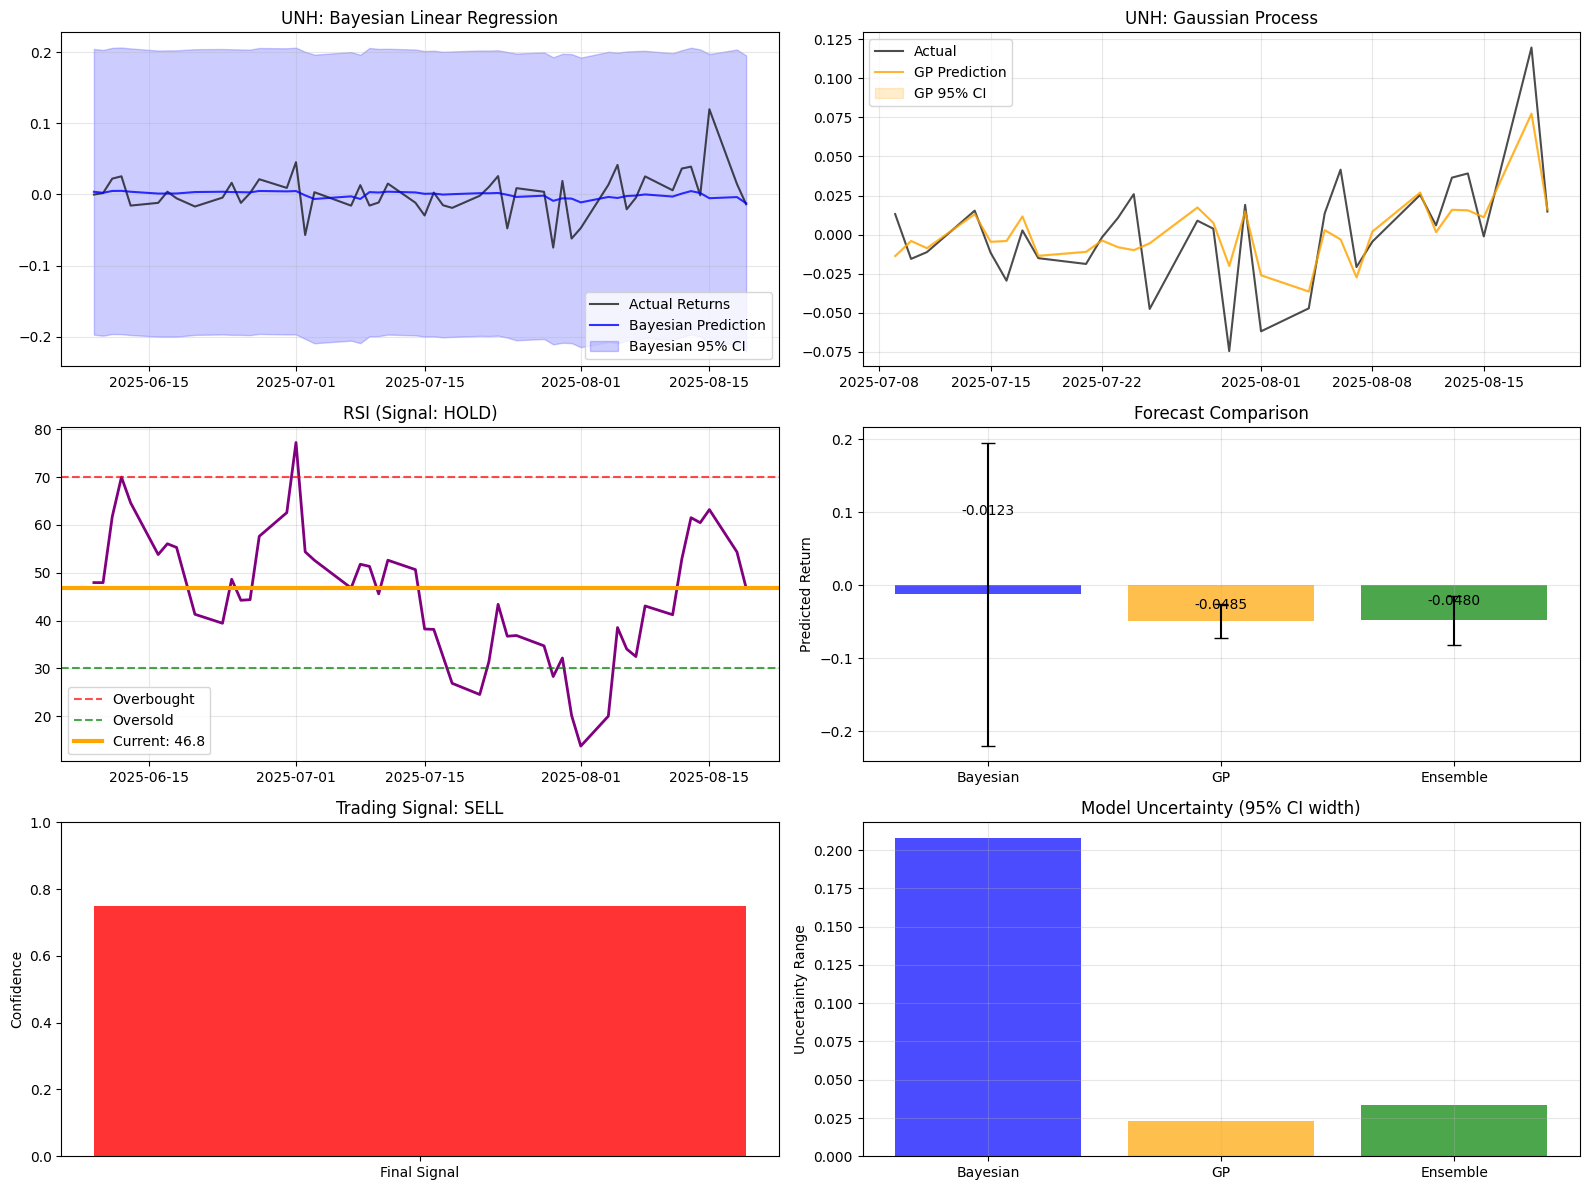


📊 UNH - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: -0.0123 ± 0.2078
🟠 GP Forecast:       -0.0485 ± 0.0233
🟢 Ensemble Forecast: -0.0480 ± 0.0338
📈 RSI Signal:        HOLD (RSI: 46.8)
🎯 Final Signal:      SELL (Confidence: 75.0%)
💰 Recommendation:    SELL
✓ UNH: sell @ 0.75
Processing SPY (11/11)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for SPY...
🟠 Running Gaussian Process for SPY...


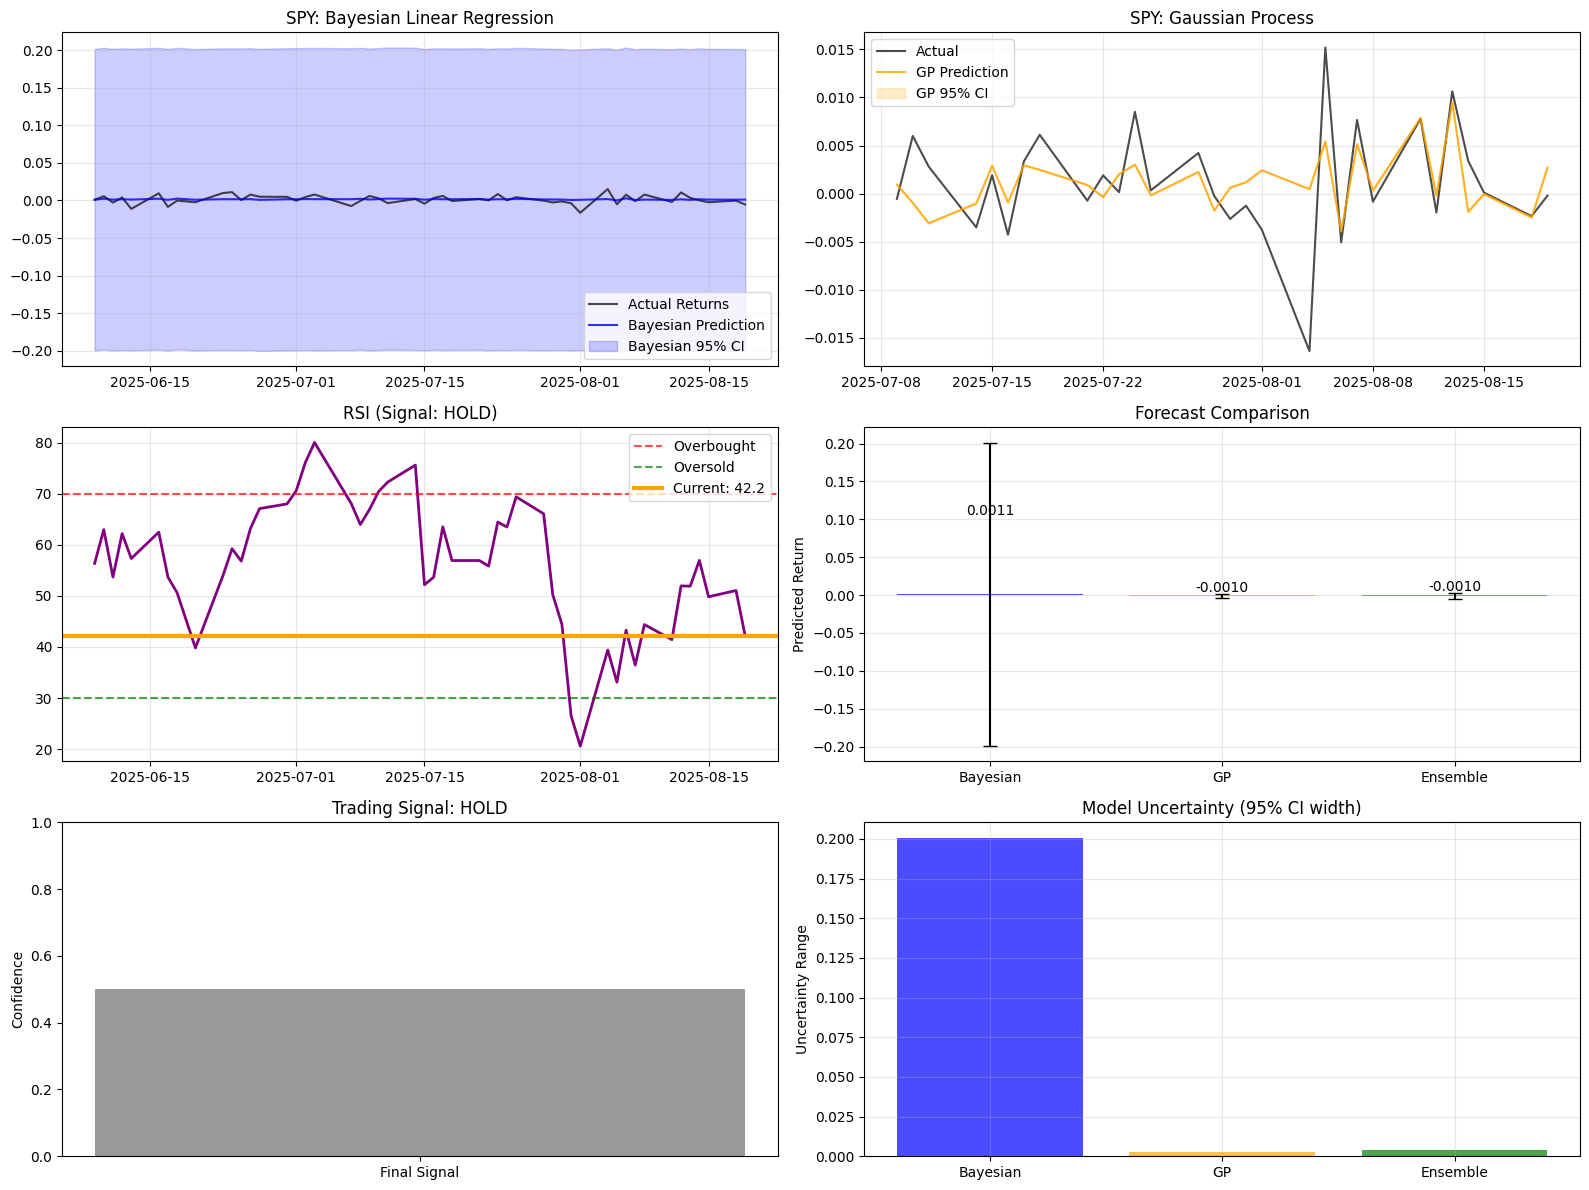


📊 SPY - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0011 ± 0.2004
🟠 GP Forecast:       -0.0010 ± 0.0026
🟢 Ensemble Forecast: -0.0010 ± 0.0042
📈 RSI Signal:        HOLD (RSI: 42.2)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ SPY: hold @ 0.5
[skip] AAPL: sig=sell, conf=0.75, f=-0.015246977800570664, std=0.007306700348119402, z=-2.0867117952216185, p_up=0.018457097202671413, $move=-3.5153432016995723
[skip] AMZN: sig=hold, conf=0.5, f=-0.0018258141704803406, std=0.0038275031743028203, z=-0.4770248612041746, p_up=0.3166722092073835, $move=-0.4162947599403701
[skip] GOOGL: sig=hold, conf=0.5, f=-0.00026072270920637615, std=0.0023517221410969762, z=-0.11086458925150075, p_up=0.4558618630687026, $move=-0.052572127084373685
[skip] NVDA: sig=hold, conf=0.5, f=-0.0012962339662480403, std=0.0020779662413532188, z=-0.6237993382432928, p_up=0.26637968715130184, $move=-0.22769645851113074
[skip] JPM: sig=hold, conf=0.5, f=-8.269394448979367e-05, std=0.

In [20]:
MAX_ORDERS_PER_RUN = 1
DRY_RUN = True
print(run_once())

#DRY_RUN = False

[note] Market appears closed; DAY orders will queue until open.
Processing SPY (1/8)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for SPY...
🟠 Running Gaussian Process for SPY...


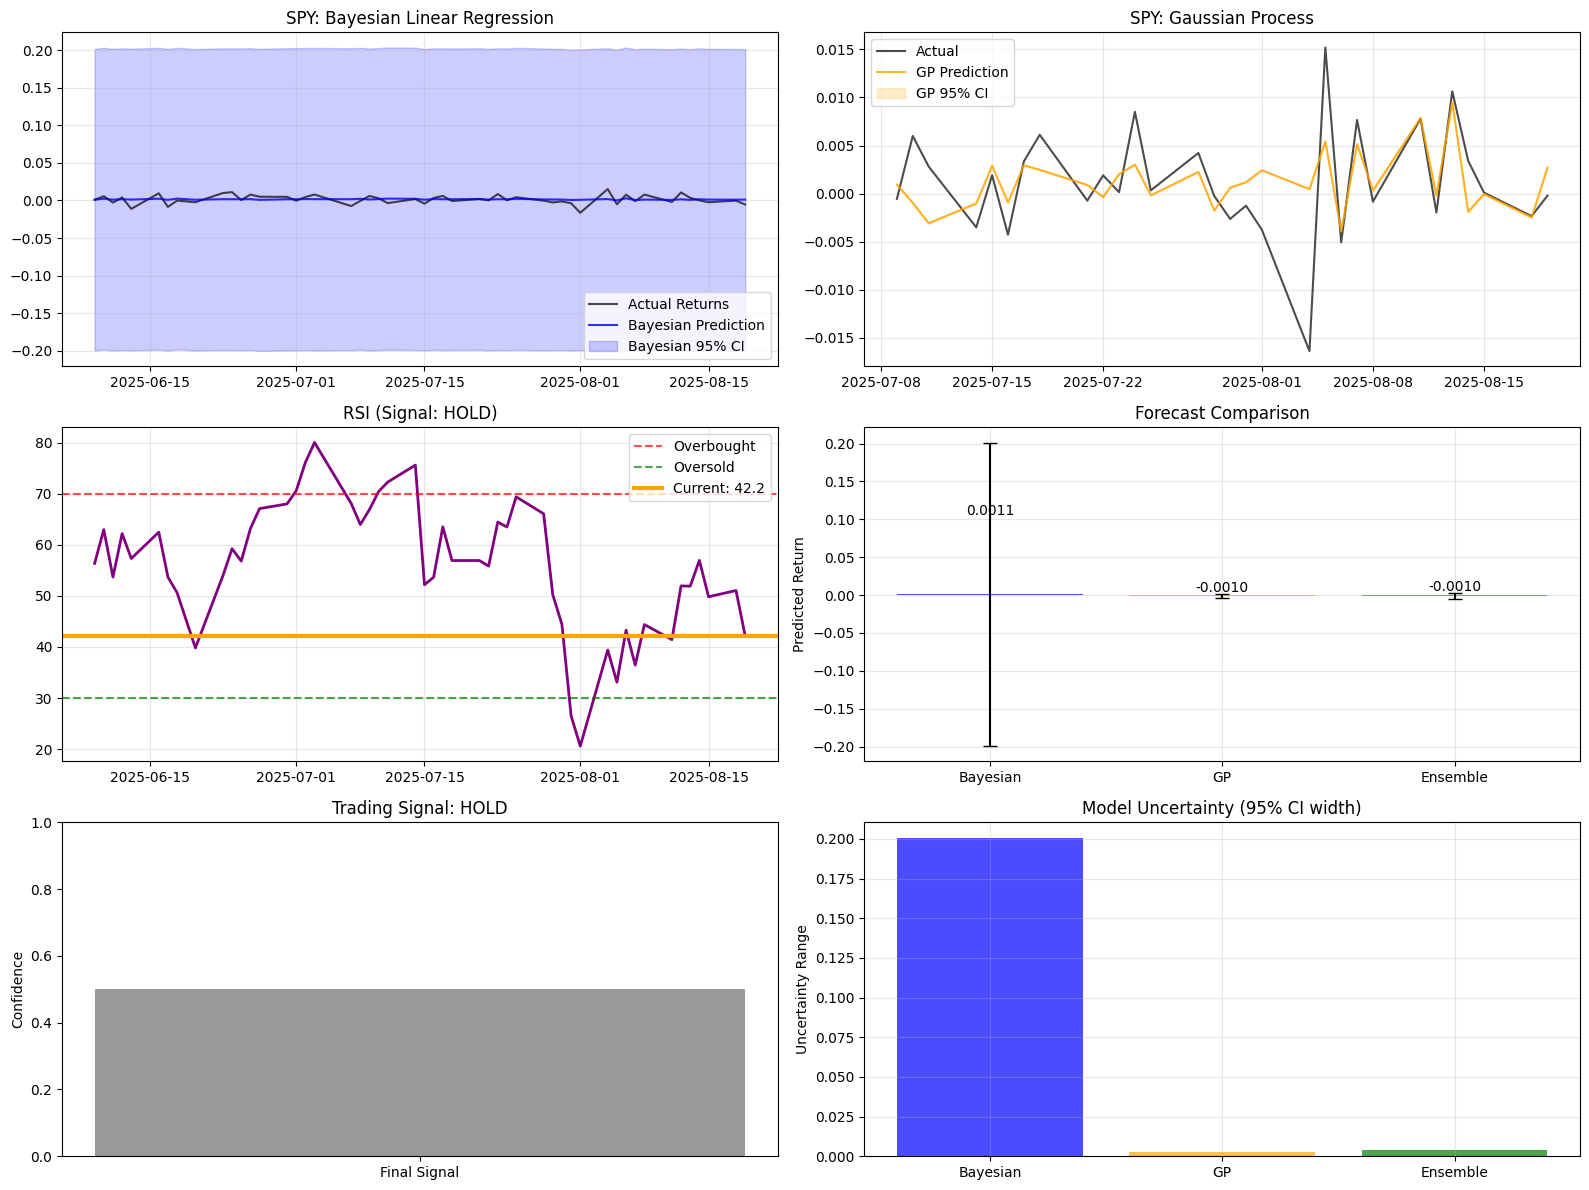


📊 SPY - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0011 ± 0.2004
🟠 GP Forecast:       -0.0010 ± 0.0026
🟢 Ensemble Forecast: -0.0010 ± 0.0042
📈 RSI Signal:        HOLD (RSI: 42.2)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ SPY: hold @ 0.5
Processing AAPL (2/8)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for AAPL...
🟠 Running Gaussian Process for AAPL...


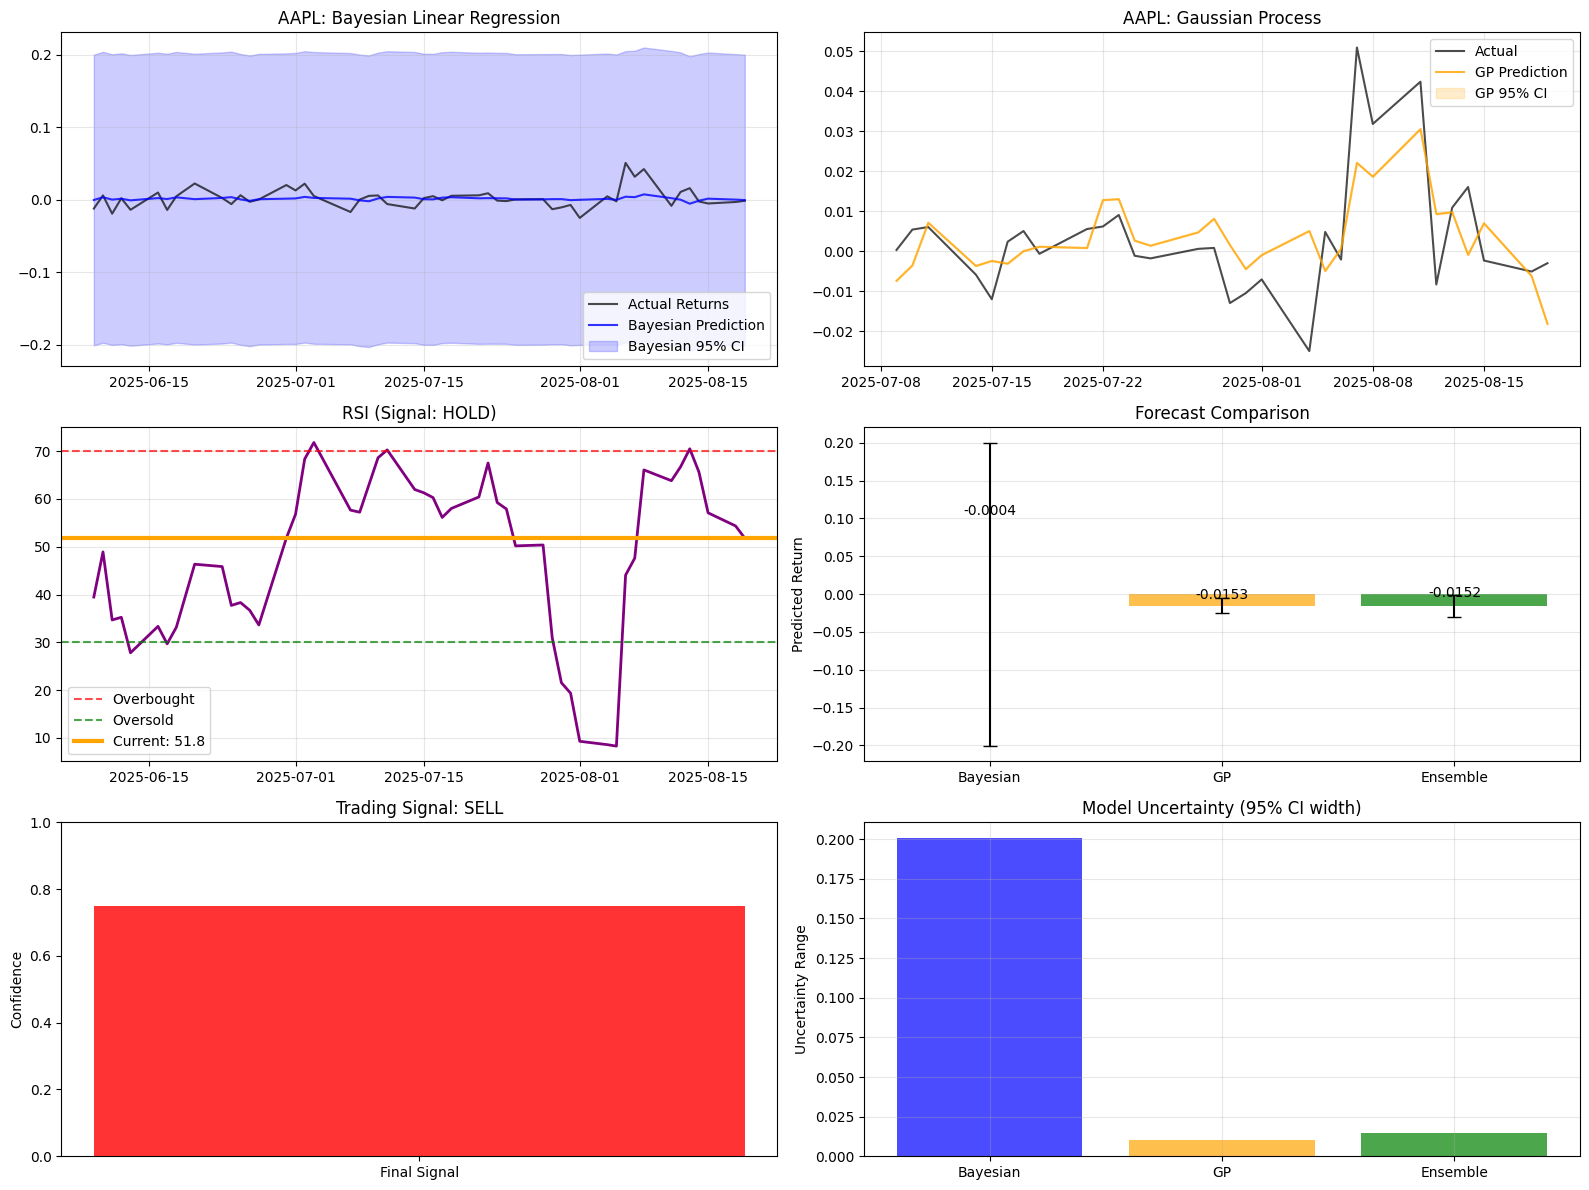


📊 AAPL - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: -0.0004 ± 0.2006
🟠 GP Forecast:       -0.0153 ± 0.0102
🟢 Ensemble Forecast: -0.0152 ± 0.0146
📈 RSI Signal:        HOLD (RSI: 51.8)
🎯 Final Signal:      SELL (Confidence: 75.0%)
💰 Recommendation:    SELL
✓ AAPL: sell @ 0.75
Processing MSFT (3/8)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for MSFT...
🟠 Running Gaussian Process for MSFT...


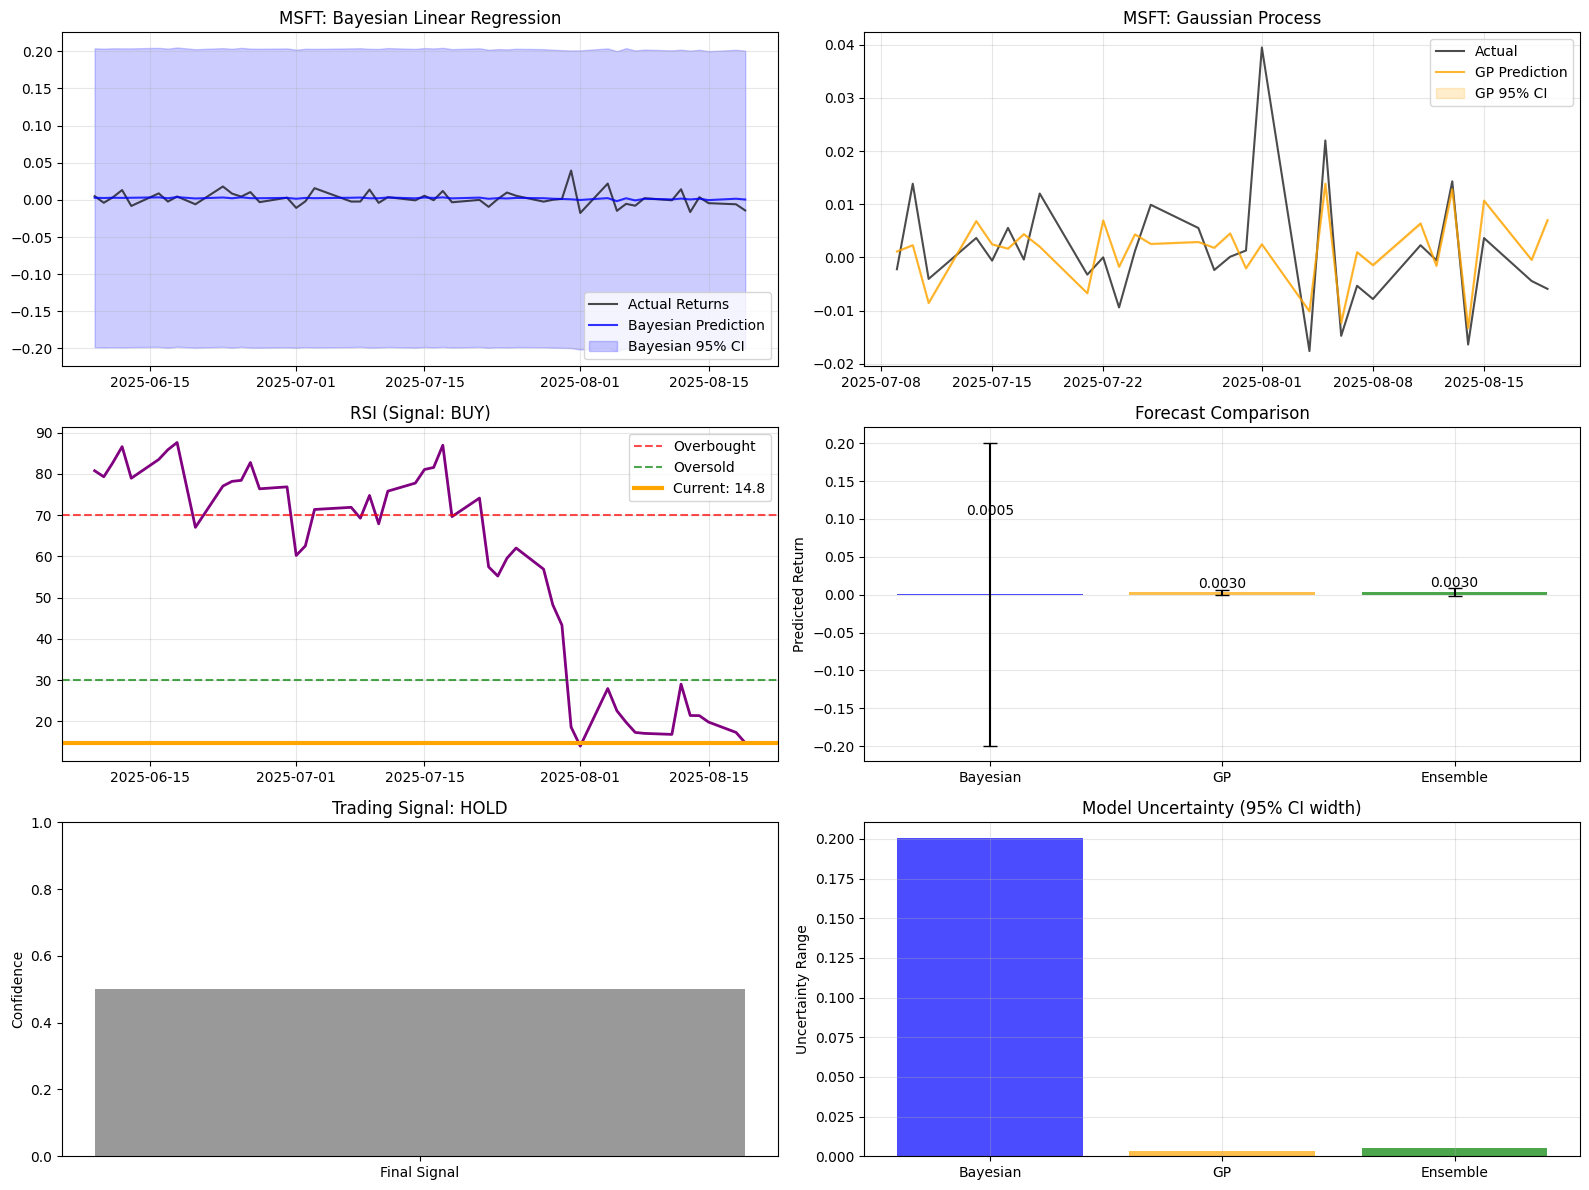


📊 MSFT - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0005 ± 0.2004
🟠 GP Forecast:       0.0030 ± 0.0034
🟢 Ensemble Forecast: 0.0030 ± 0.0053
📈 RSI Signal:        BUY (RSI: 14.8)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ MSFT: hold @ 0.5
Processing NVDA (4/8)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for NVDA...
🟠 Running Gaussian Process for NVDA...


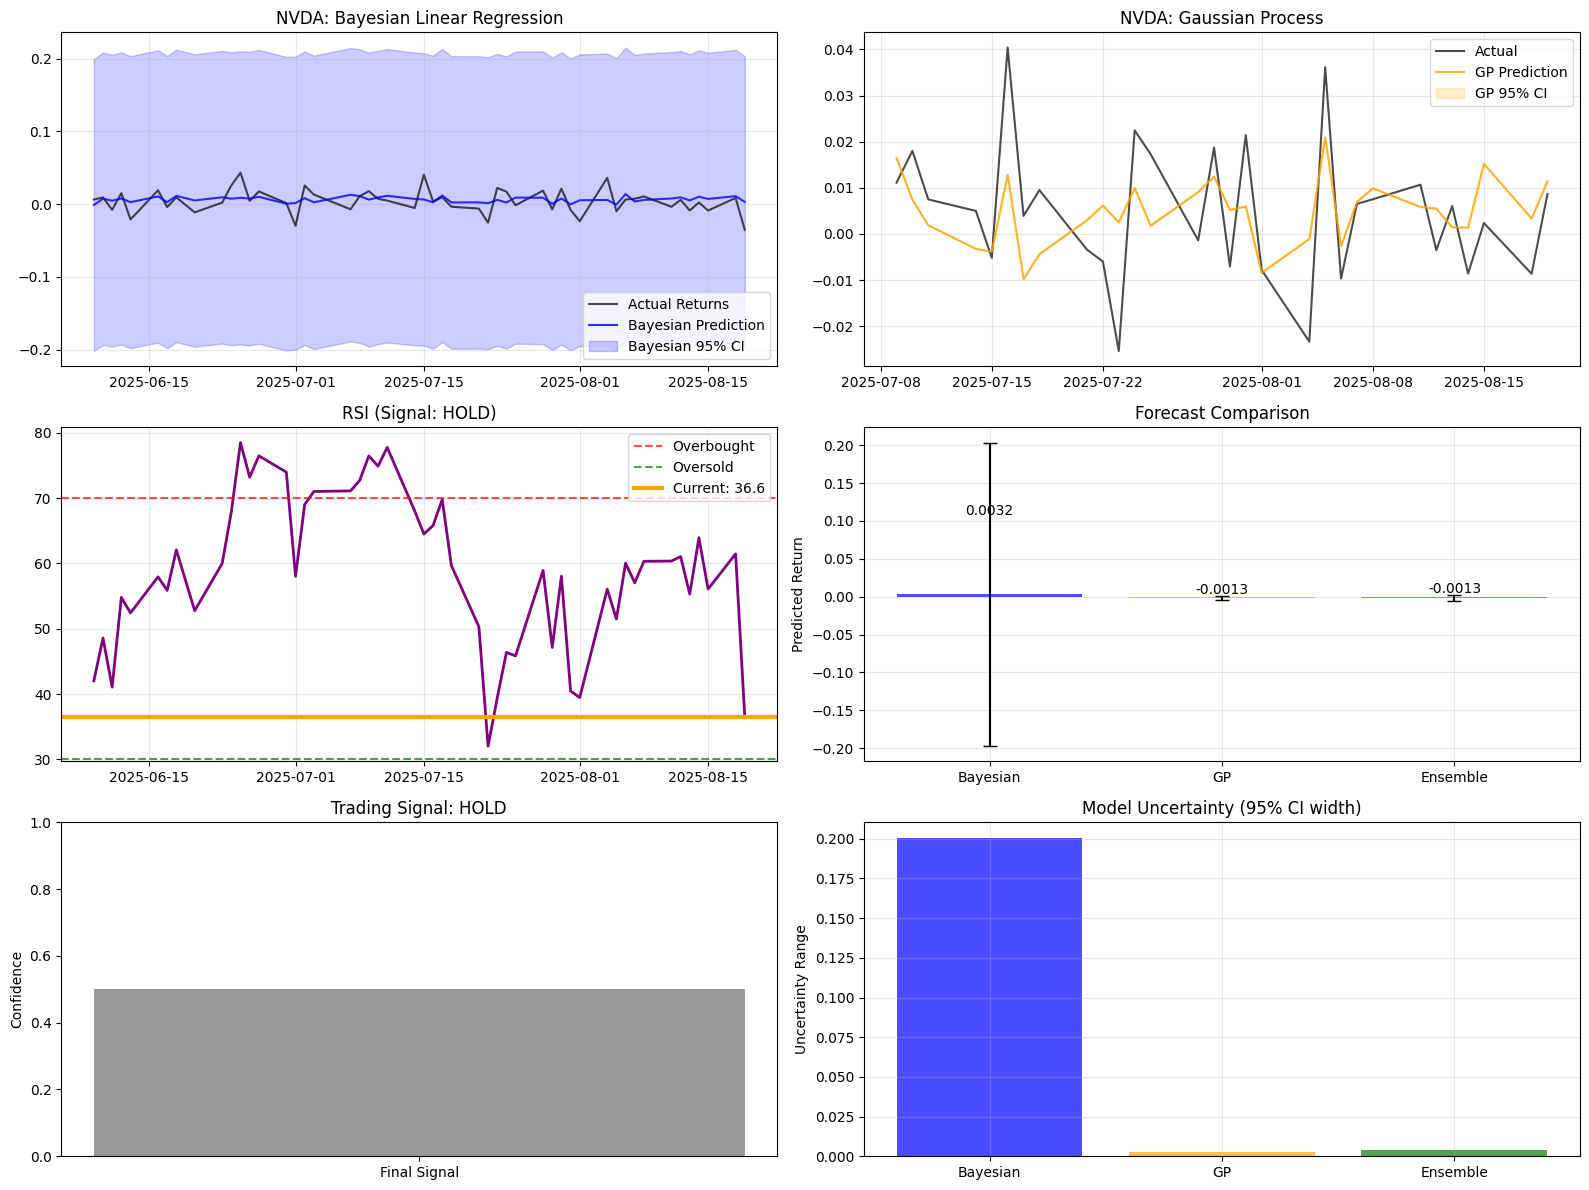


📊 NVDA - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0032 ± 0.2003
🟠 GP Forecast:       -0.0013 ± 0.0026
🟢 Ensemble Forecast: -0.0013 ± 0.0042
📈 RSI Signal:        HOLD (RSI: 36.6)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ NVDA: hold @ 0.5
Processing TSLA (5/8)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for TSLA...
🟠 Running Gaussian Process for TSLA...


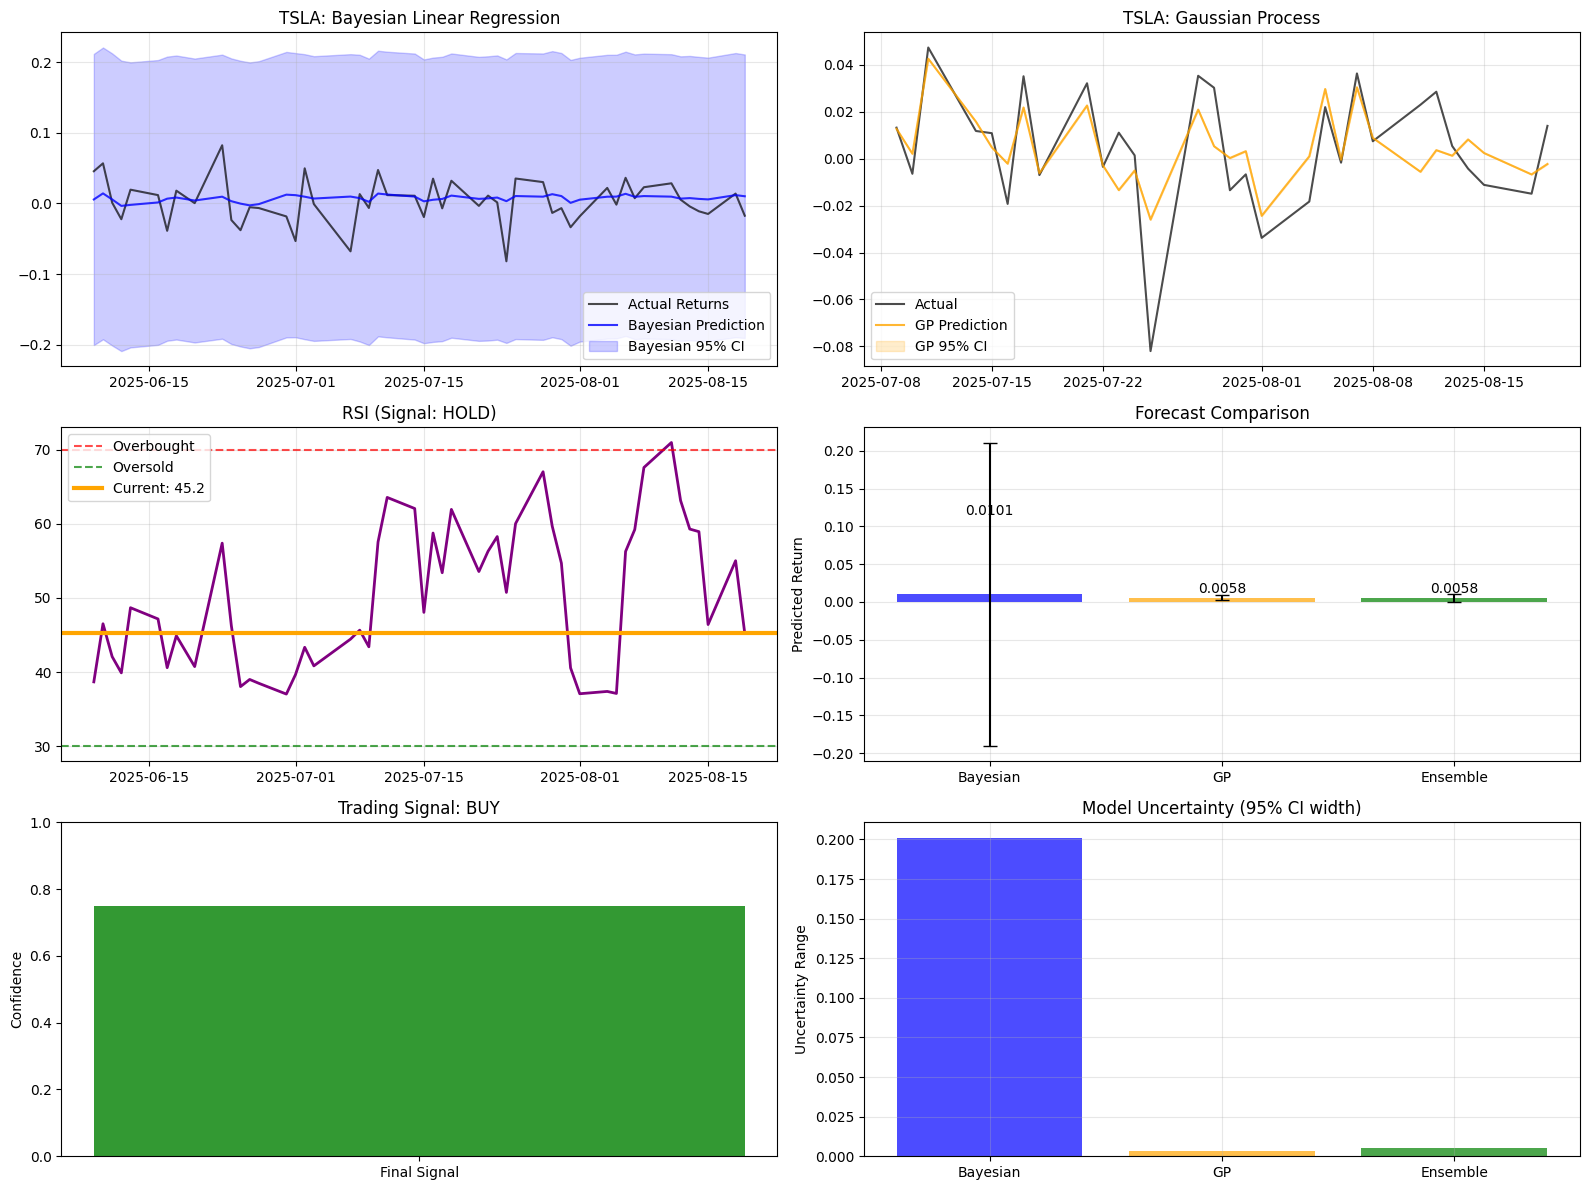


📊 TSLA - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0101 ± 0.2008
🟠 GP Forecast:       0.0058 ± 0.0035
🟢 Ensemble Forecast: 0.0058 ± 0.0053
📈 RSI Signal:        HOLD (RSI: 45.2)
🎯 Final Signal:      BUY (Confidence: 75.0%)
💰 Recommendation:    BUY
✓ TSLA: buy @ 0.75
Processing AMZN (6/8)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for AMZN...
🟠 Running Gaussian Process for AMZN...


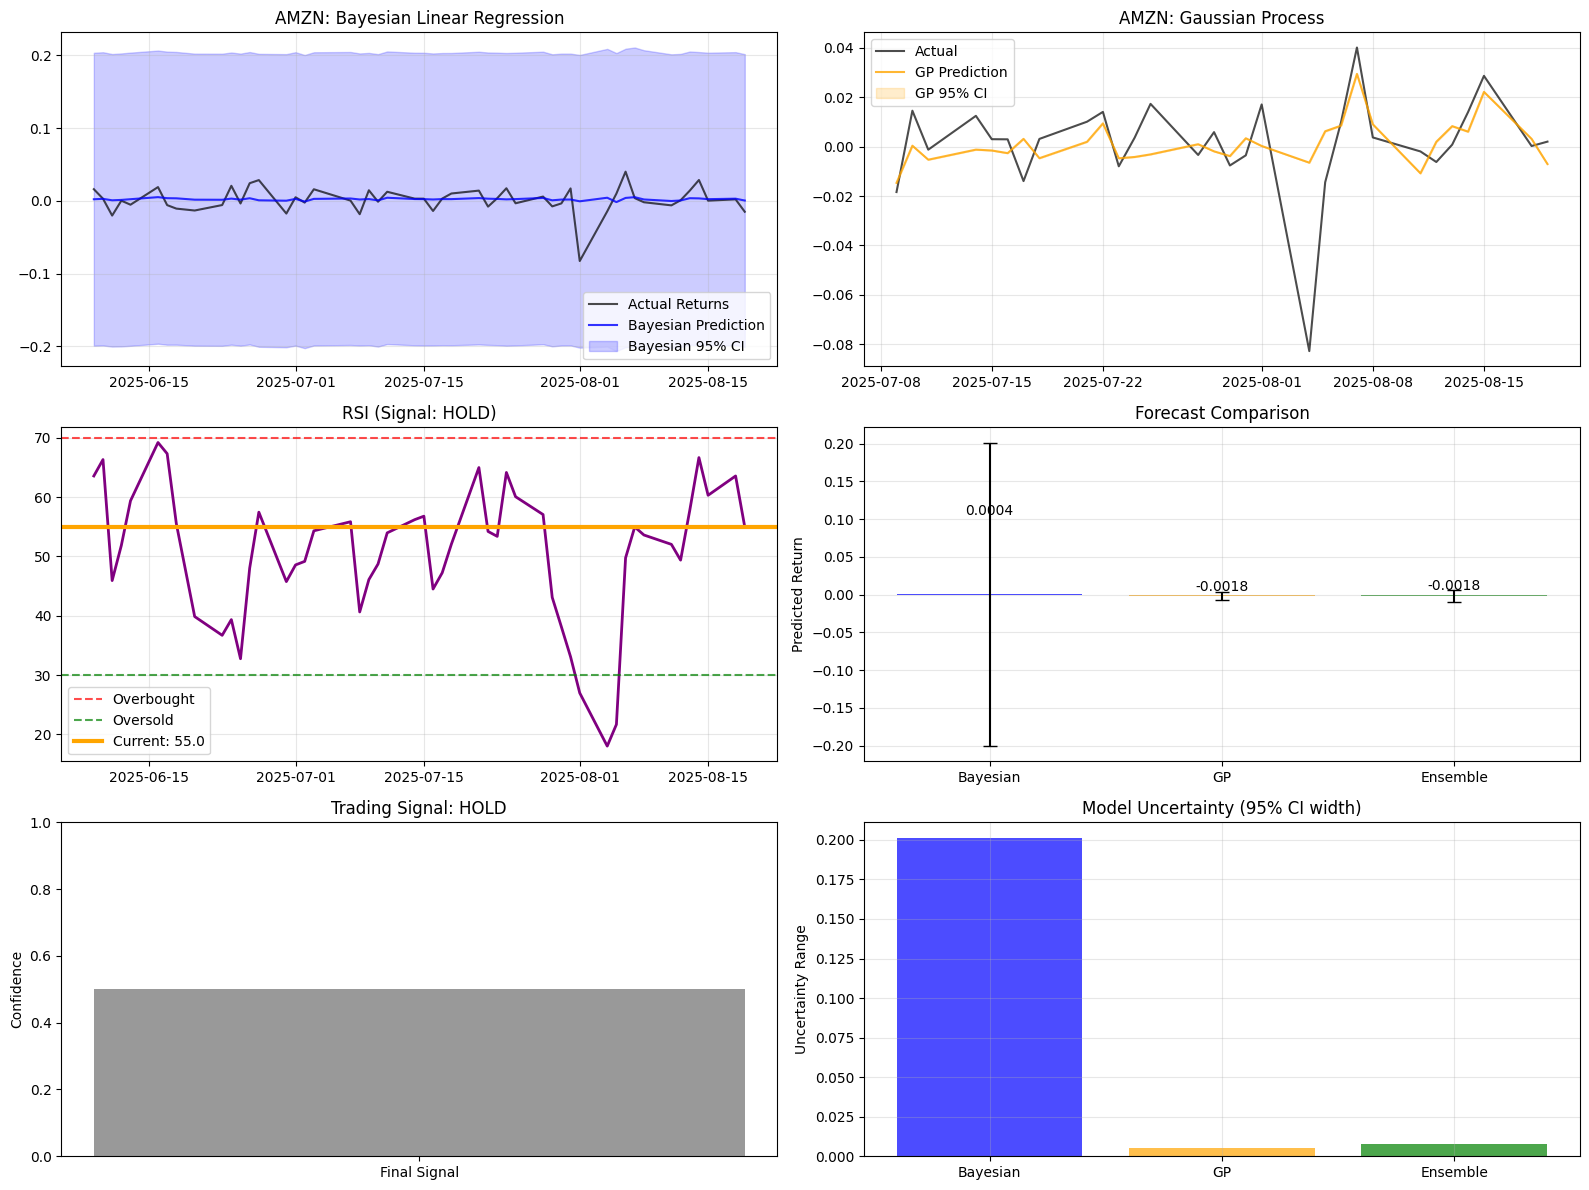


📊 AMZN - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0004 ± 0.2010
🟠 GP Forecast:       -0.0018 ± 0.0052
🟢 Ensemble Forecast: -0.0018 ± 0.0077
📈 RSI Signal:        HOLD (RSI: 55.0)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ AMZN: hold @ 0.5
Processing GOOGL (7/8)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for GOOGL...
🟠 Running Gaussian Process for GOOGL...


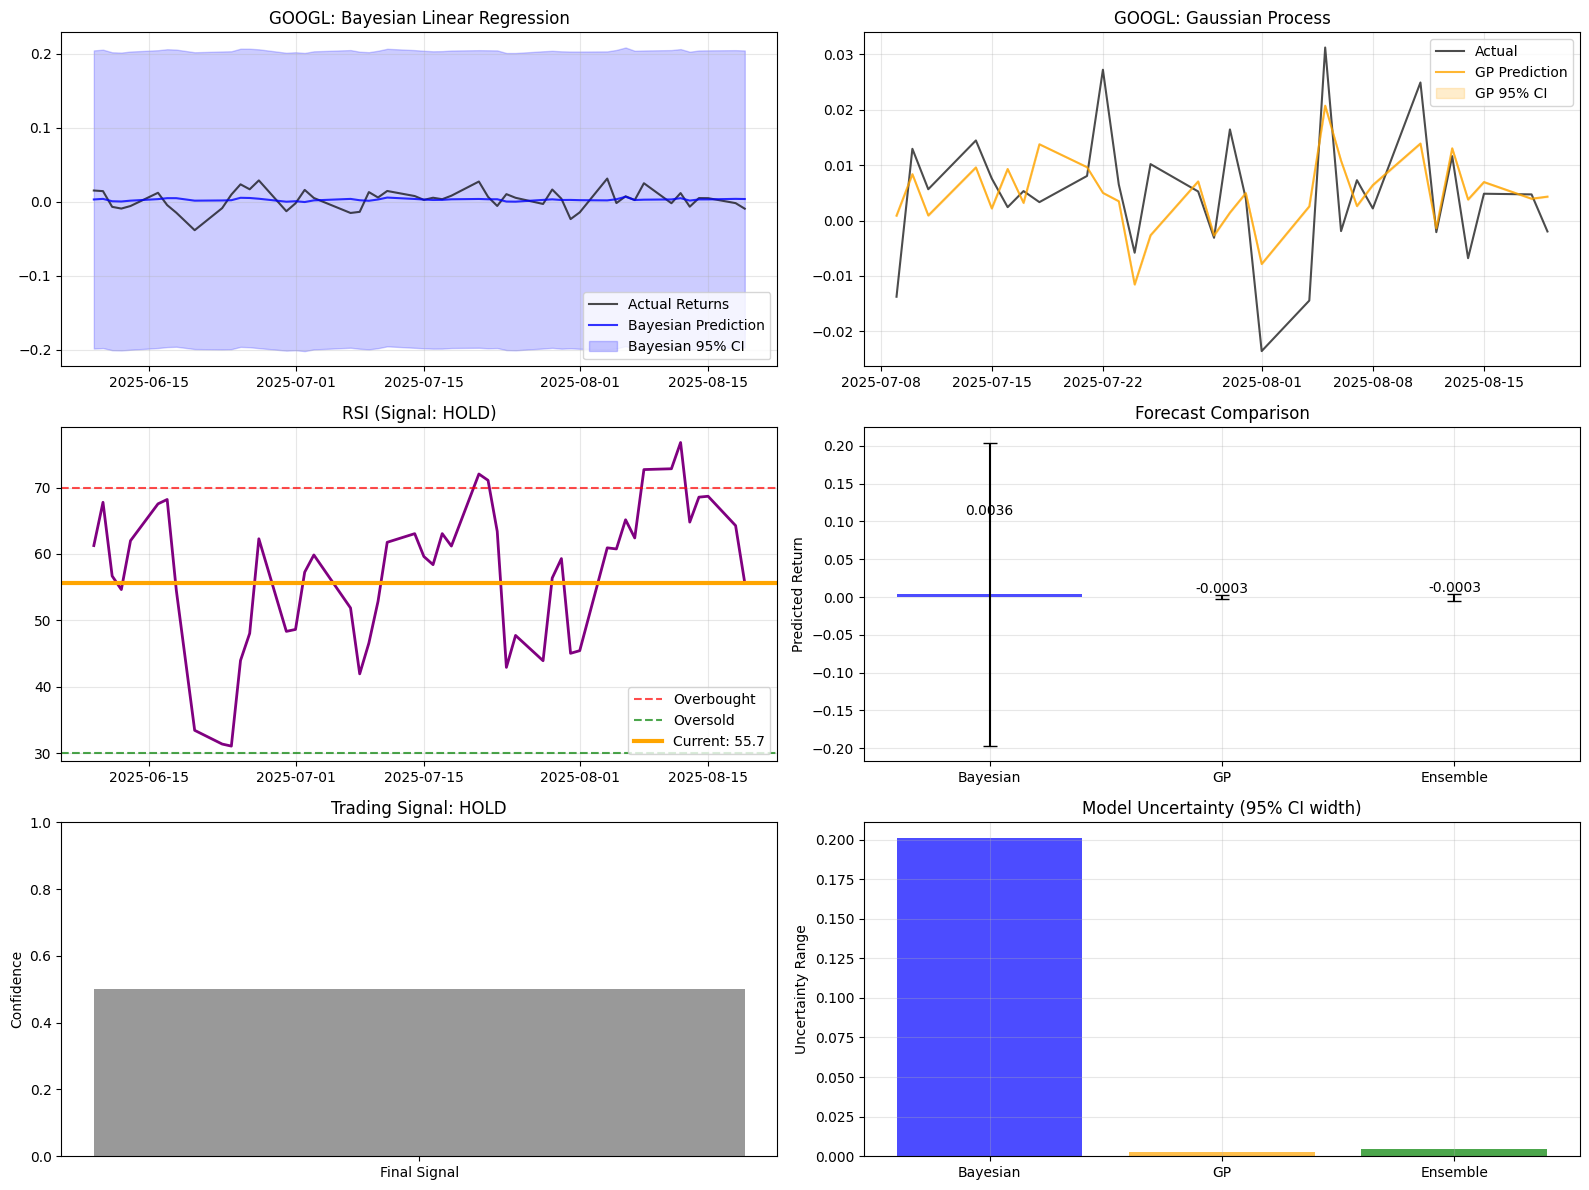


📊 GOOGL - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0036 ± 0.2008
🟠 GP Forecast:       -0.0003 ± 0.0030
🟢 Ensemble Forecast: -0.0003 ± 0.0047
📈 RSI Signal:        HOLD (RSI: 55.7)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ GOOGL: hold @ 0.5
Processing META (8/8)...


[*********************100%***********************]  1 of 1 completed



🔵 Running Bayesian Linear Regression for META...
🟠 Running Gaussian Process for META...


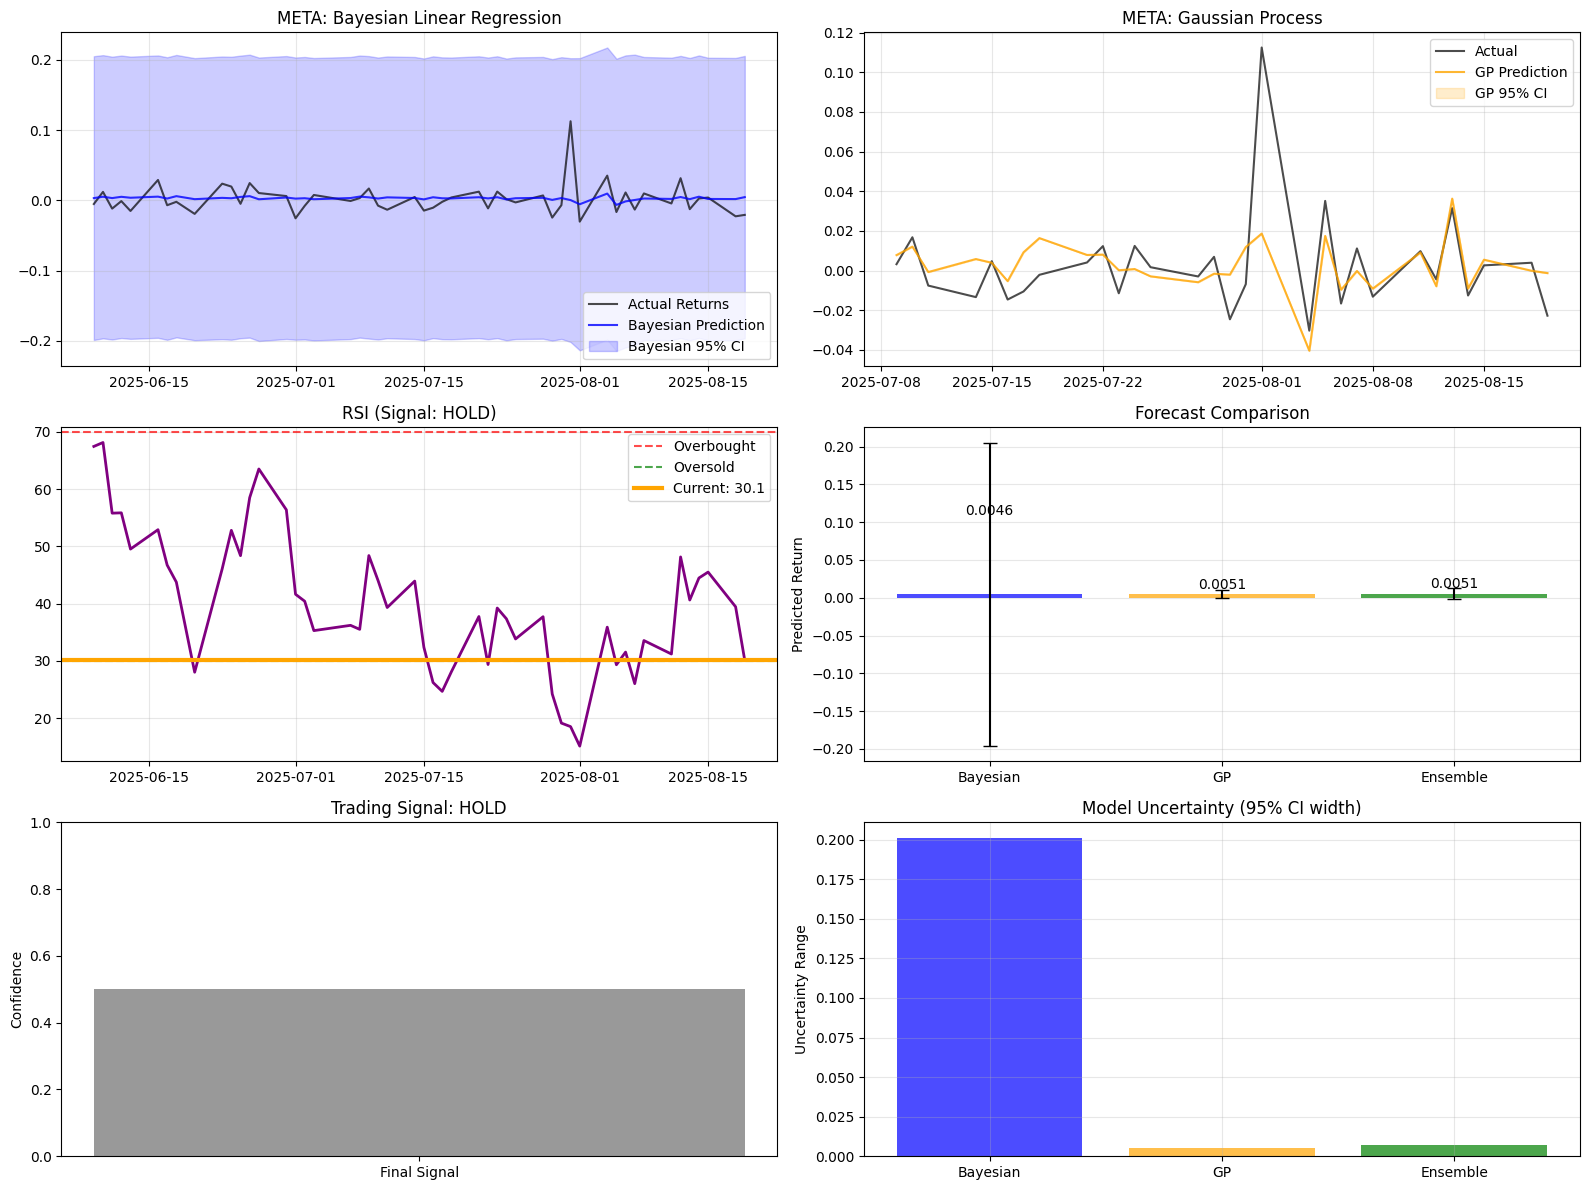


📊 META - Unified Forecast Summary (2025-08-19)
🔵 Bayesian Forecast: 0.0046 ± 0.2009
🟠 GP Forecast:       0.0051 ± 0.0050
🟢 Ensemble Forecast: 0.0051 ± 0.0073
📈 RSI Signal:        HOLD (RSI: 30.1)
🎯 Final Signal:      HOLD (Confidence: 50.0%)
💰 Recommendation:    HOLD
✓ META: hold @ 0.5
[skip] SPY: sig=hold, conf=0.5, f=-0.000982935868101755, std=0.00208235102018824, z=-0.4720317845417339, p_up=0.3184520508271786, $move=-0.628970832639632
[skip] AAPL: sig=sell, conf=0.75, f=-0.015246979611970917, std=0.007306704573853303, z=-2.086710836309369, p_up=0.018457140568812536, $move=-3.5153436193360146
[skip] NVDA: sig=hold, conf=0.5, f=-0.001296231692346655, std=0.002077960349872099, z=-0.6238000125586802, p_up=0.26637946570140053, $move=-0.2276960590776134
[skip] AMZN: sig=hold, conf=0.5, f=-0.0018258141704803406, std=0.0038275031743028203, z=-0.4770248612041746, p_up=0.3166722092073835, $move=-0.4162947599403701
[skip] GOOGL: sig=hold, conf=0.5, f=-0.00026073340649465074, std=0.00235171064

In [21]:
# ...existing code...
UNIVERSE = ["SPY","AAPL","MSFT","NVDA","TSLA","AMZN","GOOGL","META"]
MAX_ORDERS_PER_RUN = 1
DRY_RUN = False
print(run_once())


In [22]:
from tabulate import tabulate

# ANSI colors
GREEN = "\033[92m"
RED = "\033[91m"
RESET = "\033[0m"

positions = client.get_all_positions()

if not positions:
    print(f"{RED}No current positions.{RESET}")
else:
    table_data = []
    for pos in positions:
        # Color quantity green if long, red if short
        qty_color = GREEN if float(pos.qty) > 0 else RED
        table_data.append([
            pos.symbol,
            f"{qty_color}{pos.qty}{RESET}",
            f"${pos.avg_entry_price}"
        ])

    print("📊 Current Positions:")
    print(tabulate(
        table_data,
        headers=["Symbol", "Quantity", "Avg Entry Price"],
        tablefmt="fancy_grid"
    ))


NameError: name 'client' is not defined